<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Machine_learning/test_training_ST_on_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Training NN model(s) on theoretical data generated via the simple physical model

In [ ]:
# !pip install lmfit
# !pip install importlib-metadata
#!pip install seaborn
# !pip install -q tensorflow-model-optimization


In [4]:
#import cv2
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd
import numpy as np 

# from lmfit import Model, fit_report, Parameters

#from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as kb

from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize 
from matplotlib import cm
import io

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


######### initialize the data ###############
data_input=[]
data_output=[]
l_sample=300
vol_all=[]
vol2_all=[]
data_x=[]
data_y=[]
data_h=[]
data_w=[]
R_sph_all=[]
Ar=[]
#st_all=[]
rho=[]
theta=[]
#List of non-processed images:
discarded=[]
new=[]  #list of images without the discarded ones

#For the simple approach fit
phi_final=[]
theta_az=[]
theta_all=[]
theta_final=[]
r_theta_all=[]
xc_all=[]
yc_all=[]
rho_final=[]
data_Ps=[]
data_dB=[]
data_stderr=[]
data_err=[]

total_num_pictures = len(glob.glob1('.',"*.png"))
frame_number=np.arange(total_num_pictures)

gamma=64 #[N/m]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
#Calibration
needle_d=0.83 #mm
needle_pxl=220 #pixels
#calibration=0.00621722846441948**3
cal=needle_d/needle_pxl
calibration=(cal)**3


###############################################################################
#### Functions used in the data processing ####################################
###############################################################################

def calc_volume(x,y):
    """
    Calculate the drop volume from a shape matrix.

    Parameters
    ----------
    x, y - contour of the drop

    Returns
    -------
    Integrated volume using for the given shape matrix.

    """
    # data selection
    idx=x<=0  # r=right
    x_l=x[idx]
    y_l=y[idx]
        
    vol_left=trapz(np.pi*x_l**2, y_l)/2
        
    # data selection
    idx=x>=0  # r=right
    x_r=x[idx]
    y_r=y[idx]
    vol_right=-trapz(np.pi*x_r**2, y_r)/2
   
    return vol_left+vol_right


def calc_R_sph(vol):
    """
    Calculate the spherical radius of a droplet based on the volume.

    Input parameters
    ----------
    vol:         volume   [pixels**3]
    calibration: calibration factor  [mm**3/pixels**3]

    Returns
    -------
    Corresponding spherical radius.  [mm]

    """
#    calibration=0.00621722846441948**3
    #R_sph=(3*vol*calibration/(4*np.pi))**(1/3)
    R_sph=(3*vol/(4*np.pi))**(1/3)
    return R_sph

def calc_dB(Ps):
    """
    Calculate the deci Bell (dB) value for each acoustic pressure Ps.

    Input parameters
    ----------
    Ps:     aplitude of the acoustic pressure

    Returns
    -------
    dB value. []

    """
    Po=2*10**(-5) #[Pa]

    return 20*np.log10(Ps/Po)     #Acoustic pressure [Pa]

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
#    Ps=calc_ampl(dB)
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))
    return ct_new*(3*(np.cos(th))**2-1)+R_sph


def R_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph

def ST_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph


def azimuth_old(phi):
    """
    Calculate the azimuthal angle.

    Input parameters
    ----------
    phi:     angle phi

    Returns
    -------
    Azimuthal angle.

    """
    if phi<=np.pi/2:
        theta=np.pi/2-phi
    else:
        theta=2.5*np.pi-phi
    return theta


def azimuth(x, y):
    """
    Calculate the azimuthal angle.
    Input parameters
    ----------
    x, y: Cartesian coordinates of contour of the drop [mm]
    Returns
    -------
    Azimuthal angle in [rad]
    """
    a=np.arctan2(x, y)
    return a

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, rho)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def pol2cart_theta(rho, theta):
    x = rho * np.sin(theta)
    y = rho * np.cos(theta)
    return(x, y)

def log_interp1d(xx, yy, kind='linear'):            #Used for the ST calculation
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx


2.8.2
Num GPUs Available:  0


Check the connection to google's **GPU**

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Check the connection to google's **TPU**

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.83.205.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.83.205.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


### Generate data based on experimental data

Run the next code box only if google drive is not mounted to colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Raw datasets

In [6]:
# #From the drive folder that is mounted to collab go to the file that you are interested in, 
# #right click and copy the path of the file. Paste it in csvfilename:
path_files=str('/content/drive/My Drive/DropLev/for_draft/Experimental/Raw_data/')
os.chdir(path_files)

# fileSDS1=pd.read_csv(str('SDS/SDS_conci_0.01054_all_175.csv'), sep="\t", header=None)
# fileSDS2=pd.read_csv(str('SDS/SDS_conci_0.02108_all_175.csv'), sep='\t', header=None)
# fileSDS3=pd.read_csv(str('SDS/SDS_conci_0.04273_all_175.csv'), sep='\t', header=None)
# fileSDS4=pd.read_csv(str('SDS/SDS_conci_0.08828_all_175.csv'), sep="\t", header=None)
# fileSDS5=pd.read_csv(str('SDS/SDS_conci_0.25000_all_175.csv'), sep="\t", header=None)
# fileSDS6=pd.read_csv(str('SDS/SDS_conci_0.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS7=pd.read_csv(str('SDS/SDS_conci_0.75000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS8=pd.read_csv(str('SDS/SDS_conci_1.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS9=pd.read_csv(str('SDS/SDS_conci_1.25000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS10=pd.read_csv(str('SDS/SDS_conci_1.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS11=pd.read_csv(str('SDS/SDS_conci_2.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS12=pd.read_csv(str('SDS/SDS_conci_2.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS13=pd.read_csv(str('SDS/SDS_conci_3.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS14=pd.read_csv(str('SDS/SDS_conci_3.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS15=pd.read_csv(str('SDS/SDS_conci_4.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS16=pd.read_csv(str('SDS/SDS_conci_4.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS17=pd.read_csv(str('SDS/SDS_conci_5.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS18=pd.read_csv(str('SDS/SDS_conci_6.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS19=pd.read_csv(str('SDS/SDS_conci_7.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS20=pd.read_csv(str('SDS/SDS_conci_8.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS21=pd.read_csv(str('SDS/SDS_conci_24.75900_all_175_tilt_corr.csv'), sep="\t", header=None)

# fileTrit1=pd.read_csv(str('TritonX100/TritonX_conci_0.00250_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit2=pd.read_csv(str('TritonX100/TritonX_conci_0.00500_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit3=pd.read_csv(str('TritonX100/TritonX_conci_0.00750_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit4=pd.read_csv(str('TritonX100/TritonX_conci_0.01000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit5=pd.read_csv(str('TritonX100/TritonX_conci_0.01500_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit6=pd.read_csv(str('TritonX100/TritonX_conci_0.02000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit7=pd.read_csv(str('TritonX100/TritonX_conci_0.02500_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit8=pd.read_csv(str('TritonX100/TritonX_conci_0.03500_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit9=pd.read_csv(str('TritonX100/TritonX_conci_0.05000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit10=pd.read_csv(str('TritonX100/TritonX_conci_0.07500_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit11=pd.read_csv(str('TritonX100/TritonX_conci_0.10000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit12=pd.read_csv(str('TritonX100/TritonX_conci_0.12500_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit13=pd.read_csv(str('TritonX100/TritonX_conci_0.15000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit14=pd.read_csv(str('TritonX100/TritonX_conci_0.17500_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit15=pd.read_csv(str('TritonX100/TritonX_conci_0.20000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit16=pd.read_csv(str('TritonX100/TritonX_conci_0.25000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit17=pd.read_csv(str('TritonX100/TritonX_conci_0.30000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit18=pd.read_csv(str('TritonX100/TritonX_conci_0.45000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit19=pd.read_csv(str('TritonX100/TritonX_conci_1.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit20=pd.read_csv(str('TritonX100/TritonX_conci_3.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit21=pd.read_csv(str('TritonX100/TritonX_conci_10.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit22=pd.read_csv(str('TritonX100/TritonX_conci_44.62906_all_175_tilt_corr.csv'), sep="\t", header=None)

# fileCTAB1=pd.read_csv(str('CTAB/CTAB_conci_0.00100_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB2=pd.read_csv(str('CTAB/CTAB_conci_0.00200_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB3=pd.read_csv(str('CTAB/CTAB_conci_0.00500_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB4=pd.read_csv(str('CTAB/CTAB_conci_0.01000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB5=pd.read_csv(str('CTAB/CTAB_conci_0.01500_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB6=pd.read_csv(str('CTAB/CTAB_conci_0.05500_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB7=pd.read_csv(str('CTAB/CTAB_conci_0.10000_all_175_tilt_corr.csv'), sep="\t", header=None) #_original_ST, _old_ST
fileCTAB8=pd.read_csv(str('CTAB/CTAB_conci_0.15000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB9=pd.read_csv(str('CTAB/CTAB_conci_0.20000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB10=pd.read_csv(str('CTAB/CTAB_conci_0.25000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB11=pd.read_csv(str('CTAB/CTAB_conci_0.30000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB12=pd.read_csv(str('CTAB/CTAB_conci_0.40000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB13=pd.read_csv(str('CTAB/CTAB_conci_0.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB14=pd.read_csv(str('CTAB/CTAB_conci_0.60000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB15=pd.read_csv(str('CTAB/CTAB_conci_0.70000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB16=pd.read_csv(str('CTAB/CTAB_conci_0.80000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB17=pd.read_csv(str('CTAB/CTAB_conci_0.85000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB18=pd.read_csv(str('CTAB/CTAB_conci_0.90000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB19=pd.read_csv(str('CTAB/CTAB_conci_1.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB20=pd.read_csv(str('CTAB/CTAB_conci_5.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB21=pd.read_csv(str('CTAB/CTAB_conci_13.15224_all_175_tilt_corr.csv'), sep="\t", header=None)



# # #csvfilename=str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.50000_ML_data.csv')

# # #input = pd.read_csv(csvfilename)

#### Interpolate concentration for ST determination

##### SDS

In [ ]:
### SDS ###
SDS_ST=([72.6, 72.4, 72.37031515, 72.24348955, 72.02090637, 71.57361206, 71.35741272, 70.538579, 69.8, 68.9, 67.9557165, 66.4, 64.7, 61, 58.84580885, 54.95967152, 49.41774496, 46.8, 43.8, 41.76619181, 37.64478546, 37.5, 38.11484029, 38.6176825])
SDS_conc=([0.001, 0.01054, 0.02108, 0.04273, 0.08828, 0.18619, 0.25000, 0.50000, 0.75000, 1.00000, 1.25000, 1.5000, 1.80318, 2.50000, 3.00000, 4.00000, 5.50000, 6.50000, 7.50000, 8.28768, 10.36830, 15.90956, 29.92580, 100.0400])

# plt.figure()
# plt.semilogx(SDS_conc, SDS_ST)

In [ ]:
file=fileSDS21
SDS_conc_t0=24.75900

interpST=log_interp1d(SDS_conc,SDS_ST, kind='slinear')
ST_check=interpST(file.iloc[:, 910].values)
file.iloc[:, 912]=ST_check

values_to_save=str('SDS_conci_%.5f_all.csv' %SDS_conc_t0)
final_values=open(values_to_save, 'a')
np.savetxt(values_to_save, file, delimiter="\t")
final_values.close()

In [ ]:
plt.figure()
plt.plot(file.iloc[:, 912])

##### TritonX-100

In [ ]:
### TritonX-100 ###
TX100_ST=([72.4, 72.28270549, 71.81675856, 71.14271576, 70.62624609, 69.9219077, 68.17298131, 66.04079481, 62.34195185, 58.07230446, 51.5847704, 46.98355058, 39.86331894, 37.86415677, 36.23936249, 34.89976506, 33.33080616, 32.53255599, 31.40032558, 29.43824008, 29.01899104, 28.90774169, 28.77915479, 28.6])
TX100_conc=([0.00010, 0.00250, 0.00500, 0.00750, 0.01000, 0.01500, 0.02000, 0.0250, 0.03500, 0.05000, 0.07500, 0.10000, 0.15000, 0.17500, 0.20000, 0.22500, 0.25000, 0.27500, 0.30000, 0.45000, 1.00000, 3.00000, 10.00000, 100.00000])

# plt.figure()
# plt.semilogx(TX100_conc, TX100_ST)


In [ ]:
file=fileTrit20
Trit_conc_t0=3


interpST=log_interp1d(TX100_conc,TX100_ST, kind='slinear')
ST_check=interpST(file.iloc[:, 910].values)
file.iloc[:, 912]=ST_check

values_to_save=str('TritonX_conci_%.5f_all.csv' %Trit_conc_t0)
final_values=open(values_to_save, 'a')
np.savetxt(values_to_save, file, delimiter="\t")
final_values.close()


##### CTAB

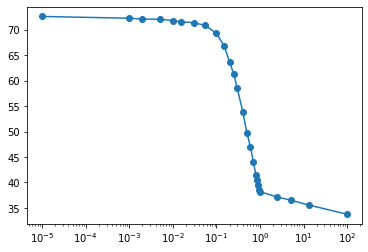

In [ ]:
### CTAB ###
CTAB_ST=([72.6, 72.24748707, 72.08796206, 72.04127631, 71.80186884, 71.57607958, 71.35932355, 70.8470728, 69.25175673, 66.79325079, 63.6671448, 61.24273577, 58.4542436, 53.92384763, 49.66474623, 47.01343426, 44.0721636, 41.48171948, 40.43714693, 39.55888282, 38.52510061, 38.1868, 37.11413874, 36.52017359, 35.55603202, 33.77246603]) 
CTAB_conc=([0.00001, 0.00100, 0.00200, 0.00500, 0.01000, 0.01500, 0.03000, 0.05500, 0.10000, 0.15000, 0.20000, 0.25000, 0.30000, 0.40000, 0.50000, 0.60000, 0.70000, 0.80000, 0.85000, 0.90000, 0.95000, 1.00000, 2.50000, 5.00000, 13.15224, 96.30951]) 

plt.figure()
plt.semilogx(CTAB_conc, CTAB_ST, '-o')


In [ ]:
file=fileCTAB12
CTAB_conc_t0=0.4


interpST=log_interp1d(CTAB_conc,CTAB_ST, kind='slinear')
ST_check=interpST(file.iloc[:, 910].values)
file.iloc[:, 912]=ST_check

# values_to_save=str('CTAB_conci_%.5f_all.csv' %CTAB_conc_t0)
# final_values=open(values_to_save, 'a')
# np.savetxt(values_to_save, file, delimiter="\t")
# final_values.close()


#### Define input

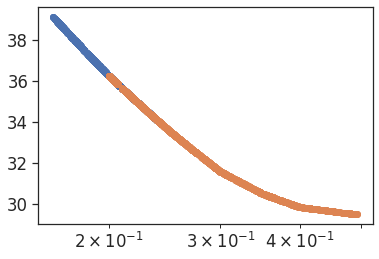

In [ ]:
plt.figure()
# plt.plot(fileTrit1.iloc[:, 363])
# plt.plot(fileTrit2.iloc[:, 363])
# plt.plot(fileTrit3.iloc[:, 363])
# plt.plot(fileTrit4.iloc[:, 363])
# plt.plot(fileTrit5.iloc[:, 363])
# plt.plot(fileTrit5.iloc[:, 363])
# plt.plot(fileTrit7.iloc[:, 363])
# plt.plot(fileTrit9.iloc[:, 363])
# # plt.plot(fileTrit15.iloc[:, 363])
plt.semilogx(fileTrit13.iloc[2000:3000, 362], fileTrit13.iloc[2000:3000, 363], 'o')
plt.semilogx(fileTrit15.iloc[0:1650, 362], fileTrit15.iloc[0:1650, 363], 'o')
# plt.semilogx(fileTrit17.iloc[1000:1700, 362], fileTrit17.iloc[1000:1700, 363], 'o')
# plt.semilogx(fileTrit18.iloc[1100:1300, 362], fileTrit18.iloc[1100:1300, 363], 'o')
# plt.semilogx(fileTrit19.iloc[400:700, 362], fileTrit19.iloc[400:700, 363], 'o')# plt.semilogx(fileTrit20.iloc[0:200, 362], fileTrit20.iloc[0:200, 363], 'o')
# plt.semilogx(fileTrit21.iloc[0:200, 362], fileTrit21.iloc[0:200, 363], 'o')
# plt.semilogx(fileTrit22.iloc[0:200, 362], fileTrit22.iloc[0:200, 363], 'o')

# plt.plot(fileCTAB7.iloc[:, 363])
# plt.plot(fileCTAB8.iloc[:, 363])
# plt.plot(fileCTAB12.iloc[:, 363])
# plt.plot(fileCTAB13.iloc[:, 363])
# plt.plot(fileCTAB14.iloc[0:1000, 363])
# plt.plot(fileCTAB15.iloc[2560:3200, 363])
# plt.semilogx(fileCTAB14.iloc[1600:3000, 362], fileCTAB14.iloc[1600:3000, 363], 'o')
# plt.semilogx(fileCTAB14.iloc[3195:4650, 362], fileCTAB14.iloc[3195:4650, 363], 'o')
# plt.semilogx(fileCTAB17.iloc[700:1500, 362], fileCTAB17.iloc[700:1500, 363], 'o')
# plt.semilogx(fileCTAB19.iloc[1300:1500, 362], fileCTAB19.iloc[1300:1500, 363], 'o')
# plt.semilogx(fileCTAB20.iloc[0:100, 362], fileCTAB20.iloc[0:200, 363], 'o')
# plt.semilogx(fileCTAB21.iloc[0:200, 362], fileCTAB21.iloc[0:200, 363], 'o')

# plt.plot(fileSDS8.iloc[:, 363])
# plt.plot(fileSDS9.iloc[:, 363])
# plt.plot(fileSDS10.iloc[:, 363])
# plt.semilogx(fileSDS17.iloc[0:4705, 362], fileSDS17.iloc[0:4705, 363], 'o')
# plt.semilogx(fileSDS18.iloc[:, 362], fileSDS18.iloc[:, 363], 'o')
# plt.semilogx(fileSDS19.iloc[:, 362], fileSDS19.iloc[:, 363], 'o')
# plt.semilogx(fileSDS20.iloc[800:1200, 362], fileSDS20.iloc[800:1200, 363], 'o')
# plt.semilogx(fileSDS21.iloc[0:300, 362], fileSDS21.iloc[0:300, 363], 'o')


In [7]:

# input=np.vstack([ fileCTAB8,fileCTAB9.iloc[0:1670,:],
#                  fileCTAB9.iloc[:3338, :], fileCTAB10.iloc[1000:, :], fileCTAB11, fileCTAB12, fileCTAB13, fileCTAB14, fileCTAB15, 
#                  fileCTAB16.iloc[:2950,:], fileCTAB16.iloc[3292:,:]])


########## CTAB ###############
# input=np.vstack([fileCTAB3.iloc[0:500, :], fileCTAB5.iloc[0:500, :], fileCTAB6.iloc[0:2500, :], fileCTAB7, fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB11, fileCTAB12, fileCTAB13, fileCTAB14.iloc[0:3000], fileCTAB15.iloc[0:1673], fileCTAB15.iloc[2600:2800]])

# input=np.vstack([fileCTAB7.iloc[0:1675, :], fileCTAB7.iloc[3359:, :],  fileCTAB8.iloc[0:1634:, :], fileCTAB8.iloc[3301:, :], fileCTAB9.iloc[0:1670,:], 
#                  fileCTAB9.iloc[3338:,:], fileCTAB10.iloc[1698:, :], fileCTAB11.iloc[1677:,:], fileCTAB12, fileCTAB13.iloc[1673:, :],
#                  fileCTAB14.iloc[0:1100, :], fileCTAB14.iloc[1600:3000, :], fileCTAB14.iloc[3195:4650, :]])
# #                  #fileCTAB15.iloc[0:750, :], fileCTAB17.iloc[0:1646, :]]) #fileCTAB14.iloc[1600:3000, :], fileCTAB14.iloc[3195:4650, :], 
# #                  #fileCTAB16.iloc[1674:4967, :], fileCTAB20.iloc[0:1653, :], fileCTAB21.iloc[0:1659, :]

########## SDS ###############
# input=np.vstack([fileSDS7.iloc[3515:,:], fileSDS8.iloc[1763:, :], fileSDS9, fileSDS10,  fileSDS11, fileSDS12, fileSDS13, 
#                  fileSDS14, fileSDS15, fileSDS16.iloc[:4950,:],
#                  fileSDS17.iloc[0:1400, :], fileSDS17.iloc[1719:3160, :], fileSDS17.iloc[3395:,:], fileSDS18.iloc[0:1000,:], fileSDS18.iloc[1677:2715,:], fileSDS18.iloc[3328:4190,:]])

#fileSDS15.iloc[0:1300, :], fileSDS15.iloc[1700:2900, :], fileSDS15.iloc[3445:4500, :],  fileSDS16.iloc[1730:2750,:], fileSDS16.iloc[3450:4150,:],fileSDS14.iloc[50:3000, :],fileSDS12.iloc[0:3404, :],fileSDS11.iloc[1740:, :]
                #  fileSDS14.iloc[3400:4800, :],  fileSDS10.iloc[0:1728, :], fileSDS10.iloc[3471:, :],

########## TX100 ###############
# input=np.vstack([ fileTrit5, fileTrit7,fileTrit8, fileTrit9, fileTrit10, fileTrit11, fileTrit13, fileTrit15])

#fileTrit5, fileTrit6.iloc[1689:, :],fileTrit7.iloc[0:2400, :], fileTrit7.iloc[2500:3200, :], fileTrit7.iloc[3500:, :], fileTrit8.iloc[1750:,:], 

########## Combination ###############
input_SDS=np.vstack([fileSDS8.iloc[0:1600, :], fileSDS10.iloc[0:2500, :], fileSDS12.iloc[0:3500, :], fileSDS14.iloc[0:3500, :], fileSDS17.iloc[0:4705, :], fileSDS20.iloc[800:1200,:]])
input_SDS=np.hstack([input_SDS, np.reshape(np.repeat(0, len(input_SDS)), (len(input_SDS), 1))])


input_CTAB=np.vstack([fileCTAB7.iloc[0:1600, :], fileCTAB8.iloc[500:1633, :], fileCTAB8.iloc[3700:, :], fileCTAB9.iloc[0:1670,:], 
                 fileCTAB10.iloc[1698:, :], fileCTAB11.iloc[1677:,:], fileCTAB12.iloc[0:2000, :], fileCTAB13.iloc[1673:, :],
                  fileCTAB14.iloc[3195:4650, :], fileCTAB17.iloc[700:1500, :], fileCTAB19.iloc[1300:1500, :]])

input_CTAB=np.hstack([input_CTAB, np.reshape(np.repeat(1, len(input_CTAB)), (len(input_CTAB), 1))])


input_TX100=np.vstack([fileTrit5.iloc[0:1600, :], fileTrit7.iloc[0:1500, :], fileTrit9.iloc[0:1632,:],fileTrit9.iloc[3295:, :], fileTrit10.iloc[0:1200,:], fileTrit11.iloc[0:2000,:],
                 fileTrit12.iloc[0:2300,:], fileTrit13.iloc[1000:3000, :], fileTrit14.iloc[500:3000, :], fileTrit15.iloc[0:4600, :], fileTrit17.iloc[1000:1600, :],fileTrit18.iloc[1100:1300,:], fileTrit19.iloc[400:500,:] ])

input_TX100=np.hstack([input_TX100, np.reshape(np.repeat(2, len(input_TX100)), (len(input_TX100), 1))])





input=np.vstack([input_SDS, input_CTAB, input_TX100])

#fileSDS7.iloc[3515:,:], fileSDS8.iloc[1763:, :], fileTrit7.iloc[0:3290, :],  fileTrit14.iloc[3308:,:], fileTrit13.iloc[0:3000, :], fileSDS17.iloc[1719:3160, :], fileCTAB14.iloc[0:1100, :], 


# 
# fileSDS9_n=fileSDS9[fileSDS9.iloc[:, 912]>65]

# input=np.vstack([fileSDS8.iloc[1763:, :], fileSDS9_n, fileTrit11.iloc[0:3000,:], fileTrit12.iloc[0:2300,:], fileTrit13.iloc[0:3000, :], fileTrit14.iloc[3308:,:], fileTrit15.iloc[0:4600, :],
#                  fileCTAB7.iloc[0:1675, :], fileCTAB7.iloc[3359:, :],  fileCTAB8.iloc[0:1634:, :], fileCTAB8.iloc[3301:, :], fileCTAB9.iloc[0:1670,:], 
#                  fileCTAB9.iloc[3338:,:], fileCTAB10.iloc[1698], fileCTAB11.iloc[1677:,:], fileCTAB12, fileCTAB13.iloc[1673:, :]])

In [ ]:
# lim1=0  #1674
# lim2=4600

# lim3=1730
# lim4=2750
# lim5=3450
# lim6=4150

# plt.figure()
# # plt.plot(fileCTAB14.iloc[lim1:lim2, 912]) #, fileCTAB15.iloc[lim1:lim2, 911]
# plt.plot(fileTrit15.iloc[lim1:lim2, 912]) #, fileCTAB15.iloc[lim1:lim2, 911]
# # plt.plot(fileSDS16.iloc[lim1:lim2, 912]+2.4) #, fileCTAB16.iloc[lim1:lim2, 911]
# # plt.plot(fileSDS16.iloc[lim3:lim4, 912]+2.4) #, fileCTAB16.iloc[lim1:lim2, 911]
# # plt.plot(fileSDS16.iloc[lim5:lim6, 912]+2.4) #, fileCTAB16.iloc[lim1:lim2, 911]
# # plt.ylim(37, 42)

#### Numbered datasets

In [ ]:
# path=str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/numbered_files/')

# fileCTAB7=pd.read_csv(str(path+'CTAB07.csv'), sep=";")
# fileCTAB8=pd.read_csv(str(path+'CTAB08.csv'), sep=";")
# fileCTAB9=pd.read_csv(str(path+'CTAB09.csv'), sep=";")
# fileCTAB10=pd.read_csv(str(path+'CTAB10.csv'), sep=";")
# fileCTAB11=pd.read_csv(str(path+'CTAB11.csv'), sep=";")
# fileCTAB12=pd.read_csv(str(path+'CTAB12.csv'), sep=";")
# fileCTAB13=pd.read_csv(str(path+'CTAB13.csv'), sep=";")
# fileCTAB14=pd.read_csv(str(path+'CTAB14.csv'), sep=";")
# fileCTAB15=pd.read_csv(str(path+'CTAB15.csv'), sep=";")


# input=pd.concat([fileCTAB7, fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB13, fileCTAB14, fileCTAB15])
# input=input.reset_index()
# dataset=input.iloc[:, 2:]
# dataset.tail()

# # input=fileCTAB15
# # dataset=input.iloc[:, 1:]
# # dataset.tail()

In [ ]:
input=pd.concat([fileCTAB7, fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB13, fileCTAB14, fileCTAB15])
input=input.reset_index()
dataset=input.iloc[:, 2:]
dataset.tail()

##### Numbered with corrected relevant centres

In [ ]:
# path=str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/numbered_files/Relevant_centres/')

# # fileCTAB7=pd.read_csv(str(path+'CTAB07_rel_centres.csv'))
# # fileCTAB8=pd.read_csv(str(path+'CTAB08_rel_centres.csv'))
# fileCTAB9=pd.read_csv(str(path+'CTAB09_rel_centres.csv'))
# fileCTAB10=pd.read_csv(str(path+'CTAB10_rel_centres.csv'))
# # fileCTAB11=pd.read_csv(str(path+'CTAB11_rel_centres.csv'))
# # fileCTAB12=pd.read_csv(str(path+'CTAB12_rel_centres.csv'))
# fileCTAB13=pd.read_csv(str(path+'CTAB13_rel_centres.csv'))
# fileCTAB14=pd.read_csv(str(path+'CTAB14_rel_centres.csv'))
# # fileCTAB15=pd.read_csv(str(path+'CTAB15_rel_centres.csv'))


# input=pd.concat([fileCTAB9, fileCTAB10, fileCTAB13, fileCTAB14])
# input=input.reset_index()
# dataset=input.iloc[:, 2:]

# dataset.pop('R_sph')
# dataset.pop('drop')
# dataset.pop('height')
# dataset.pop('width')
# dataset.pop('Intensity')
# dataset.pop('time')
# dataset.pop('Power')
# dataset.pop('surfactant_conc')

# for i in range(300):
#   dataset.pop('phi_%d' %i)

# dataset.tail()

# # input=fileCTAB15
# # dataset=input.iloc[:, 1:]
# # dataset.tail()

rho_0     rho_1     rho_2  ...  centre_y  Aspect_Ratio         ST
19966  0.822386  0.823070  0.823239  ... -0.131390      1.319018  38.500904
19967  0.822386  0.823070  0.823239  ... -0.131390      1.319018  38.499712
19968  0.822573  0.822786  0.822919  ... -0.142865      1.319018  38.503163
19969  0.816622  0.817186  0.817338  ... -0.123740      1.301829  38.493602
19970  0.816649  0.817338  0.817508  ... -0.116090      1.301829  38.491487

[5 rows x 606 columns]

##### Correcting for relevant centres

In [ ]:
dataset=input.iloc[:, 1:]
dataset.tail()

rho_0     rho_1     rho_2  ...  Aspect_Ratio         ST  drop
5009  0.728764  0.728844  0.730207  ...      1.249180  38.072642     3
5010  0.726980  0.728176  0.728427  ...      1.256579  38.069926     3
5011  0.730756  0.731876  0.732116  ...      1.260726  38.071487     3
5012  0.734580  0.734679  0.731276  ...      1.267327  38.078337     3
5013  0.732468  0.732488  0.729546  ...      1.264026  38.073660     3

[5 rows x 914 columns]

In [ ]:
#Centre coordinates per drop


for i in range(1, 4):
  rslt_df = dataset.loc[dataset['drop'] == i]

  mean_centre_x=np.mean(rslt_df.centre_x)
  mean_centre_y=np.mean(rslt_df.centre_y)

  rel_centre_x=dataset.centre_x-mean_centre_x
  rel_centre_y=dataset.centre_y-mean_centre_y

  dataset['centre_x']=rel_centre_x
  dataset['centre_y']=rel_centre_y



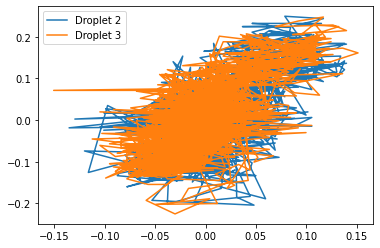

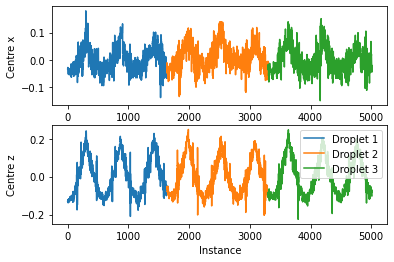

In [ ]:
lim1=1634
lim2=3301

plt.figure()
# plt.plot(dataset.centre_x[0:lim1], dataset.centre_y[0:lim1], label='Droplet 1')
plt.plot(dataset.centre_x[lim1:lim2], dataset.centre_y[lim1:lim2], label='Droplet 2')
plt.plot(dataset.centre_x[lim2:], dataset.centre_y[lim2:], label='Droplet 3')
plt.legend()

plt.figure()
plt.subplot(211)
plt.plot(dataset.centre_x[0:lim1], label='Droplet 1')
plt.plot(dataset.centre_x[lim1:lim2], label='Droplet 2')
plt.plot(dataset.centre_x[lim2:], label='Droplet 3')
plt.ylabel('Centre x')
plt.subplot(212)
plt.plot(dataset.centre_y[0:lim1], label='Droplet 1')
plt.plot(dataset.centre_y[lim1:lim2], label='Droplet 2')
plt.plot(dataset.centre_y[lim2:], label='Droplet 3')
plt.ylabel('Centre z')
plt.xlabel('Instance')
plt.legend()

In [ ]:
path=str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/numbered_files/Relevant_centres/')


dataset.to_csv(path+'CTAB15_rel_centres.csv')

#### Clean dataset

In [ ]:
# path=str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/Clean_files/')

# # fileCTAB7=pd.read_csv(str(path+'CTAB7_clean.csv'), sep=";")
# # fileCTAB8=pd.read_csv(str(path+'CTAB8_clean_drops1_3.csv'), sep=";")
# fileCTAB9=pd.read_csv(str(path+'CTAB9_clean_drops_1_3.csv'), sep=";")
# fileCTAB10=pd.read_csv(str(path+'CTAB10_clean_drops_2_3.csv'), sep=";")
# fileCTAB12=pd.read_csv(str(path+'meh_CTAB12_clean_drops_2_3.csv'), sep=";")
# fileCTAB13=pd.read_csv(str(path+'meh_but_better_CTAB13_clean_drops_1_2.csv'), sep=";")
# fileCTAB14=pd.read_csv(str(path+'meh_but_ok_CTAB14_clean_drops_2_3.csv'), sep=";")
# fileCTAB15=pd.read_csv(str(path+'CTAB15_clean_drops_1_2.csv'), sep=";")

# input=pd.concat([fileCTAB9, fileCTAB10, fileCTAB13, fileCTAB14])
# input=input.reset_index()
# dataset=input.iloc[:, 2:]
# dataset.tail()

In [ ]:
# input=np.vstack([fileCTAB9, fileCTAB10,fileCTAB13, fileCTAB14]) #, fileCTAB12, fileCTAB13, fileCTAB14

# # input=np.vstack([fileTrit13, fileTrit14, fileTrit15, fileTrit16, fileTrit17, fileTrit18,
# #                  fileTrit19, fileTrit20, fileTrit21])

# # input=fileCTAB11
# # raw_dataset.pop('drop')

#### C

In [8]:
column_names=[]
for i in range(175):
  column_names.append('rho_%d' %i)
for i in range(175):
  column_names.append('phi_%d' %i)
# for i in range(175):
#   column_names.append('theta_%d' %i)
column_names.append('height') #350  #525  900
column_names.append('width')  #351  #526  901
column_names.append('volume') #352  #527 902
column_names.append('R_sph')  #353  #528  903
column_names.append('centre_x') #354  #529  908
column_names.append('centre_z') #355  #530  909
column_names.append('Aspect_Ratio') #356  #531  911
column_names.append('volt') #357  #532   904
column_names.append('current') #358  #533  905
column_names.append('time') #359  #534  906
column_names.append('Power') #360  #535  907
column_names.append('centred_z') #361 

column_names.append('surfactant_conc') #362   #536 910


#column_names.append('Ps')
#column_names.append('Ps_err')

column_names.append('ST') #362   #537  912


column_names.append('surf_number')



In [ ]:
input.shape

(58369, 365)

In [9]:
if len(input)<=6000:
  ### For one file
  raw_dataset = input
  raw_dataset.columns=column_names
else:
  ### For multiple files
  raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              
raw_dataset.shape

dataset = raw_dataset.copy()

# dataset.centre_z=-dataset.centre_z
# dataset.Aspect_Ratio=1/dataset.Aspect_Ratio


dataset.tail()

#We keep: volume	Power	centre_z	Aspect_Ratio	st

rho_0     rho_1     rho_2     rho_3     rho_4     rho_5     rho_6  \
58364  0.752019  0.753423  0.751969  0.748898  0.748090  0.745630  0.743755   
58365  0.751976  0.753333  0.751833  0.747438  0.747859  0.745252  0.741373   
58366  0.750053  0.751397  0.749880  0.748385  0.745866  0.743335  0.741739   
58367  0.750083  0.747624  0.746127  0.745592  0.744952  0.743258  0.739445   
58368  0.750165  0.751629  0.750232  0.749803  0.746460  0.744051  0.741164   

          rho_7     rho_8     rho_9  ...  centre_z  Aspect_Ratio  volt  \
58364  0.739546  0.736226  0.732583  ... -1.723111      1.267742   8.4   
58365  0.738592  0.735435  0.732574  ... -1.719286      1.267742   8.4   
58366  0.737198  0.733329  0.730433  ... -1.707811      1.264516   8.4   
58367  0.736726  0.733616  0.728434  ... -1.723111      1.264516   8.4   
58368  0.738500  0.734412  0.731644  ... -1.711636      1.264516   8.4   

       current        time   Power  centred_z  surfactant_conc         ST  \
58364    0.329  336.572123  2.7636   0.034708         1.328075  29.025006   
58365    0.329  336.924186  2.7636   0.038533         1.327757  29.025040   
58366    0.329  337.252187  2.7636   0.050008         1.330955  29.024693   
58367    0.329  337.580186  2.7636   0.034708         1.332096  29.024570   
58368    0.329  337.908188  2.7636   0.046183         1.334349  29.024326   

       surf_number  
58364          2.0  
58365          2.0  
58366          2.0  
58367          2.0  
58368          2.0  

[5 rows x 365 columns]

In [ ]:
#Correcting ST for calibration
# dataset.ST=dataset.ST+1.2 #For CTAB
# dataset.ST=dataset.ST+2.4 #For SDS


#### Centrering for vertical position

Text(0.5, 0, 'Instance')

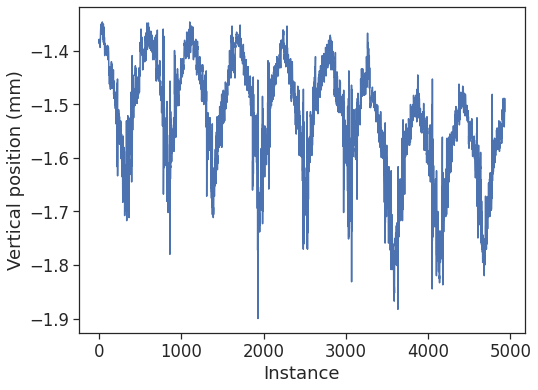

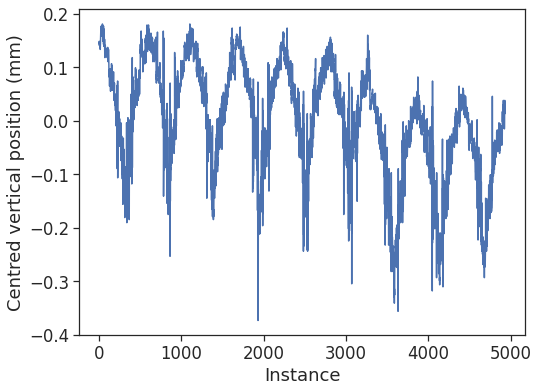

In [ ]:
mean_z=np.mean(fileTrit7.iloc[:, 355])

plt.figure(figsize=(8,6))
plt.plot(fileTrit7.iloc[:, 355])
plt.ylabel('Vertical position (mm)')
plt.xlabel('Instance')

plt.figure(figsize=(8,6))
plt.plot(fileTrit7.iloc[:, 355]-mean_z)
plt.ylabel('Centred vertical position (mm)')
plt.xlabel('Instance')


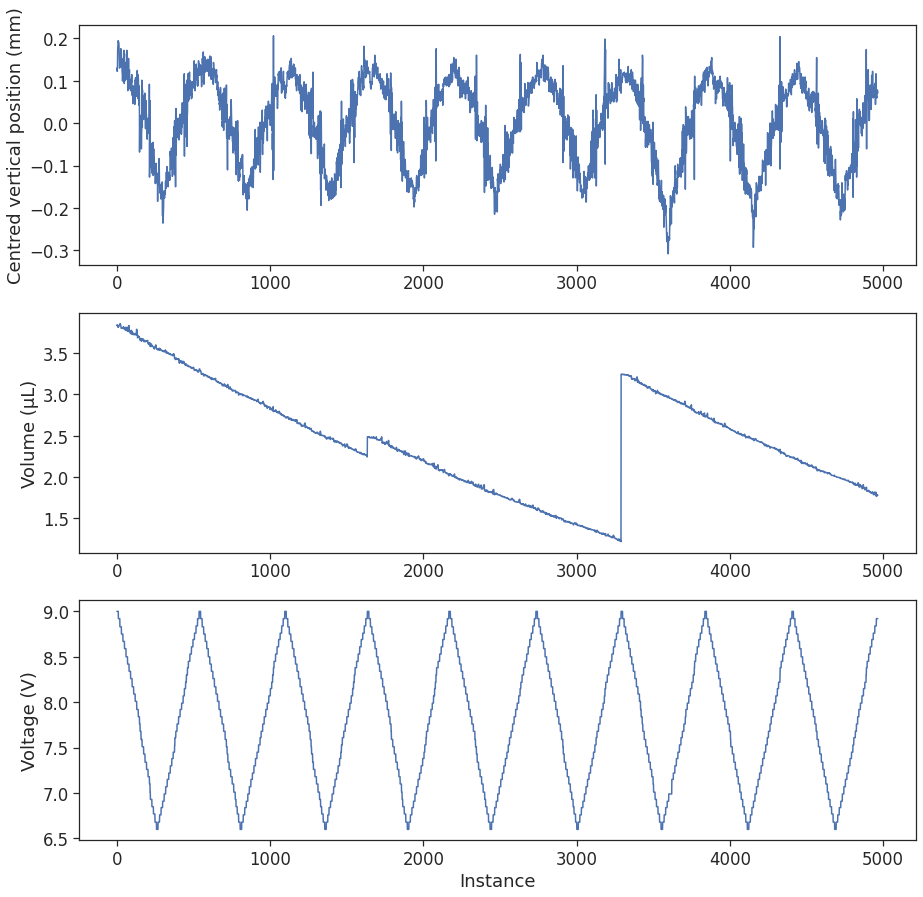

In [ ]:
mean_z=np.mean(fileCTAB16.iloc[:, 355])


plt.figure(figsize=(15,15))
plt.subplot(311)
plt.ylabel('Centred vertical position (mm)')
plt.plot(fileCTAB16.iloc[:, 355]-mean_z) #/(fileCTAB16.iloc[0:250, 357]*fileCTAB16.iloc[0:250, 358]))
plt.subplot(312)
plt.plot(fileCTAB16.iloc[:, 352])
plt.ylabel('Volume (μL)')
plt.subplot(313)
plt.plot(fileCTAB16.iloc[:, 357])
plt.ylabel('Voltage (V)')
plt.xlabel('Instance')

fileCTAB16.iloc[:, 356]=fileCTAB16.iloc[:, 356]-mean_z


In [ ]:
z_position=[]

# input=np.vstack([fileSDS7.iloc[3515:,:], fileSDS8.iloc[1763:, :],  fileSDS12, fileSDS14, fileSDS17.iloc[0:1450, :], 
#                  fileSDS17.iloc[1719:3160, :], fileSDS17.iloc[3450:4705, :], fileCTAB8.iloc[500:1633, :], fileCTAB8.iloc[3700:, :], fileCTAB9.iloc[0:1670,:], 
#                  fileCTAB9.iloc[3338:,:], fileCTAB10.iloc[1698:, :], fileCTAB11.iloc[1677:,:], fileCTAB12, fileCTAB13.iloc[1673:, :],
#                  fileCTAB14.iloc[0:1100, :], fileCTAB14.iloc[1600:3000, :], fileCTAB14.iloc[3195:4650, :], 
#                  fileTrit9.iloc[0:1632,:],fileTrit9.iloc[3295:, :], fileTrit10.iloc[0:1200,:], fileTrit11.iloc[0:3000,:], 
#                  fileTrit12.iloc[0:2300,:], fileTrit13.iloc[0:3000, :], fileTrit14.iloc[3308:,:], fileTrit15.iloc[0:4600, :]])

#len(fileSDS7.iloc[3515:,:]), len(fileSDS8.iloc[1763:, :]),

#TritonX-100
# input_len=np.array([len(fileTrit7.iloc[0:3290, :]), len(fileTrit9.iloc[0:1632,:]),len(fileTrit9.iloc[3295:, :]), len(fileTrit10.iloc[0:1200,:]), len(fileTrit11.iloc[0:3000,:]), len(fileTrit12.iloc[0:2300,:]), len(fileTrit13.iloc[0:3000, :]), len(fileTrit14.iloc[3308:,:]), len(fileTrit15.iloc[0:4600, :])])
# input_len=np.array([len(fileTrit3), len(fileTrit4), len(fileTrit5), len(fileTrit7), len(fileTrit9), len(fileTrit10), len(fileTrit11), len(fileTrit13), len(fileTrit15)])


# #Combination
# input_len=np.array([len(fileSDS10), len(fileSDS12), len(fileSDS14), len(fileSDS17.iloc[0:1450, :]), 
#                  len(fileSDS17.iloc[1719:3160, :]), len(fileSDS17.iloc[3450:4705, :]), len(fileCTAB8.iloc[500:1633, :]), len(fileCTAB8.iloc[3700:, :]), len(fileCTAB9.iloc[0:1670,:]), 
#                  len(fileCTAB9.iloc[3338:,:]), len(fileCTAB10.iloc[1698:, :]), len(fileCTAB11.iloc[1677:,:]), len(fileCTAB12), len(fileCTAB13.iloc[1673:, :]),
#                  len(fileCTAB14.iloc[0:1100, :]), len(fileCTAB14.iloc[1600:3000, :]), len(fileCTAB14.iloc[3195:4650, :]), 
#                  len(fileTrit9.iloc[0:1632,:]), len(fileTrit9.iloc[3295:, :]), len(fileTrit10.iloc[0:1200,:]), len(fileTrit11.iloc[0:3000,:]),
#                 len(fileTrit12.iloc[0:2300,:]), len(fileTrit13.iloc[0:3000, :]), len(fileTrit14.iloc[3308:,:]), len(fileTrit15.iloc[0:4600, :])])

#len(fileSDS7.iloc[3515:,:]), len(fileSDS8.iloc[1763:, :]), len(fileTrit7.iloc[0:3290]),

j=0
for i in range(len(input_len)):
  z_position.append(dataset.centre_z[j:j+input_len[i]]-np.mean(dataset.centre_z[j:j+input_len[i]]))
  j=j+input_len[i]



Text(0, 0.5, 'Centered vertical position (mm)')

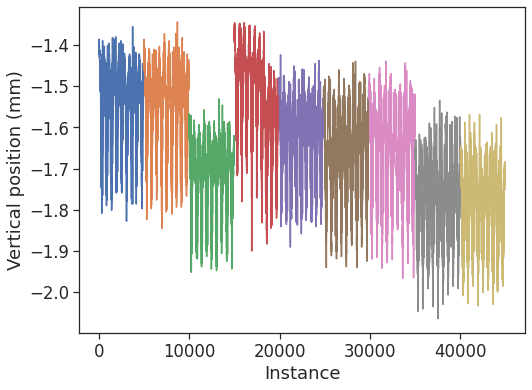

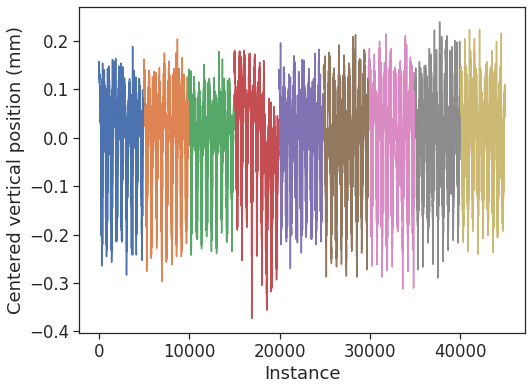

In [ ]:
### Original vertical position ###

sns.set_theme(style='ticks', font_scale=1.5)
j=0
plt.figure(figsize=(8,6))
for i in range(len(input_len)):
  plt.plot(dataset.centre_z[j:j+input_len[i]])
  j=j+input_len[i]
plt.xlabel('Instance')
plt.ylabel('Vertical position (mm)')

### Centred vertical position ###
plt.figure(figsize=(8,6))
for i in range(len(input_len)):
  plt.plot(z_position[i])
plt.xlabel('Instance')
plt.ylabel('Centered vertical position (mm)')



In [ ]:
flat_list = []
for sublist in z_position:
    for item in sublist:
        flat_list.append(item)

dataset.centre_z=flat_list

#### Check voltage, position

Text(0, 0.5, 'Vertical position/Volume)')

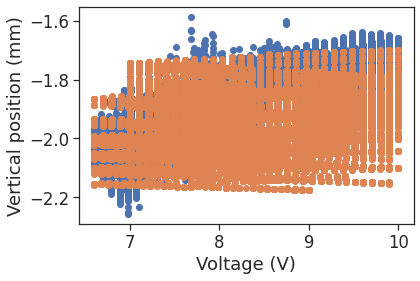

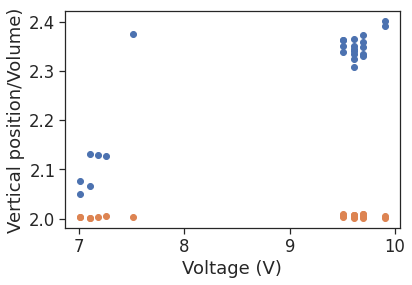

In [ ]:
plt.figure()
plt.plot(raw_dataset.volt,raw_dataset.centre_y, 'o' )
plt.xlabel('Voltage (V)')
plt.ylabel('Vertical position (mm)')
plt.plot(raw_dataset.volt, (raw_dataset.volume-4)*0.1-1.9, 'o')
# plt.xlim(6.5, 7.5)

# plt.figure()
# plt.plot(raw_dataset.time/60,raw_dataset.centre_y, 'o')
# plt.xlabel('Time (min)')
# plt.ylabel('Vertical position (mm)')
# # plt.xlim(6.5, 7.5)

#Proportional to the volume and upper limit for vertical position. It reaches it assymptotically: x/(1+x) or log(1+x)/(1+log(1+x))
vol1=raw_dataset[(raw_dataset.volume>1.5) & (raw_dataset.volume<1.51)]


plt.figure()
plt.plot(vol1.volt, (vol1.centre_y)/(1+vol1.centre_y), 'o' ) #((vol1.volume-4)*0.1-2)
plt.plot(vol1.volt, vol1.volume+0.5, 'o' )
plt.xlabel('Voltage (V)')
plt.ylabel('Vertical position/Volume)')

Estimated value of a : -1.0339107427316134
Estimated value of b : -0.3961898894328097


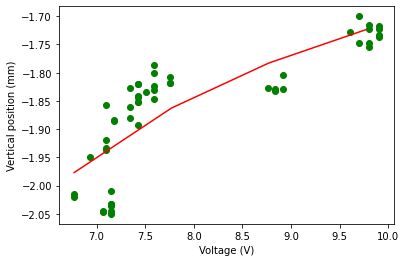

In [ ]:
from scipy import optimize

def function(x, a, b):
    return (a*np.log10(x))/(b+np.log10(x)) #np.log10(x)

vol1=raw_dataset[(raw_dataset.volume>1.49) & (raw_dataset.volume<1.50)]

x = vol1.volt
y = vol1.centre_y


popt,cov = scipy.optimize.curve_fit(function, x, y)

a,b = popt

x_new_value = np.arange(min(x), max(x), 1)
y_new_value = function(x_new_value, a, b)

plt.scatter(x,y,color="green")
plt.plot(x_new_value,y_new_value,color="red")
plt.xlabel('Voltage (V)')
plt.ylabel('Vertical position (mm)')
print("Estimated value of a : "+ str(a))
print("Estimated value of b : " + str(b))
plt.show()

#### Clear up data

In [ ]:
len(indexArr)

2824

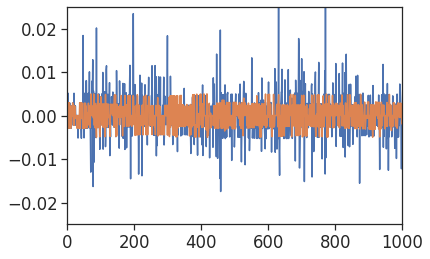

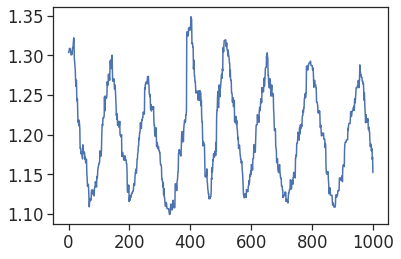

In [ ]:
###### Clear up data based on aspect ratio ######

AR=dataset.Aspect_Ratio.copy()


diff_AR=[]
for i in range(len(dataset)-1):
    diff_AR.append(abs(AR[i])-abs(AR[i+1]))

diff_AR=np.asarray(diff_AR)


indexArr = np.argwhere(abs(diff_AR) >= 0.0005)
diff_AR_cond=diff_AR[abs(diff_AR)<0.005]

AR=np.asarray(AR)
new_AR=np.delete(AR, indexArr, axis=0)

plt.figure()
plt.plot(diff_AR)
plt.plot(diff_AR_cond)
plt.ylim(-0.025, 0.025)
plt.xlim(0,1000)



plt.figure()
plt.plot(new_AR[0:1000])





#### Data distribution

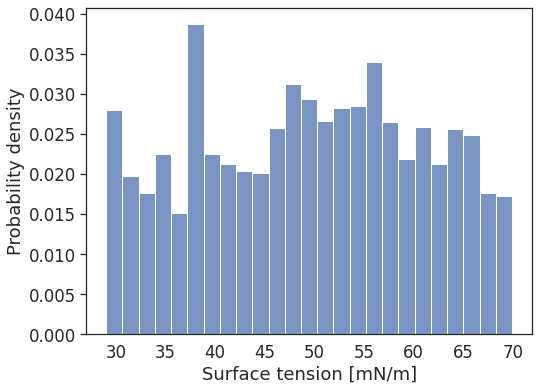

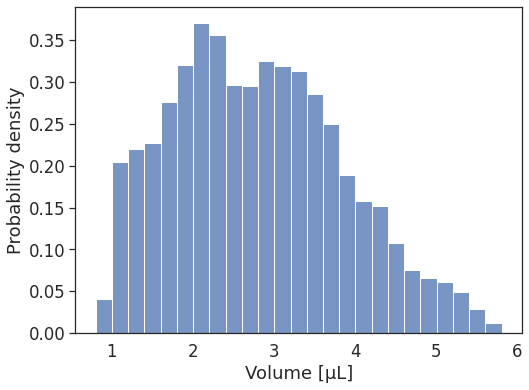

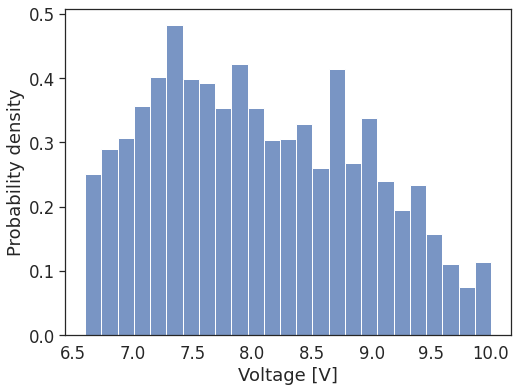

In [ ]:
sns.set_theme(style='ticks', font_scale=1.5)

savefig=False
path='/content/drive/My Drive/DropLev/for_draft/Experimental/Figures/'

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(dataset.loc[:, 'ST'], kde=False, bins=25, stat="density")
plt.xlabel('Surface tension [mN/m]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'exp_data_distr_ST_svg', dpi=300, format='svg')
  plt.savefig(path+'exp_data_distr_ST_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(dataset.loc[:, 'volume'], kde=False, bins=25, stat="density")
plt.xlabel('Volume [μL]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'exp_data_distr_Volume_svg', dpi=300, format='svg')
  plt.savefig(path+'exp_data_distr_Volume_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(dataset.loc[:, 'volt'], kde=False, bins=25, stat="density")
plt.xlabel('Voltage [V]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'exp_data_distr_Voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'exp_data_distr_Voltage_png', dpi=300, format='png')



### Conditions

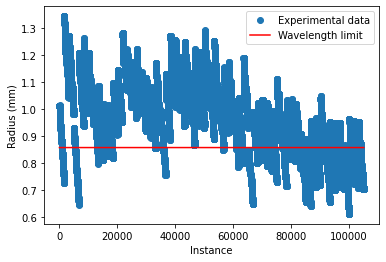

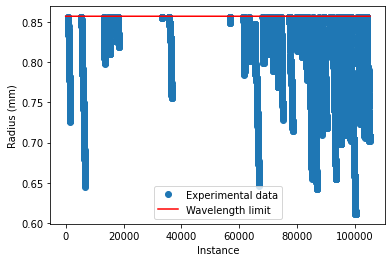

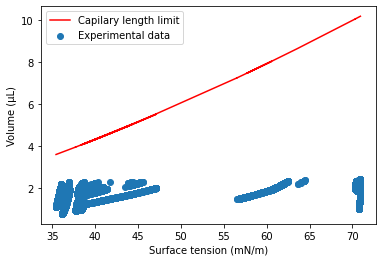

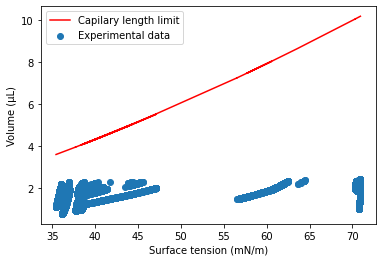

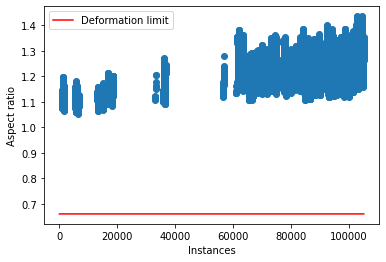

In [ ]:
# # radius < 1/10 of operating wavelegth 40 kHz
# sns.set_theme(style='white', font_scale=1.5)

# wavelength_lim = 343 / 40 # [mm] 
# radius=dataset.width/2

# raw_dataset['radius']=radius

# plt.figure()
# plt.plot(radius, 'ob', markersize=5, label='Experimental data')
# plt.plot(range(len(raw_dataset)), np.repeat(wavelength_lim*0.1, len(raw_dataset)), '--r', label='Wavelength limit')
# plt.xlabel('Instance')
# plt.ylabel('Radius (mm)')
# plt.legend()
# plt.savefig(path+'exp_wavelenght_after', dpi=300, format='svg')

# pre_rslt_dataset= raw_dataset[raw_dataset['radius'] < wavelength_lim*0.1]

# plt.figure()
# plt.plot(pre_rslt_dataset.radius, 'ob', markersize=5, label='Experimental data')
# plt.plot(range(len(raw_dataset)), np.repeat(wavelength_lim*0.1, len(raw_dataset)), '--r', label='Wavelength limit')
# plt.xlabel('Instance')
# plt.ylabel('Radius (mm)')
# plt.legend()

# # Capillary length check
# ST_c=np.linspace(min(pre_rslt_dataset), max(pre_rslt_dataset), len(pre_rslt_dataset))
# lambda_c=np.sqrt(ST_c/9.81)
# volume_c=(4/3)*np.pi*(lambda_c/2)**3

# rslt_dataset= pre_rslt_dataset[pre_rslt_dataset['volume'] <= volume_c*0.7]

# plt.figure()
# plt.plot(ST_c, volume_c, '--r', label='Capilary length limit')
# plt.plot(pre_rslt_dataset.ST, pre_rslt_dataset.volume, 'ob' markersize=5, label='Experimental data')
# plt.xlabel('Surface tension (mN/m)')
# plt.ylabel('Volume (μL)')
# plt.legend()

# plt.figure()
# plt.plot(ST_c, volume_c, '--r', label='Capilary length limit')
# plt.plot(rslt_dataset.ST, rslt_dataset.volume, 'ob', markersize=5, label='Experimental data')
# plt.xlabel('Surface tension (mN/m)')
# plt.ylabel('Volume (μL)')
# plt.legend()

# #Aspect ratio
# Ar_limit=0.66

# final_dataset= rslt_dataset[rslt_dataset['AR'] > Ar_limit]

# plt.figure()  
# plt.plot(rslt_dataset.Aspect_Ratio, 'ob', markersize=5)
# plt.plot(range(len(raw_dataset)), np.repeat(Ar_limit, len(raw_dataset)), '--r', label='Deformation limit')
# plt.xlabel('Instances')
# plt.ylabel('Aspect ratio')
# plt.legend()

# plt.figure()  
# plt.plot(final_dataset.Aspect_Ratio, 'ob', markersize=5)
# plt.plot(range(len(raw_dataset)), np.repeat(Ar_limit, len(raw_dataset)), '--r', label='Deformation limit')
# plt.xlabel('Instances')
# plt.ylabel('Aspect ratio')
# plt.legend()


In [ ]:
# final_dataset= rslt_dataset.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Probability density')

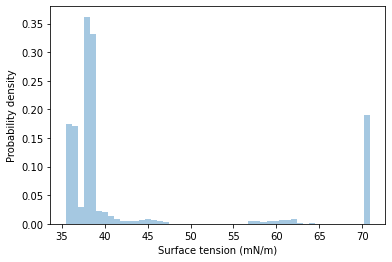

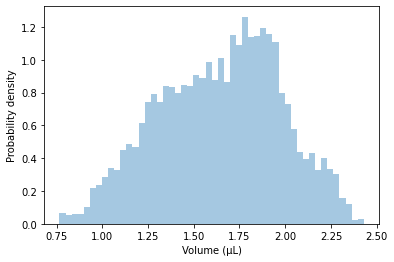

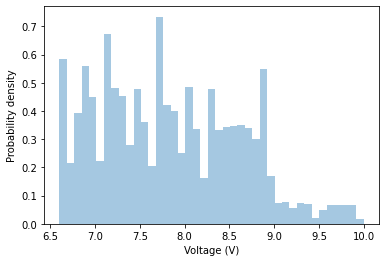

In [ ]:
#New data distribution
plt.figure()
sns.distplot(final_dataset.ST, norm_hist=True, kde=False)
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Probability density')

plt.figure()
sns.distplot(final_dataset.volume, norm_hist=True, kde=False)
plt.xlabel('Volume (μL)')
plt.ylabel('Probability density')

plt.figure()
sns.distplot(final_dataset.volt, norm_hist=True, kde=False)
plt.xlabel('Voltage (V)')
plt.ylabel('Probability density')

# fig, ax = plt.subplots()
# plt.xlabel('Cartesian y-axis (mm)')
# plt.ylabel('Cartesian z-axis (mm)')
# ax = plt.gca()
# ax.set_aspect(1)
# ax.set_xlim([-1.5,1.5])
# ax.set_ylim([-1.5,1.5])
# for j in range(len(dataset)):
#   try:
#     x,y=pol2cart_theta(np.asarray(final_dataset.iloc[j, sampling:sampling+sampling]), np.asarray(final_dataset.iloc[j, 0:sampling]))
#     plt.plot(x, y)
#   except:
#     j=j+1





#### More specific conditions and data analysis

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 0, 'Voltage [V]')

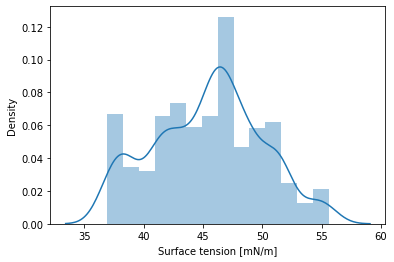

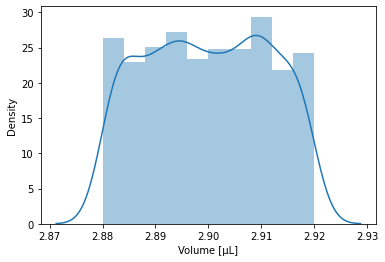

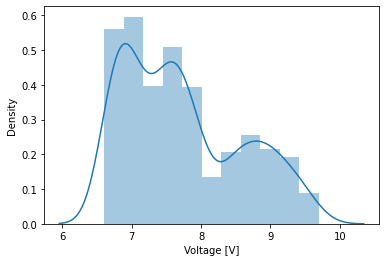

In [ ]:
dataset = dataset[(dataset['volume'] >= 2.88) & (dataset['volume'] <= 2.92)]

plt.figure()
plt.ylabel('Probability density')
sns.distplot(dataset.loc[:, 'ST'], kde=False)
plt.xlabel('Surface tension [mN/m]')

plt.figure()
plt.ylabel('Probability density')
sns.distplot(dataset.loc[:, 'volume'], kde=False)
plt.xlabel('Volume [μL]')

plt.figure()
plt.ylabel('Probability density')
sns.distplot(dataset.loc[:, 'volt'], kde=False)
plt.xlabel('Voltage [V]')



In [ ]:
dataset = dataset[(dataset['volt'] >= 6.98) & (dataset['volt'] <= 7.02)]


Text(0, 0.5, 'Volume (μL)')

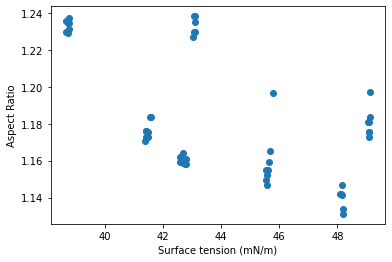

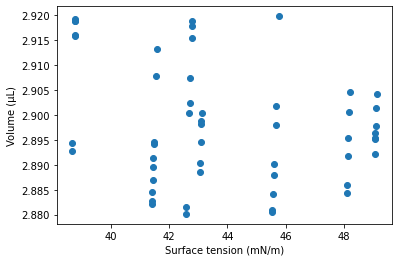

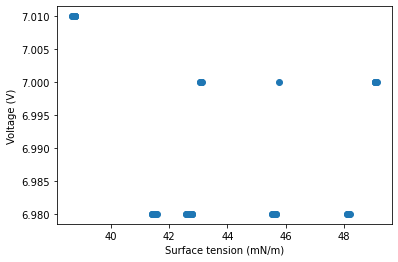

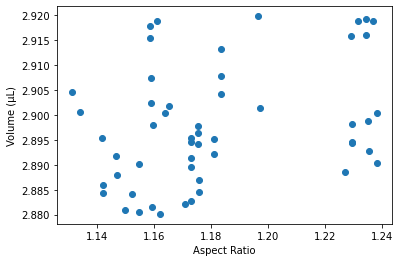

In [ ]:
plt.figure()
plt.plot(dataset.ST, dataset.Aspect_Ratio, 'o')
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Aspect Ratio')

plt.figure()
plt.plot(dataset.ST, dataset.volume, 'o')
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Volume (μL)')

plt.figure()
plt.plot(dataset.ST, dataset.volt, 'o')
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Voltage (V)')
# plt.ylim(7.15, 7.25)

plt.figure()
plt.plot(dataset.Aspect_Ratio, dataset.volume, 'o')
plt.xlabel('Aspect Ratio')
plt.ylabel('Volume (μL)')

# plt.figure()
# plt.ylabel('Probability density')
# sns.distplot(dataset.loc[:, 'volt'])
# plt.xlabel('Voltage [V]')


In [ ]:
raw_dataset.shape
# fileCTAB9, fileCTAB10, fileCTAB12, fileCTAB13, fileCTAB14, fileTrit9, fileTrit10, fileTrit11, fileTrit12, fileTrit13, fileTrit14, fileTrit16])
print(len(fileCTAB9))
print(len(fileCTAB10))
print(len(fileCTAB12))
print(len(fileCTAB13))
print(len(fileCTAB14))
print(len(fileTrit9))
print(len(fileTrit10))
print(len(fileTrit11))
print(len(fileTrit12))
print(len(fileTrit13))
print(len(fileTrit14))
print(len(fileTrit16))

5029
5064
5077
5046
4832
4951
5044
5095
4856
5016
4922
5103


In [ ]:
dataset


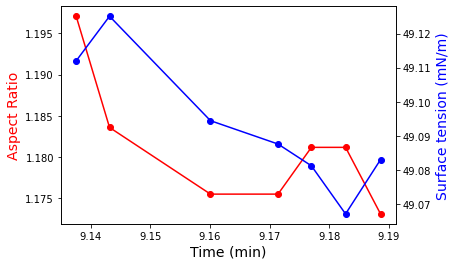

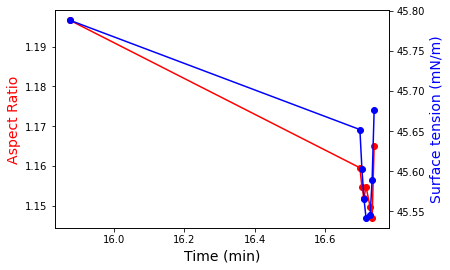

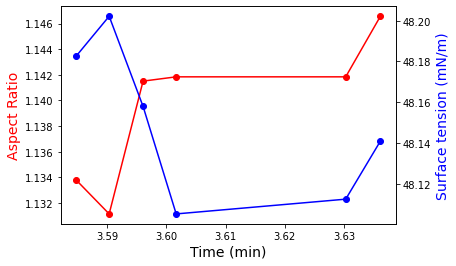

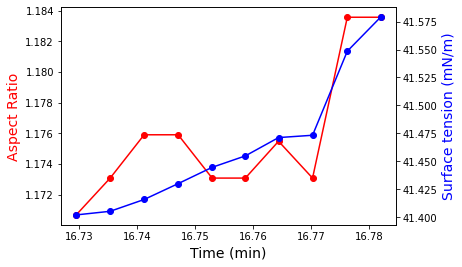

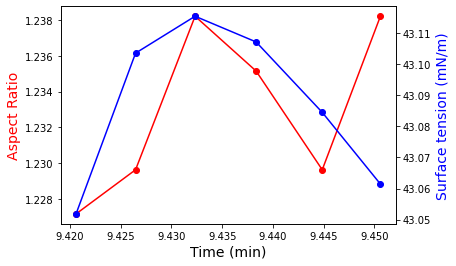

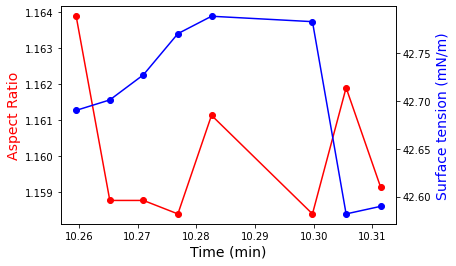

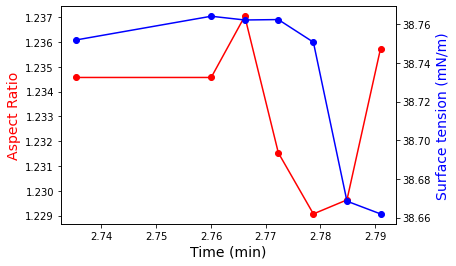

In [ ]:
# dataset = dataset[(dataset['volt'] >= 7.18) & (dataset['volt'] <= 7.21)]



lim1=0
lim2=7
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
plt.plot(dataset.time[lim1:lim2]/60, dataset.Aspect_Ratio[lim1:lim2], marker='o', color='red') 
# set x-axis label
ax.set_xlabel("Time (min)",fontsize=14)
# set y-axis label
ax.set_ylabel("Aspect Ratio",color="red",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dataset.time[lim1:lim2]/60, dataset.ST[lim1:lim2], marker='o', color="blue")
ax2.set_ylabel("Surface tension (mN/m)",color="blue",fontsize=14)
plt.show()



lim1=7
lim2=15
fig,ax = plt.subplots()
plt.plot(dataset.time[lim1:lim2]/60, dataset.Aspect_Ratio[lim1:lim2], marker='o', color='red') 
ax.set_xlabel("Time (min)",fontsize=14)
ax.set_ylabel("Aspect Ratio",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(dataset.time[lim1:lim2]/60, dataset.ST[lim1:lim2], marker='o', color="blue")
ax2.set_ylabel("Surface tension (mN/m)",color="blue",fontsize=14)
plt.show()


lim1=15
lim2=21
fig,ax = plt.subplots()
plt.plot(dataset.time[lim1:lim2]/60, dataset.Aspect_Ratio[lim1:lim2], marker='o', color='red') 
ax.set_xlabel("Time (min)",fontsize=14)
ax.set_ylabel("Aspect Ratio",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(dataset.time[lim1:lim2]/60, dataset.ST[lim1:lim2], marker='o', color="blue")
ax2.set_ylabel("Surface tension (mN/m)",color="blue",fontsize=14)
plt.show()


lim1=21
lim2=31
fig,ax = plt.subplots()
plt.plot(dataset.time[lim1:lim2]/60, dataset.Aspect_Ratio[lim1:lim2], marker='o', color='red') 
ax.set_xlabel("Time (min)",fontsize=14)
ax.set_ylabel("Aspect Ratio",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(dataset.time[lim1:lim2]/60, dataset.ST[lim1:lim2], marker='o', color="blue")
ax2.set_ylabel("Surface tension (mN/m)",color="blue",fontsize=14)
plt.show()


lim1=31
lim2=37
fig,ax = plt.subplots()
plt.plot(dataset.time[lim1:lim2]/60, dataset.Aspect_Ratio[lim1:lim2], marker='o', color='red') 
ax.set_xlabel("Time (min)",fontsize=14)
ax.set_ylabel("Aspect Ratio",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(dataset.time[lim1:lim2]/60, dataset.ST[lim1:lim2], marker='o', color="blue")
ax2.set_ylabel("Surface tension (mN/m)",color="blue",fontsize=14)
plt.show()


lim1=37
lim2=45
fig,ax = plt.subplots()
plt.plot(dataset.time[lim1:lim2]/60, dataset.Aspect_Ratio[lim1:lim2], marker='o', color='red') 
ax.set_xlabel("Time (min)",fontsize=14)
ax.set_ylabel("Aspect Ratio",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(dataset.time[lim1:lim2]/60, dataset.ST[lim1:lim2], marker='o', color="blue")
ax2.set_ylabel("Surface tension (mN/m)",color="blue",fontsize=14)
plt.show()

lim1=45
lim2=52
fig,ax = plt.subplots()
plt.plot(dataset.time[lim1:lim2]/60, dataset.Aspect_Ratio[lim1:lim2], marker='o', color='red') 
ax.set_xlabel("Time (min)",fontsize=14)
ax.set_ylabel("Aspect Ratio",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(dataset.time[lim1:lim2]/60, dataset.ST[lim1:lim2], marker='o', color="blue")
ax2.set_ylabel("Surface tension (mN/m)",color="blue",fontsize=14)
plt.show()

# dataset.ST

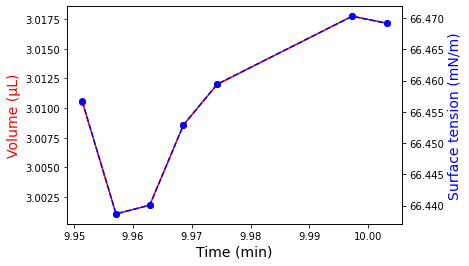

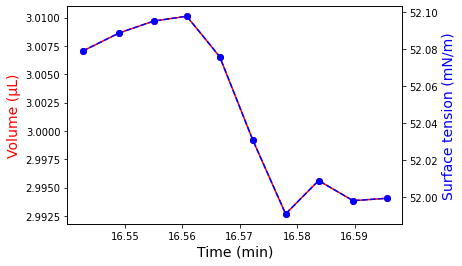

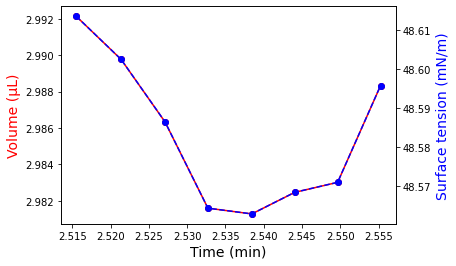

In [ ]:
# dataset = dataset[(dataset['volt'] >= 7.18) & (dataset['volt'] <= 7.21)]

lim1=0
lim2=7
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
plt.plot(dataset.time[lim1:lim2]/60, dataset.volume[lim1:lim2], marker='o', color='red') 
# set x-axis label
ax.set_xlabel("Time (min)",fontsize=14)
# set y-axis label
ax.set_ylabel("Volume (μL)",color="red",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dataset.time[lim1:lim2]/60, dataset.ST[lim1:lim2], 'b--', marker='o')
ax2.set_ylabel("Surface tension (mN/m)",color="blue",fontsize=14)
plt.show()



lim1=7
lim2=17
fig,ax = plt.subplots()
plt.plot(dataset.time[lim1:lim2]/60, dataset.volume[lim1:lim2], marker='o', color='red') 
ax.set_xlabel("Time (min)",fontsize=14)
ax.set_ylabel("Volume (μL)",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(dataset.time[lim1:lim2]/60, dataset.ST[lim1:lim2], 'b--', marker='o')
ax2.set_ylabel("Surface tension (mN/m)",color="blue",fontsize=14)
plt.show()


lim1=17
lim2=25
fig,ax = plt.subplots()
plt.plot(dataset.time[lim1:lim2]/60, dataset.volume[lim1:lim2], marker='o', color='red') 
ax.set_xlabel("Time (min)",fontsize=14)
ax.set_ylabel("Volume (μL)",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(dataset.time[lim1:lim2]/60, dataset.ST[lim1:lim2], 'b--', marker='o')
ax2.set_ylabel("Surface tension (mN/m)",color="blue",fontsize=14)
plt.show()

# dataset.ST

In [ ]:
dataset = dataset[(dataset['Aspect_Ratio'] <= 1.35)]
dataset=dataset.reset_index()
dataset.pop('index')
dataset.tail()

In [ ]:

ST_CTAB=np.array([71.005, 70.853, 70.809, 70.581, 70.367, 70.161, 69.674, 68.157, 65.819, 62.847, 60.542, 57.891, 53.584, 49.535, 47.014, 44.218, 41.755, 40.762,  38.94, 38.62, 37.60, 37.04, 36.12, 34.43])
C_CTAB=np.array([0.00100, 0.00200, 0.00500, 0.01000, 0.01500, 0.03000, 0.05500, 0.10000, 0.15000, 0.20000, 0.25000, 0.30000, 0.40000, 0.50000, 0.60000, 0.70000, 0.80000, 0.85000,  0.95000, 1.00000, 2.50000, 5.0000, 13.15224, 96.30951])

lim1=0+len(fileCTAB7)+len(fileCTAB8)#+len(fileCTAB9)+len(fileCTAB10)+len(fileCTAB11)+len(fileCTAB12)
lim2=len(fileCTAB7)+len(fileCTAB8)+len(fileCTAB9)#+len(fileCTAB10)+len(fileCTAB11)+len(fileCTAB12)+len(fileCTAB13)

plt.figure()
plt.plot(dataset.volume, 'o')
# plt.ylim(5.1, 5.4)
# plt.xlim(10250, 10500)
plt.figure()
plt.semilogx(dataset.surfactant_conc, dataset.ST, 'o',  markersize=0.5)
# plt.semilogx(C_CTAB, ST_CTAB, '-o')
# plt.xlim(0.1, 1)
# plt.ylim(52, 65)
# plt.ylim(44, 46)
plt.figure()
plt.plot(dataset.Aspect_Ratio)

Text(0, 0.5, 'Aspect Ratio')

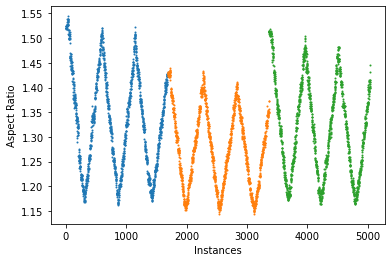

In [ ]:
lim1= 1689
lim2= 3362

plt.figure()
plt.plot(dataset.Aspect_Ratio[0:lim1], 'o', markersize=1)
plt.plot(dataset.Aspect_Ratio[lim1:lim2], 'o', markersize=1)
plt.plot(dataset.Aspect_Ratio[lim2:], 'o', markersize=1)
plt.xlabel('Instances')
plt.ylabel('Aspect Ratio')

### Remover selected features

In [10]:
#If satisfied:
# dataset=final_dataset.copy()

# for i in range(175):
#  dataset.pop('rho_%d' %i)
# for i in range(175):
#   dataset.pop('phi_%d' %i)
# for i in range(175):
#  dataset.pop('theta_%d' %i)
dataset.pop("height")
dataset.pop("width")
# dataset.pop("volume")
dataset.pop("R_sph")
dataset.pop('time')
Power=dataset.pop('Power')
dataset.pop("centre_x")
# dataset.pop("Aspect_Ratio")
# dataset.pop('radius')
centre_z = dataset.pop("centre_z")

# current=dataset.pop('current')
# voltage = dataset.pop('volt')
# centred_z = dataset.pop("centred_z")
# surf_conc = dataset.pop('surfactant_conc')
# ST=dataset.pop("ST")

dataset.tail()

rho_0     rho_1     rho_2     rho_3     rho_4     rho_5     rho_6  \
58364  0.752019  0.753423  0.751969  0.748898  0.748090  0.745630  0.743755   
58365  0.751976  0.753333  0.751833  0.747438  0.747859  0.745252  0.741373   
58366  0.750053  0.751397  0.749880  0.748385  0.745866  0.743335  0.741739   
58367  0.750083  0.747624  0.746127  0.745592  0.744952  0.743258  0.739445   
58368  0.750165  0.751629  0.750232  0.749803  0.746460  0.744051  0.741164   

          rho_7     rho_8     rho_9  ...   phi_173  phi_174    volume  \
58364  0.739546  0.736226  0.732583  ...  3.098966    3.135  1.395802   
58365  0.738592  0.735435  0.732574  ...  3.098966    3.135  1.396137   
58366  0.737198  0.733329  0.730433  ...  3.098966    3.135  1.392782   
58367  0.736726  0.733616  0.728434  ...  3.098966    3.135  1.391590   
58368  0.738500  0.734412  0.731644  ...  3.098966    3.135  1.389240   

       Aspect_Ratio  volt  current  centred_z  surfactant_conc         ST  \
58364      1.267742   8.4    0.329   0.034708         1.328075  29.025006   
58365      1.267742   8.4    0.329   0.038533         1.327757  29.025040   
58366      1.264516   8.4    0.329   0.050008         1.330955  29.024693   
58367      1.264516   8.4    0.329   0.034708         1.332096  29.024570   
58368      1.264516   8.4    0.329   0.046183         1.334349  29.024326   

       surf_number  
58364          2.0  
58365          2.0  
58366          2.0  
58367          2.0  
58368          2.0  

[5 rows x 358 columns]

### Calculate theta

In [ ]:
# points=175

# theta=[]
# theta_array=[]
# for i in range(points):
#   theta.append(str('theta_%d' %i))

# for i in range(len(dataset)):
#   x, y=pol2cart(dataset.iloc[i, 0:points].values, dataset.iloc[i, points:2*points].values)
#   theta_array.append(azimuth(x, y))

# dataset[theta]=theta_array


# dataset['volt']=voltage
# dataset['current']=current
# # dataset['Power']=Power
# # dataset['AR']=AR
# dataset['centred_z']=centred_z
# dataset['ST']=ST

# for i in range(0, 175):
#   dataset.pop('phi_%d' %i)


# dataset.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

rho_0     rho_1     rho_2     rho_3     rho_4     rho_5     rho_6  \
43631  0.822956  0.824628  0.823538  0.819646  0.817627  0.814950  0.812303   
43632  0.823179  0.821211  0.820299  0.820453  0.817258  0.812226  0.811597   
43633  0.823146  0.824190  0.820852  0.820338  0.817640  0.814687  0.809651   
43634  0.817236  0.818916  0.817827  0.813927  0.812327  0.809192  0.807279   
43635  0.817026  0.818495  0.816697  0.813079  0.809986  0.807916  0.806869   

          rho_7     rho_8     rho_9  ...  theta_169  theta_170  theta_171  \
43631  0.808277  0.802417  0.797782  ...  -1.384031  -1.420066    -1.4561   
43632  0.808020  0.801379  0.795466  ...  -1.384031  -1.420066    -1.4561   
43633  0.807795  0.801126  0.795790  ...  -1.384031  -1.420066    -1.4561   
43634  0.803375  0.797753  0.793099  ...  -1.384031  -1.420066    -1.4561   
43635  0.800367  0.797474  0.792726  ...  -1.384031  -1.420066    -1.4561   

       theta_172  theta_173  theta_174  volt  current  centred_z       ST  
43631  -1.492135  -1.528169  -1.564204  8.92    0.337   0.131403  38.1868  
43632  -1.492135  -1.528169  -1.564204  8.92    0.337   0.131403  38.1868  
43633  -1.492135  -1.528169  -1.564204  8.92    0.337   0.142877  38.1868  
43634  -1.492135  -1.528169  -1.564204  8.92    0.337   0.123753  38.1868  
43635  -1.492135  -1.528169  -1.564204  8.92    0.337   0.116103  38.1868  

[5 rows x 354 columns]

In [ ]:
# dataset['volt']=voltage
# dataset['current']=current
# # dataset['Power']=Power
# # dataset['AR']=AR
# dataset['centre_z']=centre_z
# dataset['ST']=ST

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

#### Save numbered dataset

In [ ]:
# drop1=np.tile(1, lim1)
# drop2=np.tile(2, lim2-lim1)
# drop3=np.tile(3, len(raw_dataset)-lim2)

# print(len(drop1)+len(drop2)+len(drop3), len(dataset))

# drop_number=np.hstack([drop1, drop2, drop3]).T

# len(drop_number)

# raw_dataset['droplet']=drop_number

# raw_dataset.tail()

5046 5046


rho_0     rho_1     rho_2  ...  Aspect_Ratio         ST  drop
5041  0.960475  0.959126  0.959431  ...      1.430199  39.834240     3
5042  0.957232  0.952821  0.953189  ...      1.430199  39.770070     3
5043  0.961966  0.962232  0.962331  ...      1.445402  39.745046     3
5044  0.963888  0.963918  0.964101  ...      1.452450  39.825350     3
5045  0.963964  0.961875  0.962118  ...      1.452450  39.830917     3

[5 rows x 914 columns]

In [ ]:
# path=str('/content/drive/MyDrive/DropLev/Levitator_2/Training/CTAB/numbered_files/')
# csvfilename='CTAB.csv'

# raw_dataset.to_csv(path+csvfilename, sep=';', header=True)


#### Cappilary length check
 

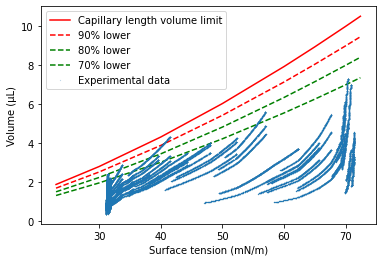

In [ ]:
# #Cappilary length check

# ST_range=np.array([23, 30, 40, 50, 60, 65, 70, 72.4])
# volume_range=np.array([1.8825, 2.8043, 4.3175, 6.0340, 7.9318, 8.9437, 9.9953, 10.5137])

# # plt.figure()
# # # plt.plot(dataset.ST, dataset.Aspect_Ratio, 'o', markersize=1)
# # plt.plot(dataset.ST[0:lim1], dataset.Aspect_Ratio[0:lim1], 'o', markersize=1)
# # plt.plot(dataset.ST[lim1:lim2], dataset.Aspect_Ratio[lim1:lim2], 'o', markersize=1)
# # plt.plot(dataset.ST[lim2:], dataset.Aspect_Ratio[lim2:], 'o', markersize=1)
# # plt.gca().invert_xaxis()
# # plt.xlabel('Surface tension (mN/m)')
# # plt.ylabel('Aspect Ratio')

# # plt.figure()
# # # plt.plot(dataset.volume, 'o', markersize=1)
# # plt.plot(dataset.volume[0:lim1], 'o', markersize=1)
# # plt.plot(dataset.volume[lim1:lim2], 'o', markersize=1)
# # plt.plot(dataset.volume[lim2:], 'o', markersize=1)
# # plt.xlabel('Instances')
# # plt.ylabel('Volume (μL)')

# plt.figure()
# plt.plot(ST_range, volume_range, '-r', label='Capillary length volume limit')
# plt.plot(ST_range, volume_range*0.9, '--r', label='90% lower')
# plt.plot(ST_range, volume_range*0.8, '--g', label='80% lower')
# plt.plot(ST_range, volume_range*0.7, '--g', label='70% lower')
# plt.plot(dataset.ST, dataset.volume, 'o', markersize=0.1, label='Experimental data')
# plt.xlabel('Surface tension (mN/m)')
# plt.ylabel('Volume (μL)')
# plt.legend()


In [ ]:

cut_df1=dataset.iloc[0:lim1]
cut_df2=[0] #dataset.iloc[lim2:]

if len(cut_df2)>1:
  cut_df=pd.concat([cut_df1, cut_df2]).reset_index()
else:
  cut_df=cut_df1.copy().reset_index()

cut_df.tail()
cut_df.pop('index')

dataset=cut_df.copy()
dataset.tail()

rho_0     rho_1     rho_2  ...  volt  Aspect_Ratio         ST
3222  0.822386  0.823070  0.823239  ...  8.92      1.319018  38.500904
3223  0.822386  0.823070  0.823239  ...  8.92      1.319018  38.499712
3224  0.822573  0.822786  0.822919  ...  8.92      1.319018  38.503163
3225  0.816622  0.817186  0.817338  ...  8.92      1.301829  38.493602
3226  0.816649  0.817338  0.817508  ...  8.92      1.301829  38.491487

[5 rows x 605 columns]

#### Run per file

In [ ]:
# saved_dataset.pop('R_sph')
# saved_dataset.pop('centre_x')
# saved_dataset.pop('centre_y')
# saved_dataset.pop('Aspect_Ratio')

In [ ]:
# dataset=saved_dataset.copy()
# # saved_dataset=dataset.copy()


In [ ]:
# # saved_dataset.shape

# dataset.shape

(5096, 353)

In [ ]:

# lim1=len(fileTrit13)+len(fileTrit14)+len(fileTrit15)+len(fileTrit16)+len(fileTrit17)+len(fileTrit18)+len(fileTrit19)+len(fileTrit20)
# lim2=len(fileTrit13)+len(fileTrit14)+len(fileTrit15)+len(fileTrit16)+len(fileTrit17)+len(fileTrit18)+len(fileTrit19)+len(fileTrit20)+len(fileTrit21)

# dataset=dataset.iloc[lim1:lim2, :].copy()
# dataset=dataset.reset_index()
# dataset.pop('index')
# dataset.tail()

rho_1     rho_3     rho_5  ...    volume  volt         ST
5070  0.469208  0.470609  0.468989  ...  0.375028  8.92  31.130025
5071  0.474532  0.471455  0.472261  ...  0.378651  8.92  31.130713
5072  0.476336  0.473131  0.473580  ...  0.380113  8.92  31.130990
5073  0.469426  0.470981  0.469519  ...  0.371945  8.92  31.129434
5074  0.473131  0.470791  0.473039  ...  0.374740  8.92  31.129970

[5 rows x 353 columns]

#### Drop contour points

In [ ]:
# n_dataset=dataset.copy()

# # If we want to drop 150 datapoints then n= 299 

# # If we want to drop 125 datapoints then n= 250
# 6

n=250
for i in range(0, n, 2):
  dataset.pop('theta_%d' %i)

for i in range(0, n, 2):
  dataset.pop('rho_%d' %i)

# for i in range(80,160, 1):
#   dataset.pop('rho_%d' %i)
dataset.tail()

rho_1     rho_3     rho_5  ...  surfactant_conc  Aspect_Ratio         ST
29190  0.814721  0.813040  0.814299  ...         1.016914      1.167123  38.603260
29191  0.814972  0.815349  0.815430  ...         1.017086      1.167123  38.603069
29192  0.814810  0.817141  0.814658  ...         1.015918      1.167123  38.604365
29193  0.816669  0.815235  0.816561  ...         1.015075      1.169863  38.605301
29194  0.816669  0.816884  0.816203  ...         1.014788      1.169863  38.605619

[5 rows x 356 columns]

In [ ]:
# If we want to end up with 76 contour points then n= 299 and then n=149

# n=149
# for i in range(1, n, 2):
#   dataset.pop('theta_%d' %i)

# # for i in range(0, n, 2):
# #   dataset.pop('phi_%d' %i)

# for i in range(1,n, 2):
#   dataset.pop('rho_%d' %i)
# dataset.tail()

rho_149   rho_151   rho_153  ...  centre_y  surfactant_conc         ST
25825  0.810896  0.811383  0.809596  ... -2.015714         1.016914  38.166889
25826  0.810147  0.806037  0.805747  ... -2.011889         1.017086  38.166689
25827  0.809605  0.807506  0.802918  ... -2.027189         1.015918  38.168053
25828  0.812898  0.813600  0.808694  ... -2.027189         1.015075  38.169038
25829  0.811421  0.806520  0.805885  ... -2.023364         1.014788  38.169373

[5 rows x 156 columns]

In [ ]:
# def pol2cart(rho, phi):
#     x = rho * np.cos(phi)
#     y = rho * np.sin(phi)
#     return(x, y)

# #Check that the drop contour is still well defined!

# # For 150 contour datapoints:
# # plt.figure()
# # plt.plot(dataset.iloc[600, 150:300], dataset.iloc[600, 0:150])


# # For 175 contour datapoints:
# n=80

# plt.figure()
# plt.title('Polar coordinates')
# plt.plot(dataset.iloc[n, 175:350], dataset.iloc[n, 0:175], '-o')
# plt.ylabel('Radius, ρ')
# plt.xlabel('Azimuth angle, θ')

# x, y=pol2cart(dataset.iloc[n, 0:175].values, dataset.iloc[n, 175:350].values)

# plt.figure()
# plt.title('Cartesian coordinates')
# plt.plot(x, y, '-o')
# plt.xlabel('x coordinate (mm)')
# plt.ylabel('z coordinate (mm)')

# print(max(dataset.iloc[n, 0:175])-min(dataset.iloc[n, 0:175]))

#### Calculate the acoustic pressure from the simple model

In [ ]:
new_input=np.asarray(dataset)

In [ ]:
# dataset.iloc[:, 351]

In [ ]:
# # If no contour points were droped
n_ST=353
n_Rsph=351
rho_i=0
rho_f=175
theta_i=175
theta_f=350

Min:  1663.182137647717 Pa, Max: 3139.6230431996564 Pa


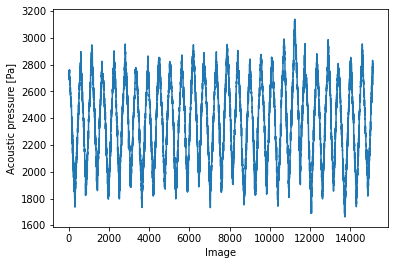

In [ ]:
from lmfit import Model, fit_report, Parameters

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
    rho=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)+R_sph
    return rho


data_Ps=[]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340 #mm^-1

for i in range(len(new_input)):
  gamma=new_input[i, n_ST]
  R_sph=new_input[i, n_Rsph]
  rho=new_input[i, rho_i:rho_f]
  gmodel = Model(model_fit, nan_policy='omit')
    
  fit_param = Parameters()
  fit_param.add('Ps', value=700, min=10, max=4000)
  
  result = gmodel.fit(rho, th=new_input[i, theta_i:theta_f], params=fit_param)         #rho_final, th: x and y to be evaluated, respectively
  Ps=result.params['Ps'].value
  data_Ps.append(Ps)
data_Ps=np.asarray(data_Ps)

plt.figure()
plt.plot(data_Ps)
plt.xlabel('Image')
plt.ylabel('Acoustic pressure [Pa]')

print('Min: ', min(data_Ps), 'Pa, Max:', max(data_Ps), 'Pa')

In [ ]:
dataset['Ps']=data_Ps
dataset.pop('R_sph')

dataset.tail()

rho_1     rho_3     rho_5  ...  volt         ST           Ps
15134  0.959126  0.959751  0.954385  ...   9.4  39.834240  2744.499266
15135  0.952821  0.953573  0.952398  ...   9.4  39.770070  2738.949214
15136  0.962232  0.962719  0.959629  ...   9.4  39.745046  2786.105399
15137  0.963918  0.962377  0.959514  ...   9.4  39.825350  2800.753844
15138  0.961875  0.962377  0.960436  ...   9.4  39.830917  2794.645123

[5 rows x 354 columns]

#### Generate contours based on experimental data

0
10000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

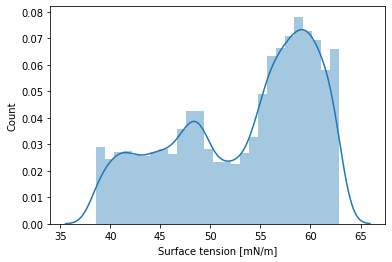

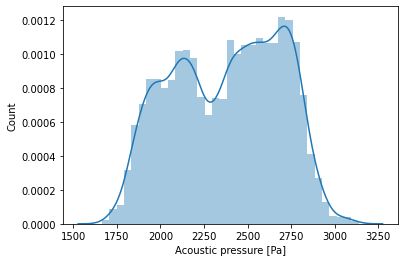

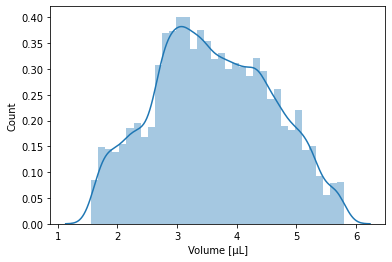

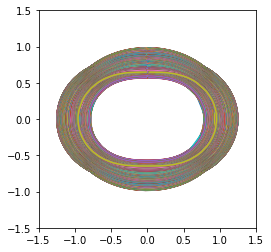

In [ ]:
def gen_data(num_sample,sampling, vol, Ps, st):
 
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/340  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 

    theta=np.random.rand(num_sample, sampling)*np.pi*2
    theta.sort()
    
    # ST_range=np.random.random(num_sample)*(72.4-37)+37
    r_all=np.empty([0,sampling])

    for i in range(num_sample):
        R_sph=calc_R_sph(vol[i])
        r=R_predict(theta[i], st[i], R_sph, Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
        if i % 10000 == 0:
                print(i)
        
    dataset=np.hstack((r_all, theta, vol.values.reshape([num_sample, 1]), Ps.values.reshape([num_sample,1]), st.values.reshape([num_sample,1])))

    plt.figure()
    plt.ylabel('Count')
    sns.distplot(st)
    sns.histplot(st, kde=False, bins=25, stat="density")
    plt.xlabel('Surface tension [mN/m]')

    plt.figure()
    plt.ylabel('Count')
    sns.histplot(Ps, kde=False, bins=25, stat="density")
    plt.xlabel('Acoustic pressure [Pa]')

    plt.figure()
    plt.ylabel('Count')
    sns.histplot(vol, kde=False, bins=25, stat="density")
    plt.xlabel('Volume [μL]')


    fig3 = plt.figure()
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    

    for j in dataset:

      x,y=pol2cart_theta(j[0:sampling], j[sampling:sampling+sampling])

      plt.plot(x, y)

    plt.show()
    return dataset

num_sample=len(dataset) # number of different ST values
sampling=175 # number of coordiante point describing the contour


new_dataset=gen_data(num_sample,sampling, dataset.volume, dataset.Ps, dataset.ST)


column_names=[]
for i in range(sampling):
  column_names.append('rho')
for i in range(sampling):
  column_names.append('theta')
column_names.append('volume')
column_names.append('Ps')
column_names.append('ST')


raw_dataset = pd.DataFrame(new_dataset, columns=column_names)




In [ ]:
new_dataset=raw_dataset.copy()
new_dataset.pop('Ps')
new_dataset['volt']=dataset.volt
new_dataset.tail()

In [ ]:
dataset=raw_dataset.copy()
dataset.tail()

plt.figure()
plt.ylabel('Count')
sns.histplot(dataset.volt, kde=False, bins=25, stat="density")
plt.xlabel('Voltage [V]')


rho       rho       rho  ...    volume           Ps         ST
15134  0.656766  0.680163  0.688578  ...  2.604058  2744.499266  39.834240
15135  0.655369  0.656164  0.657966  ...  2.594967  2738.949214  39.770070
15136  0.649777  0.655709  0.656026  ...  2.591426  2786.105399  39.745046
15137  0.647025  0.648520  0.653785  ...  2.602798  2800.753844  39.825350
15138  0.648252  0.651980  0.652286  ...  2.603587  2794.645123  39.830917

[5 rows x 353 columns]

#### Generate theoretical data based on experimental data distribution

0
10000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

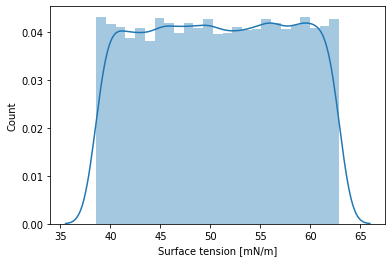

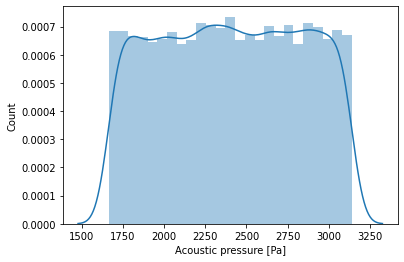

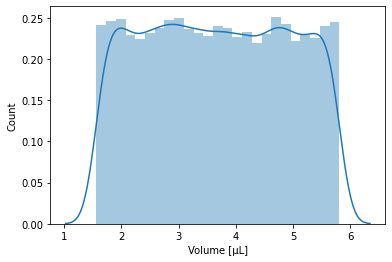

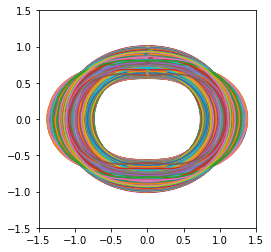

In [ ]:
def gen_data(num_sample,sampling, volmin, volmax, Psmin, Psmax, stmin, stmax):

    #np.random.seed(1234)

    vol_drop=np.random.random(num_sample)*(volmax-volmin)+volmin # [µL]
    # vol_drop=np.tile(vol_drop, num_sample)   # If the volume is constant !!!

    #gamma=72.8 #[mN/m]   
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/340  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 

    Ps=np.random.random(num_sample)*(Psmax-Psmin)+Psmin  #[Pa]
    R_sph=calc_R_sph(vol_drop)

    theta=np.random.rand(num_sample, sampling)*np.pi*2
    theta.sort()
    
    ST_range=np.random.random(num_sample)*(stmax-stmin)+stmin #[mN/m]
    r_all=np.empty([0,sampling])


    for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
        if i % 10000 == 0:
                print(i)
        
    
    dataset=np.hstack((r_all, theta, vol_drop.reshape([num_sample, 1]), Ps.reshape([num_sample,1]), ST_range.reshape([num_sample,1])))

    # print(ST_range.min())
    # print(ST_range.max())

    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Surface tension [mN/m]')
    sns.distplot(ST_range)
    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Acoustic pressure [Pa]')
    sns.distplot(Ps)
    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Volume [μL]')
    sns.distplot(vol_drop)

    fig3 = plt.figure()
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    

    for j in dataset:

      x,y=pol2cart_theta(j[0:sampling], j[sampling:sampling+sampling])

      plt.plot(x, y)

    plt.show()
    return dataset

num_sample=len(dataset) # number of different ST values
sampling=175 # number of coordiante point describing the contour

volmin=min(dataset.volume)
volmax=max(dataset.volume)
Psmin=min(dataset.Ps)
Psmax=max(dataset.Ps)
stmin=min(dataset.ST)
stmax=max(dataset.ST)



new_dataset=gen_data(num_sample,sampling, volmin, volmax, Psmin, Psmax, stmin, stmax)


column_names=[]
for i in range(sampling):
  column_names.append('rho')
for i in range(sampling):
  column_names.append('theta')
column_names.append('volume')
column_names.append('Ps')
column_names.append('ST')


raw_dataset = pd.DataFrame(new_dataset, columns=column_names)

# raw_dataset.to_csv('./dataset.csv',index=False)









In [ ]:
# Change the range of Ps into the Voltage range

OldMax=max(raw_dataset.Ps)
OldMin=min(raw_dataset.Ps)
NewMax=max(dataset.volt)
NewMin=min(dataset.volt)
NewValues=[]

OldRange = (OldMax - OldMin)
for i in range(len(raw_dataset)):
  if (OldRange == 0):
      NewValue = NewMin
      NewValues.append(NewValue)
  else:
      NewRange = (NewMax - NewMin)  
      NewValue = (((raw_dataset.Ps[i] - OldMin) * NewRange) / OldRange) + NewMin
      NewValues.append(NewValue)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


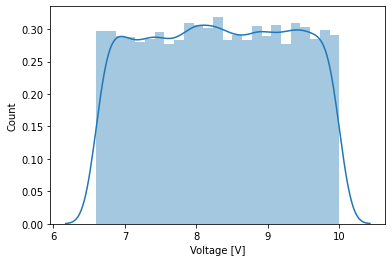

In [ ]:
plt.figure()
plt.ylabel('Count')
plt.xlabel('Voltage [V]')
sns.distplot(NewValues)

In [ ]:
raw_dataset.pop('Ps')

raw_dataset['volt']=NewValues

raw_dataset.tail()


rho       rho       rho  ...    volume         ST      volt
15134  0.740054  0.740080  0.740216  ...  3.079494  58.079569  9.166490
15135  0.607745  0.631826  0.646322  ...  3.181144  38.732907  9.882337
15136  0.923951  0.926391  0.927668  ...  4.931033  59.257276  7.432823
15137  0.733104  0.733314  0.734591  ...  3.450492  39.203098  8.359517
15138  0.931352  0.931412  0.931566  ...  5.267712  42.842189  6.831488

[5 rows x 353 columns]

In [ ]:
# dataset_saved=dataset.copy()

dataset=dataset_saved.copy()
# dataset_saved.pop('Ps')
# dataset_saved.tail()

In [ ]:
dataset=raw_dataset.copy()
dataset.tail()


rho       rho       rho  ...    volume         ST      volt
15134  0.740054  0.740080  0.740216  ...  3.079494  58.079569  9.166490
15135  0.607745  0.631826  0.646322  ...  3.181144  38.732907  9.882337
15136  0.923951  0.926391  0.927668  ...  4.931033  59.257276  7.432823
15137  0.733104  0.733314  0.734591  ...  3.450492  39.203098  8.359517
15138  0.931352  0.931412  0.931566  ...  5.267712  42.842189  6.831488

[5 rows x 353 columns]

##### Combine the best of the 2 worlds

In [ ]:
# dataset_saved.pop('Ps')
# dataset_saved.pop('R_sph')

Voltage=dataset_saved.pop('volt')
dataset_saved['volt']=Voltage

# dataset_saved.tail()

dataset = pd.DataFrame(np.concatenate([dataset_saved.values, raw_dataset.values]), columns=dataset_saved.columns)

dataset.tail()

rho_1     rho_3     rho_5  ...    volume         ST      volt
30273  0.740054  0.740080  0.740216  ...  3.079494  58.079569  9.166490
30274  0.607745  0.631826  0.646322  ...  3.181144  38.732907  9.882337
30275  0.923951  0.926391  0.927668  ...  4.931033  59.257276  7.432823
30276  0.733104  0.733314  0.734591  ...  3.450492  39.203098  8.359517
30277  0.931352  0.931412  0.931566  ...  5.267712  42.842189  6.831488

[5 rows x 353 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 0, 'Volume [μL]')

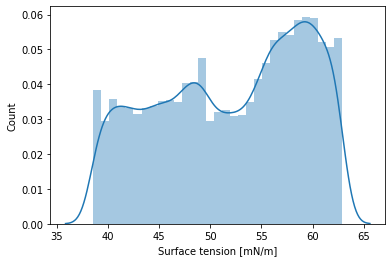

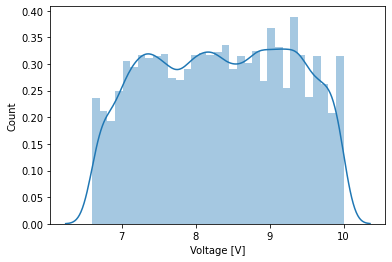

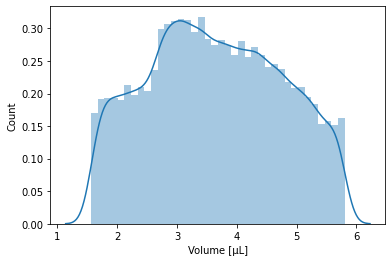

In [ ]:
plt.figure()
plt.ylabel('Count')
sns.distplot(dataset.ST)
plt.xlabel('Surface tension [mN/m]')

plt.figure()
plt.ylabel('Count')
sns.distplot(dataset.volt)
plt.xlabel('Voltage [V]')

plt.figure()
plt.ylabel('Count')
sns.distplot(dataset.volume)
plt.xlabel('Volume [μL]')


### Check contours

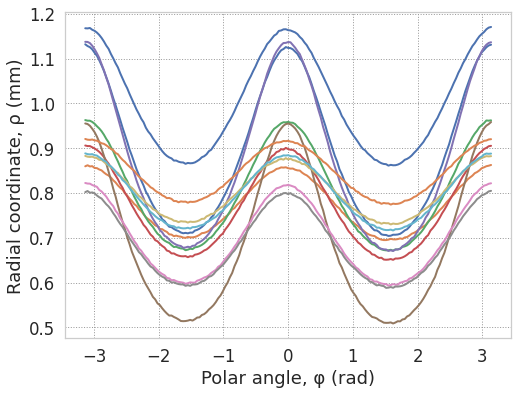

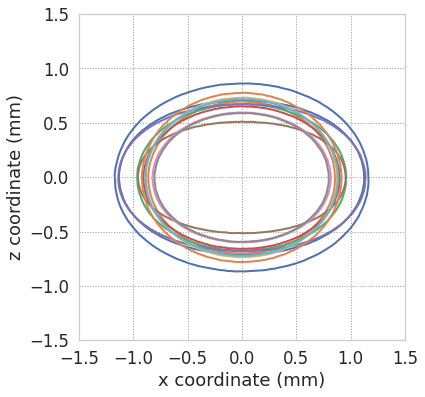

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})


n=0
rand_cont=np.array([0, 1500, 3000, 5000, 6000, 7500, 10000, 15000, 30000, 35000, 40000, 45000])
savefig=False

points=175

plt.figure(figsize=(8,6))
# plt.title('Polar coordinates')
for n in rand_cont:
  plt.plot(dataset.iloc[n, points:2*points], dataset.iloc[n, 0:points], linewidth=2)
plt.ylabel('Radial coordinate, ρ (mm)')
plt.xlabel('Polar angle, φ (rad)')
if savefig==True:
  plt.savefig(path+'polar_contours_before_norm_svg', dpi=300, format='svg')
  plt.savefig(path+'polar_contours_before_norm_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
# plt.title('Cartesian coordinates')
for i in rand_cont:
  x, y=pol2cart(dataset.iloc[i, 0:points].values, dataset.iloc[i, points:points*2].values)
  plt.plot(x, y, linewidth=2) 
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
if savefig==True:
  plt.savefig(path+'Cart_contours_before_norm_svg', dpi=300, format='svg')
  plt.savefig(path+'Cart_contours_before_norm_png', dpi=300, format='png')


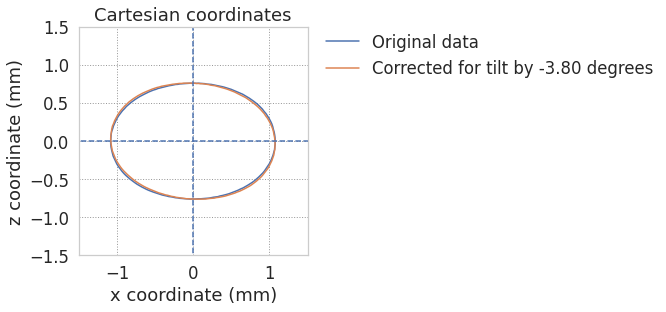

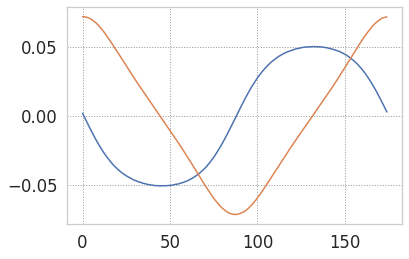

In [ ]:
i=0
# data=(np.vstack([x, y]).T, raw_dataset.width[0], raw_dataset.height[0])

# ellipse = cv2.fitEllipse(data)
# # Gets rotation of ellipse; same as rotation of contour
# rotation = ellipse[2]-90 #degress

degree2rad=np.pi/180
angle=-3.8*degree2rad


# rot_x = np.multiply(np.cos(angle)[:, np.newaxis], x) - np.multiply(np.sin(angle)[:, np.newaxis], y)
# rot_y = np.multiply(np.sin(angle)[:, np.newaxis], x) + np.multiply(np.cos(angle)[:, np.newaxis], y)


plt.figure(figsize=(8,6))
plt.title('Cartesian coordinates')
x, y=pol2cart_theta(dataset.iloc[i, 0:points].values, dataset.iloc[i, points:points*2].values)
plt.plot(x, y, label='Original data')
rot_x=np.cos(angle)*x-np.sin(angle)*y
rot_y=np.sin(angle)*x+np.cos(angle)*y
plt.plot(rot_x, rot_y, label='Corrected for tilt by %.2f degrees' %float(angle/degree2rad))
plt.plot(range(-2,3), np.repeat(0, len(range(-2,3))), '--b')
plt.plot(np.repeat(0, len(range(-2,3))), range(-2,3), '--b')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()


plt.figure()
plt.plot(rot_x-x)
plt.plot(rot_y-y)

### Adding noise 



#### To acoustic pressure

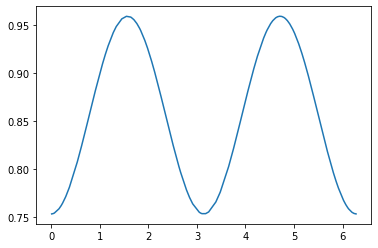

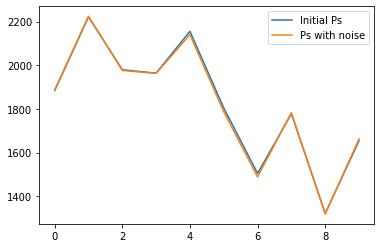

In [ ]:
noisy_dataset=dataset.copy()

np.random.seed(seed=1)
noise1 = np.random.random(size=[len(dataset), ])*25
noise2=np.random.random(size=[len(dataset), ])*25
noisy_dataset.Ps=noisy_dataset.Ps+noise1-noise2

plt.figure()
plt.plot(dataset.iloc[0, 0:sampling], dataset.iloc[0, sampling:sampling*2])

plt.figure()
plt.plot(dataset.Ps[0:10], label='Initial Ps')
plt.plot(noisy_dataset.Ps[0:10], label='Ps with noise')
plt.legend()

#### To ST

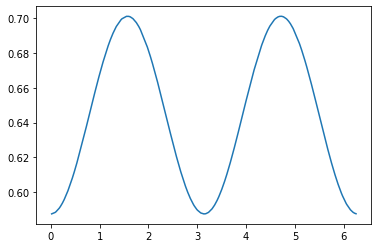

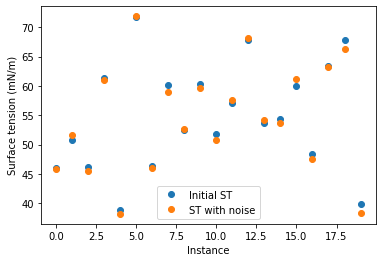

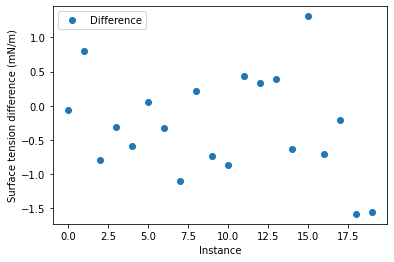

In [ ]:
noisy_dataset=dataset.copy()

np.random.seed(seed=1)
noise1 = np.random.random(size=[len(dataset), ])*2
noise2=np.random.random(size=[len(dataset), ])*2
noisy_dataset.ST=noisy_dataset.ST+noise1-noise2

plt.figure()
plt.plot(dataset.iloc[0, sampling:sampling*2], dataset.iloc[0, 0:sampling])

plt.figure()
plt.plot(dataset.ST[0:20], 'o', label='Initial ST')
plt.plot(noisy_dataset.ST[0:20], 'o', label='ST with noise')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
plt.legend()

plt.figure()
plt.plot(noisy_dataset.ST[0:20]-dataset.ST[0:20], 'o', label='Difference')
plt.xlabel('Instance')
plt.ylabel('Surface tension difference (mN/m)')
plt.legend()

#### Save the noise dataset

In [ ]:
#The original dataset is on: raw_dataset.tail()
# dataset=raw_dataset
#Save the noisy dataset as dataset
dataset=noisy_dataset.copy()
dataset.tail()

rho       rho       rho  ...       vol           Ps         ST
49995  0.769955  0.770697  0.771015  ...  4.122496  2949.759108  61.338048
49996  0.910290  0.910332  0.910342  ...  4.304270  1743.073514  50.960358
49997  0.586644  0.586776  0.586795  ...  1.236705  2652.605001  48.681920
49998  0.644898  0.646495  0.648373  ...  1.267398  1603.639302  53.421673
49999  0.592004  0.593309  0.593520  ...  1.176737  2289.590544  44.265350

[5 rows x 353 columns]

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

### Try to find outilers

In [ ]:
stats=dataset.describe()

stats=stats.transpose()

stats

count       mean       std  ...        50%        75%        max
rho_1         39789.0   0.996714  0.114326  ...   1.001376   1.078655   1.294062
rho_3         39789.0   0.996448  0.114172  ...   1.001013   1.078289   1.290918
rho_5         39789.0   0.995628  0.113972  ...   1.000651   1.077659   1.289553
rho_7         39789.0   0.994079  0.113791  ...   0.999631   1.077082   1.286506
rho_9         39789.0   0.991968  0.113814  ...   0.998127   1.075925   1.274855
...               ...        ...       ...  ...        ...        ...        ...
volume        39789.0   3.397619  1.029448  ...   3.334763   4.115682   6.006597
R_sph         39789.0   0.922406  0.098161  ...   0.926813   0.994148   1.127665
volt          39789.0   8.326581  0.896270  ...   8.340000   9.070000  10.000000
Aspect_Ratio  39789.0   1.261609  0.086947  ...   1.249412   1.323699   1.547753
ST            39789.0  54.043070  8.394259  ...  54.540671  61.167653  68.161024

[355 rows x 8 columns]

#### IQR method

In [ ]:
# IQR = Q3 −  Q1

Q1_Ar=stats.iloc[353, 4]
Q2_Ar=stats.iloc[353, 5]
Q3_Ar=stats.iloc[353, 6]
IQR_Ar=Q3_Ar-Q1_Ar

Low_AR=Q1_Ar-1.5*IQR_Ar
High_AR=Q3_Ar+1.5*IQR_Ar

print('High IQR value: %.5f, Max AR value: %.5f' %(High_AR, max(dataset.Aspect_Ratio)))
print('Low IQR value: %.5f, Min AR value: %.5f' %(Low_AR, min(dataset.Aspect_Ratio)))

High IQR value: 1.52254, Max AR value: 1.54775
Low IQR value: 0.99229, Min AR value: 1.09239


In [ ]:
clearer_df=dataset.drop(dataset[dataset.Aspect_Ratio >= High_AR].index)


In [ ]:
stats=clearer_df.describe()

stats=stats.transpose()


In [ ]:
Q1_vol=stats.iloc[350, 4]
Q2_vol=stats.iloc[350, 5]
Q3_vol=stats.iloc[350, 6]
IQR_vol=Q3_vol-Q1_vol

Low_vol=Q1_vol-1.5*IQR_vol
High_vol=Q3_vol+1.5*IQR_vol

print('High IQR value: %.5f, Max volume value: %.5f' %(High_vol, max(dataset.volume)))
print('Low IQR value: %.5f, Min volume value: %.5f' %(Low_vol, min(dataset.volume)))


High IQR value: 6.30008, Max volume value: 6.00660
Low IQR value: 0.51608, Min volume value: 0.93136


In [ ]:
Q1_volt=stats.iloc[352, 4]
Q2_volt=stats.iloc[352, 5]
Q3_volt=stats.iloc[352, 6]
IQR_volt=Q3_volt-Q1_volt

Low_volt=Q1_volt-1.5*IQR_volt
High_volt=Q3_volt+1.5*IQR_volt

print('High IQR value: %.5f, Max voltage value: %.5f' %(High_volt, max(dataset.volt)))
print('Low IQR value: %.5f, Min voltage value: %.5f' %(Low_volt, min(dataset.volt)))


High IQR value: 11.38000, Max voltage value: 10.00000
Low IQR value: 5.22000, Min voltage value: 6.60000


In [ ]:
Q1_Rsph=stats.iloc[351, 4]
Q2_Rsph=stats.iloc[351, 5]
Q3_Rsph=stats.iloc[351, 6]
IQR_Rsph=Q3_Rsph-Q1_Rsph

Low_Rsph=Q1_Rsph-1.5*IQR_Rsph
High_Rsph=Q3_Rsph+1.5*IQR_Rsph

print('High IQR value: %.5f, Max Rsph value: %.5f' %(High_Rsph, max(dataset.R_sph)))
print('Low IQR value: %.5f, Min Rsph value: %.5f' %(Low_Rsph, min(dataset.R_sph)))


High IQR value: 1.19512, Max Rsph value: 1.12766
Low IQR value: 0.66249, Min Rsph value: 0.60582


In [ ]:
clearer_df[clearer_df.R_sph <= Low_Rsph].index

Int64Index([36431, 36432, 36433, 36434, 36439, 36440, 36441, 36445, 36451,
            36452,
            ...
            36886, 36887, 36888, 36889, 36890, 36891, 36892, 36893, 36894,
            36895],
           dtype='int64', length=447)

In [ ]:
clearerer_df=clearer_df.drop(clearer_df[clearer_df.R_sph <= Low_Rsph].index)


In [ ]:
dataset=clearerer_df.copy()
dataset.reset_index()
dataset.pop('R_sph')
dataset.pop('Aspect_Ratio')

dataset.tail()

rho_1     rho_3     rho_5  ...    volume  volt         ST
40134  0.823070  0.825227  0.824092  ...  1.764766  8.92  38.500904
40135  0.823070  0.821416  0.820293  ...  1.762896  8.92  38.499712
40136  0.822786  0.823070  0.823852  ...  1.768315  8.92  38.503163
40137  0.817186  0.817902  0.815699  ...  1.753342  8.92  38.493602
40138  0.817338  0.818125  0.816030  ...  1.750045  8.92  38.491487

[5 rows x 353 columns]

### Shuffle the data

In [11]:
droplet_array=[]

droplets=[0, 1600, 3323, 4100, 5784, 7504, 7600, 9291, 10981, 11100, 12819, 14495, 15805, 16205,
          17805, 18938, 20257, 21927, 23614, 25292, 26977, 28655, 30344, 30655, 32304, 34028, 35483, 36283, 36483,
          38083, 39583, 41215, 42869, 44069, 45776, 46069, 47714, 48369, 49040, 50369, 51511, 52869, 54505, 56177, 57469, 58069, 58269, 58369]

for i in range(len(droplets)-1):
  droplet_array.append(np.repeat(i, droplets[i+1]-droplets[i]))


flat_list = []
for sublist in droplet_array:
    for item in sublist:
        flat_list.append(item)

droplet_array=np.reshape(flat_list, (len(flat_list), 1))


for i in range(len(droplets)):
  dataset['droplet']=droplet_array

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [12]:
droplet_str=[]
for i in range(len(dataset)):
  droplet_str.append(str(dataset['droplet'][i]))

dataset['droplet']=droplet_str

In [13]:
from random import randint
colors = []
keys=[]
for i in range(len(droplets)):
  colors.append('#%06X' % randint(0, 0xFFFFFF))
  keys.append(str(i))

In [14]:
droplet_dict=dict(zip(keys, colors))
# droplet_dict

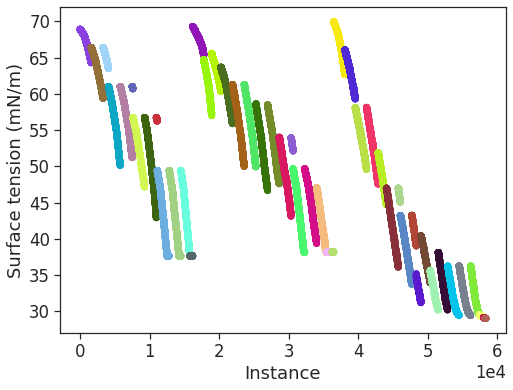

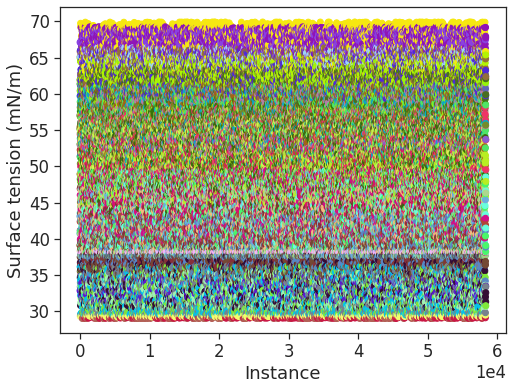

In [15]:
from sklearn.utils import shuffle

### In case an error occurs during saving the second plot ###
# import matplotlib as mpl
# mpl.rcParams['agg.path.chunksize'] = 10000

sns.set_theme(style='ticks', font_scale=1.5)
savefig=False


fig, ax = plt.subplots(figsize=(8, 6))
# plt.title('Before shuffling')
# for i in range(len(droplets)-1):
ax.scatter(range(len(dataset)), dataset.ST, marker='o', facecolors='none', c=dataset['droplet'].map(droplet_dict)) 
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instance')
if savefig==True:
  plt.savefig(path+'data_before_shuffling_colour_svg', dpi=300, format='svg')
  plt.savefig(path+'data_before_shuffling_colour_png', dpi=300, format='png')


dataset_sh=shuffle(dataset, random_state=0)


fig, ax = plt.subplots(figsize=(8, 6))
# plt.title('After shuffling')
ax.scatter(range(len(dataset_sh)), dataset_sh.ST, marker='o', facecolors='none', c=dataset_sh['droplet'].map(droplet_dict))
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instance')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
if savefig==True:
  plt.savefig(path+'data_after_shufffling_colour_png', dpi=300, format='png')
  plt.savefig(path+'data_after_shufffling_colour_svg', dpi=300, format='svg')

# normed_data.tail()

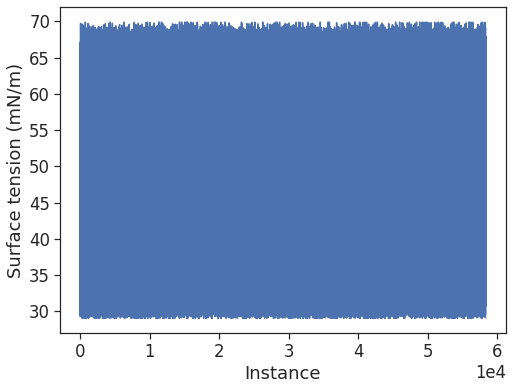

In [ ]:


plt.figure(figsize=(8, 6))
# plt.title('After shuffling')
plt.plot(range(len(dataset)), dataset.ST)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instance')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
if savefig==True:
  plt.savefig(path+'data_after_shufffling_png', dpi=300, format='png')
  plt.savefig(path+'data_after_shufling_svg', dpi=300, format='svg')


### Min-Max transformation

In [16]:
# dataset.pop('R_sph')
# dataset.pop('drop')
# dataset.pop('height')
# dataset.pop('width')
# dataset.pop('current')
# dataset.pop('time')
# dataset.pop('Power')
# dataset.pop('surfactant_conc')
# centre_z=dataset.pop('centre_z')
# dataset.pop('Aspect_Ratio')
# dataset.pop('volume')

dataset.pop('droplet')

dataset=dataset.reset_index()
dataset.pop('index')
dataset.tail()

rho_0     rho_1     rho_2     rho_3     rho_4     rho_5     rho_6  \
58364  0.752019  0.753423  0.751969  0.748898  0.748090  0.745630  0.743755   
58365  0.751976  0.753333  0.751833  0.747438  0.747859  0.745252  0.741373   
58366  0.750053  0.751397  0.749880  0.748385  0.745866  0.743335  0.741739   
58367  0.750083  0.747624  0.746127  0.745592  0.744952  0.743258  0.739445   
58368  0.750165  0.751629  0.750232  0.749803  0.746460  0.744051  0.741164   

          rho_7     rho_8     rho_9  ...   phi_173  phi_174    volume  \
58364  0.739546  0.736226  0.732583  ...  3.098966    3.135  1.395802   
58365  0.738592  0.735435  0.732574  ...  3.098966    3.135  1.396137   
58366  0.737198  0.733329  0.730433  ...  3.098966    3.135  1.392782   
58367  0.736726  0.733616  0.728434  ...  3.098966    3.135  1.391590   
58368  0.738500  0.734412  0.731644  ...  3.098966    3.135  1.389240   

       Aspect_Ratio  volt  current  centred_z  surfactant_conc         ST  \
58364      1.267742   8.4    0.329   0.034708         1.328075  29.025006   
58365      1.267742   8.4    0.329   0.038533         1.327757  29.025040   
58366      1.264516   8.4    0.329   0.050008         1.330955  29.024693   
58367      1.264516   8.4    0.329   0.034708         1.332096  29.024570   
58368      1.264516   8.4    0.329   0.046183         1.334349  29.024326   

       surf_number  
58364          2.0  
58365          2.0  
58366          2.0  
58367          2.0  
58368          2.0  

[5 rows x 358 columns]

In [17]:
#Min-Max transformation

def MinMaxTransformTrain(dataset_train, points):

  max_rho=[]
  min_rho=[]
  min_theta=[]
  max_theta=[]
  for i in range(len(dataset_train)):
    max_rho.append(max(dataset_train.iloc[i, 0:points].values))
    min_rho.append(min(dataset_train.iloc[i, 0:points].values))
    max_theta.append(max(dataset_train.iloc[i, points:2*points].values))
    min_theta.append(min(dataset_train.iloc[i, points:2*points].values))


  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))
  
  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = abs(OldMax - OldMin)
  for i in range(len(dataset_train)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (dataset_train.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # # Change the range of theta from 0 to 1

  OldMax= max(max_theta)
  OldMin=min(min_theta)

  NewValues_theta={}

  OldRange = abs(OldMax - OldMin)
  for i in range(len(dataset_train)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (dataset_train.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
        NewValues_theta[i]=NewValue



  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  new_df=pd.concat([df_theta, df_rho], axis=1)

  return new_df



def MinMaxTransformTest(dataset_test, dataset_train, points):

  max_rho=[]
  min_rho=[]
  min_theta=[]
  max_theta=[]
  for i in range(len(dataset_train)):
    max_rho.append(max(dataset_train.iloc[i, 0:points].values))
    min_rho.append(min(dataset_train.iloc[i, 0:points].values))
    max_theta.append(max(dataset_train.iloc[i, points:2*points].values))
    min_theta.append(min(dataset_train.iloc[i, points:2*points].values))


  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = abs(OldMax - OldMin)
  for i in range(len(dataset_test)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (dataset_test.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # # Change the range of theta from 0 to 1

  OldMax= max(max_theta)
  OldMin=min(min_theta)

  NewValues_theta={}

  OldRange = abs(OldMax - OldMin)
  for i in range(len(dataset_test)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (dataset_test.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
        NewValues_theta[i]=NewValue



  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  new_df=pd.concat([df_theta, df_rho], axis=1)

  return new_df


def MinMaxTransform_rho(rho, points):

  max_rho=[]
  min_rho=[]

  for i in range(len(rho)):
    max_rho.append(max(rho.iloc[i].values))
    min_rho.append(min(rho.iloc[i].values))


  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = abs(OldMax - OldMin)
  for i in range(len(dataset)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (rho.iloc[i] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T

  return df_rho

def min_max_norm(x):
  return (x-stats['min'])/abs((stats['max']-stats['min']))


### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [18]:
train_data = dataset.sample(frac=0.8,random_state=0)
test_data = dataset.drop(train_data.index)

#Reset index

train_data=train_data.reset_index()
index_train=train_data.pop('index')
volume_train=train_data.pop('volume')
Aspect_Ratio_train=train_data.pop('Aspect_Ratio')

surf_conc_train=train_data.pop('surfactant_conc')
surf_number_train=train_data.pop('surf_number')

test_data=test_data.reset_index()
index_test=test_data.pop('index')
volume_test=test_data.pop('volume')
Aspect_Ratio_test=test_data.pop('Aspect_Ratio')
surf_conc_test=test_data.pop('surfactant_conc')
surf_number_test=test_data.pop('surf_number')


In [ ]:
# plt.figure()
# for i in range(100):
#   plt.plot(normed_train_data.iloc[i, 175:350], normed_train_data.iloc[i, 0:175], 'o', markersize=1)
# plt.ylabel('Radius, ρ')
# plt.xlabel('Azimuth angle, θ')

### Scalling

In [19]:
#Scalling training dataset

new_df_train=MinMaxTransformTrain(dataset_train=train_data, points=175)
new_df_train.tail()


phi_0     phi_1     phi_2     phi_3     phi_4     phi_5     phi_6  \
46690    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
46691    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
46692    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
46693    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
46694    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   

         phi_7     phi_8     phi_9  ...   rho_165   rho_166   rho_167  \
46690  0.04023  0.045977  0.051724  ...  0.407624  0.408679  0.412996   
46691  0.04023  0.045977  0.051724  ...  0.307891  0.311960  0.312750   
46692  0.04023  0.045977  0.051724  ...  0.240036  0.243563  0.246122   
46693  0.04023  0.045977  0.051724  ...  0.344521  0.345182  0.347289   
46694  0.04023  0.045977  0.051724  ...  0.281448  0.283861  0.287343   

        rho_168   rho_169   rho_170   rho_171   rho_172   rho_173   rho_174  
46690  0.415144  0.418530  0.423149  0.424376  0.426875  0.426036  0.426485  
46691  0.316028  0.317665  0.321776  0.322317  0.324001  0.326828  0.326163  
46692  0.247827  0.249586  0.250541  0.252546  0.255598  0.255086  0.255643  
46693  0.349971  0.354084  0.354698  0.356498  0.359485  0.359045  0.359804  
46694  0.292209  0.293792  0.299228  0.301109  0.304101  0.303596  0.304220  

[5 rows x 350 columns]

In [20]:
#Scalling test dataset based on training dataset

new_df_test=MinMaxTransformTest(test_data, train_data, points=175)
new_df_test.tail()



phi_0     phi_1     phi_2     phi_3     phi_4     phi_5     phi_6  \
11669    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
11670    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
11671    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
11672    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
11673    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   

         phi_7     phi_8     phi_9  ...   rho_165   rho_166   rho_167  \
11669  0.04023  0.045977  0.051724  ...  0.319640  0.322076  0.326992   
11670  0.04023  0.045977  0.051724  ...  0.318946  0.323596  0.328816   
11671  0.04023  0.045977  0.051724  ...  0.321371  0.326353  0.332388   
11672  0.04023  0.045977  0.051724  ...  0.314210  0.319893  0.324811   
11673  0.04023  0.045977  0.051724  ...  0.317350  0.322550  0.325393   

        rho_168   rho_169   rho_170   rho_171   rho_172   rho_173   rho_174  
11669  0.330854  0.333311  0.337798  0.338985  0.341335  0.344850  0.344900  
11670  0.332112  0.335649  0.340201  0.341435  0.343730  0.342551  0.342553  
11671  0.334735  0.338212  0.342813  0.343885  0.346127  0.349540  0.349494  
11672  0.327725  0.330176  0.334535  0.337623  0.337320  0.340453  0.340113  
11673  0.331348  0.335028  0.339826  0.341095  0.343529  0.347133  0.347276  

[5 rows x 350 columns]

In [ ]:
# rand_cont=np.array([0])

# points=175

# plt.figure(figsize=(8,6))
# plt.title('Polar coordinates')
# for i in rand_cont:
#   plt.plot(new_df_train.iloc[i, 0:points], new_df_train.iloc[i, points:2*points], 'ob', label='Training data')
#   plt.plot(new_df_test.iloc[i, 0:points], new_df_test.iloc[i, points:2*points], 'ok', label='Test data')
# plt.ylabel('Normalized radius, ρ (a.u.)')
# plt.xlabel('Normalized azimuth angle, θ (a.u.)')
# plt.legend(frameon=False)
# if savefig==True:
#   plt.savefig(path+'polar_contours_after_norm_svg', dpi=300, format='svg')
#   plt.savefig(path+'polar_contours_after_norm_png', dpi=300, format='png')


# # plt.figure(figsize=(8,6))
# # plt.title('Cartesian coordinates')
# # for i in rand_cont:
# #   x, y=pol2cart_theta(new_df_train.iloc[i, 0:points].values, dataset.iloc[i, points:points*2])
# #   plt.scatter(x, y)
# # plt.xlabel('Normalized x coordinate (a.u.)')
# # plt.ylabel('Normalized z coordinate (a.u.)')
# # if savefig==True:
# #   plt.savefig(path+'Cart_contours_after_norm_svg', dpi=300, format='svg')
# #   plt.savefig(path+'Cart_contours_after_norm_png', dpi=300, format='png')


In [21]:
points=175

if train_data.shape[1]>2*points:
  stats = train_data.iloc[:, 2*points:].describe() 
else:
  stats = train_data.iloc[:, points:].describe() 
# stats.pop("ST")

stats = stats.transpose()
stats


count       mean        std        min        25%        50%  \
volt       46695.0   8.063710   0.857414   6.600000   7.340000   7.970000   
current    46695.0   0.312764   0.019648   0.272000   0.296000   0.312000   
centred_z  46695.0   0.001997   0.094150  -0.323581  -0.069027   0.020304   
ST         46695.0  49.504606  11.279460  29.024210  39.751155  49.820528   

                 75%        max  
volt        8.750000  10.000000  
current     0.329000   0.366000  
centred_z   0.080019   0.244943  
ST         58.573276  69.925068

##### Combining experimental and in silico data

In [ ]:
# max_rho=[]
# min_rho=[]
# min_theta_exp=[]
# max_theta_exp=[]
# min_theta_theo=[]
# max_theta_theo=[]
# for i in range(len(dataset)):
#   max_rho.append(max(dataset.iloc[i, 0:175].values))
#   min_rho.append(min(dataset.iloc[i, 0:175].values))
#   if i <len(dataset)/2:
#     max_theta_exp.append(max(dataset.iloc[i, 175:350].values))
#     min_theta_exp.append(min(dataset.iloc[i, 175:350].values))
#   else:
#     max_theta_theo.append(max(dataset.iloc[i, 175:350].values))
#     min_theta_theo.append(min(dataset.iloc[i, 175:350].values))

# print(min(min_rho), max(max_rho), min(min_theta_exp), max(max_theta_exp),  min(min_theta_theo), max(max_theta_theo))

In [ ]:
# # Change the range of rho from 0 to 1

# OldMax= max(max_rho)
# OldMin=min(min_rho)

# NewValues_rho={}

# OldRange = (OldMax - OldMin)
# for i in range(len(dataset)):
#   if (OldRange == 0):
#       NewValue = NewMin
#       NewValues.append(NewValue)
#   else:
#       NewValue = (dataset.iloc[i, 0:175] - OldMin)/(OldMax-OldMin) 
#       NewValues_rho[i]=NewValue

In [ ]:
# # Change the range of theta from 0 to 1

# OldMax= max(max_theta_exp)
# OldMin=min(min_theta_exp)

# NewValues_theta_exp={}

# OldRange = (OldMax - OldMin)
# for i in range(int(len(dataset)/2)):
#   if (OldRange == 0):
#       NewValue = NewMin
#       NewValues.append(NewValue)
#   else:
#       NewValue = (dataset.iloc[i, 175:350] - OldMin)/(OldMax-OldMin) 
#       NewValues_theta_exp[i]=NewValue

In [ ]:
# # Change the range of theta from 0 to 1

# OldMax= max(max_theta_theo)
# OldMin=min(min_theta_theo)

# NewValues_theta_theo={}

# OldRange = (OldMax - OldMin)
# for i in range(int(len(dataset)/2), int(len(dataset))):
#   if (OldRange == 0):
#       NewValue = NewMin
#       NewValues.append(NewValue)
#   else:
#       NewValue = (dataset.iloc[i, 175:350] - OldMin)/(OldMax-OldMin) 
#       NewValues_theta_theo[i]=NewValue

In [ ]:
# df_rho=pd.DataFrame.from_dict(NewValues_rho).T
# df_theta_exp=pd.DataFrame.from_dict(NewValues_theta_exp).T
# df_theta_theo=pd.DataFrame.from_dict(NewValues_theta_theo).T

# df_theta=pd.concat([df_theta_exp, df_theta_theo], axis=0)
# new_df=pd.concat([df_rho, df_theta], axis=1)

# new_df.tail()

rho_1     rho_3     rho_5  ...  theta_297  theta_298  theta_299
25825  0.358332  0.355977  0.357740  ...   0.256881   0.252367   0.250872
25826  0.358684  0.359212  0.359325  ...   0.263675   0.255355   0.251620
25827  0.358458  0.361723  0.358244  ...   0.253114   0.251620   0.250125
25828  0.361062  0.359052  0.360911  ...   0.256116   0.251624   0.250126
25829  0.361062  0.361363  0.360409  ...   0.265880   0.257612   0.253852

[5 rows x 350 columns]

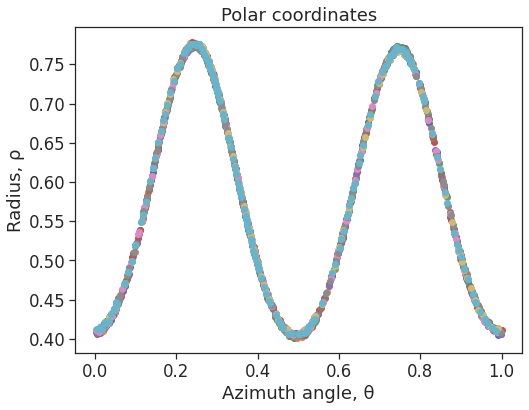

In [ ]:
# savefig=False

# plt.figure(figsize=(8,6))
# plt.title('Polar coordinates')
# for i in range(0, 10):
#   plt.plot(new_df.iloc[i, 175:350], new_df.iloc[i, 0:175], 'o')
# plt.ylabel('Radius, ρ')
# plt.xlabel('Azimuth angle, θ')
# if savefig==True:
#   plt.savefig(path+'polar_contours_after_norm_svg', dpi=300, format='svg')
#   plt.savefig(path+'polar_contours_after_norm_png', dpi=300, format='png')

# # plt.figure(figsize=(8,6))
# # plt.title('Cartesian coordinates')
# # for i in range(0, 10):
# #   x, y=pol2cart(new_df.iloc[i, 0:175].values, new_df.iloc[i, 175:350].values)
# #   plt.plot(x, y, '-o')
# # plt.xlabel('x coordinate (mm)')
# # plt.ylabel('z coordinate (mm)')
# # if savefig==True:
# #   plt.savefig(path+'Cart_contours_after_norm_svg', dpi=300, format='svg')
# #   plt.savefig(path+'Cart_contours_after_norm_png', dpi=300, format='png')

#### Continue from here

In [22]:
def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])

if train_data.shape[1]>2*points:
  normed_train_data_rest = min_max_norm(train_data.iloc[:, 2*points:]) #iloc[:, 2*points:]
  normed_test_data_rest = min_max_norm(test_data.iloc[:, 2*points:])   #iloc[:, 2*points:]
else:
  normed_train_data_rest = min_max_norm(train_data.iloc[:, points:]) #iloc[:, 2*points:]
  normed_test_data_rest = min_max_norm(test_data.iloc[:, points:])   #iloc[:, 2*points:]


In [23]:
#Putting scalled training dataset together

normed_train_data = new_df_train.copy()
# normed_train_data['height'] = normed_train_data_rest.height
# normed_train_data['width'] = normed_train_data_rest.width
# normed_train_data['volume'] = normed_train_data_rest.volume
# normed_train_data['R_sph'] = normed_train_data_rest.R_sph
# normed_train_data['centre_x'] = normed_train_data_rest.centre_x
normed_train_data['centred_z'] = normed_train_data_rest.centred_z
# normed_train_data['Aspect_Ratio'] = normed_train_data_rest.AR
normed_train_data['volt'] = normed_train_data_rest.volt
normed_train_data['current'] = normed_train_data_rest.current
# normed_train_data['Power'] = normed_train_data_rest.Power
normed_train_data['ST'] = normed_train_data_rest.ST

normed_train_data.tail()

phi_0     phi_1     phi_2     phi_3     phi_4     phi_5     phi_6  \
46690    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
46691    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
46692    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
46693    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
46694    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   

         phi_7     phi_8     phi_9  ...   rho_169   rho_170   rho_171  \
46690  0.04023  0.045977  0.051724  ...  0.418530  0.423149  0.424376   
46691  0.04023  0.045977  0.051724  ...  0.317665  0.321776  0.322317   
46692  0.04023  0.045977  0.051724  ...  0.249586  0.250541  0.252546   
46693  0.04023  0.045977  0.051724  ...  0.354084  0.354698  0.356498   
46694  0.04023  0.045977  0.051724  ...  0.293792  0.299228  0.301109   

        rho_172   rho_173   rho_174  centred_z      volt   current        ST  
46690  0.426875  0.426036  0.426485   0.294091  0.023529  0.053191  0.224020  
46691  0.324001  0.326828  0.326163   0.372809  0.050000  0.095745  0.007226  
46692  0.255598  0.255086  0.255643   0.387228  0.182353  0.255319  0.017301  
46693  0.359485  0.359045  0.359804   0.360788  0.000000  0.042553  0.134176  
46694  0.304101  0.303596  0.304220   0.655452  0.317647  0.340426  0.065227  

[5 rows x 354 columns]

In [24]:
#Putting scalled test dataset together

normed_test_data = new_df_test.copy()
# normed_test_data['height'] = normed_test_data_rest.height
# normed_test_data['width'] = normed_test_data_rest.width
# normed_test_data['volume'] = normed_test_data_rest.volume
# normed_test_data['R_sph'] = normed_test_data_rest.R_sph
# normed_test_data['centre_x'] = normed_test_data_rest.centre_x
normed_test_data['centred_z'] = normed_test_data_rest.centred_z
# normed_test_data['Aspect_Ratio'] = normed_test_data_rest.AR
normed_test_data['volt'] = normed_test_data_rest.volt
normed_test_data['current'] = normed_test_data_rest.current
# normed_test_data['Power'] = normed_test_data_rest.Power
normed_test_data['ST'] = normed_test_data_rest.ST

normed_test_data.tail()

phi_0     phi_1     phi_2     phi_3     phi_4     phi_5     phi_6  \
11669    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
11670    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
11671    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
11672    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   
11673    0.0  0.005747  0.011494  0.017241  0.022989  0.028736  0.034483   

         phi_7     phi_8     phi_9  ...   rho_169   rho_170   rho_171  \
11669  0.04023  0.045977  0.051724  ...  0.333311  0.337798  0.338985   
11670  0.04023  0.045977  0.051724  ...  0.335649  0.340201  0.341435   
11671  0.04023  0.045977  0.051724  ...  0.338212  0.342813  0.343885   
11672  0.04023  0.045977  0.051724  ...  0.330176  0.334535  0.337623   
11673  0.04023  0.045977  0.051724  ...  0.335028  0.339826  0.341095   

        rho_172   rho_173   rho_174  centred_z      volt   current        ST  
11669  0.341335  0.344850  0.344900   0.495654  0.420588  0.500000  0.000128  
11670  0.343730  0.342551  0.342553   0.512473  0.420588  0.500000  0.000108  
11671  0.346127  0.349540  0.349494   0.566296  0.444118  0.521277  0.000103  
11672  0.337320  0.340453  0.340113   0.670576  0.464706  0.521277  0.000040  
11673  0.343529  0.347133  0.347276   0.643665  0.508824  0.585106  0.000013  

[5 rows x 354 columns]

### Standard normalization

In [ ]:
# def std_norm(x):
#   return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = std_norm(train_dataset)
# normed_test_data  = std_norm(test_dataset)


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [25]:


train_labels = normed_train_data.pop('ST')
test_labels = normed_test_data.pop('ST')




### Alternating rho, theta

In [ ]:
# Normed training data
rho=normed_train_data.iloc[:, 0:175]
theta=normed_train_data.iloc[:, 175:2*175]

norder=pd.DataFrame()
for i in range(175):
  norder = norder.append(rho.iloc[:, i])
  norder = norder.append(theta.iloc[:, i])

norder=norder.T

norder.tail()

theta_0     rho_0   theta_1  ...   rho_173  theta_174   rho_174
28363  0.000005  0.391741  0.006333  ...  0.392922   0.999995  0.391741
28364  0.000610  0.483666  0.005843  ...  0.484731   0.999390  0.483666
28365  0.000648  0.129109  0.006031  ...  0.129933   0.999352  0.129109
28366  0.000410  0.332298  0.006322  ...  0.333401   0.999590  0.332298
28367  0.000711  0.085768  0.006348  ...  0.086630   0.999289  0.085768

[5 rows x 350 columns]

In [ ]:
#Putting scalled training dataset together

normed_train_data=norder.copy()

normed_train_data['height'] = normed_train_data_rest.height
normed_train_data['width'] = normed_train_data_rest.width
normed_train_data['volume'] = normed_train_data_rest.volume
normed_train_data['R_sph'] = normed_train_data_rest.R_sph
normed_train_data['centre_x'] = normed_train_data_rest.centre_x
normed_train_data['centre_y'] = normed_train_data_rest.centre_y
normed_train_data['Aspect_Ratio'] = normed_train_data_rest.Aspect_Ratio
normed_train_data['volt'] = normed_train_data_rest.volt
normed_train_data['Intensity'] = normed_train_data_rest.Intensity
normed_train_data['Power'] = normed_train_data_rest.Power

normed_train_data.tail()

theta_0     rho_0   theta_1  ...  Intensity     Power        ST
28363  0.000005  0.391741  0.006333  ...   0.747126  0.695255  0.776030
28364  0.000610  0.483666  0.005843  ...   0.471264  0.436686  0.994130
28365  0.000648  0.129109  0.006031  ...   0.344828  0.241588  0.069452
28366  0.000410  0.332298  0.006322  ...   0.586207  0.558178  0.660786
28367  0.000711  0.085768  0.006348  ...   0.241379  0.153980  0.054519

[5 rows x 361 columns]

In [ ]:
# Normed test data
rho=normed_test_data.iloc[:, 0:175]
theta=normed_test_data.iloc[:, 175:2*175]

norder=pd.DataFrame()
for i in range(175):
  norder = norder.append(rho.iloc[:, i])
  norder = norder.append(theta.iloc[:, i])


norder=norder.T

# norder['Ps']=dataset['Ps']
# norder['ST']=dataset['ST']
norder.tail()

theta_0     rho_0   theta_1  ...   rho_173  theta_174   rho_174
7087  0.000459  0.286223  0.005858  ...  0.287141   0.999541  0.286223
7088  0.000261  0.513376  0.006018  ...  0.514547   0.999739  0.513376
7089  0.000158  0.172825  0.006152  ...  0.173740   0.999842  0.172825
7090  0.000505  0.237947  0.006122  ...  0.238898   0.999495  0.237947
7091  0.000297  0.034279  0.006269  ...  0.035091   0.999703  0.034279

[5 rows x 350 columns]

In [ ]:
#Putting scalled test dataset together

normed_test_data=norder.copy()

normed_test_data['height'] = normed_test_data_rest.height
normed_test_data['width'] = normed_test_data_rest.width
normed_test_data['volume'] = normed_test_data_rest.volume
normed_test_data['R_sph'] = normed_test_data_rest.R_sph
normed_test_data['centre_x'] = normed_test_data_rest.centre_x
normed_test_data['centre_y'] = normed_test_data_rest.centre_y
normed_test_data['Aspect_Ratio'] = normed_test_data_rest.Aspect_Ratio
normed_test_data['volt'] = normed_test_data_rest.volt
normed_test_data['Intensity'] = normed_test_data_rest.Intensity
normed_test_data['Power'] = normed_test_data_rest.Power

normed_test_data.tail()

theta_0     rho_0   theta_1  ...  Intensity     Power        ST
7087  0.000459  0.286223  0.005858  ...   0.379310  0.279402  0.281321
7088  0.000261  0.513376  0.006018  ...   0.379310  0.330311  0.992673
7089  0.000158  0.172825  0.006152  ...   0.770115  0.771374  0.720184
7090  0.000505  0.237947  0.006122  ...   0.183908  0.108613  0.023319
7091  0.000297  0.034279  0.006269  ...   0.689655  0.618315  0.083793

[5 rows x 361 columns]

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

####Learning Schedule
The code bellow sets a schedules.InverseTimeDecay to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

In [ ]:
#Lr_schedule = learning schedule : Most models learn better if you gradually decrase the learning rate.

STEPS_PER_EPOCH=len(normed_train_data)/500
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*2000,
  decay_rate=1,
  staircase=False)


Here we can plot the learning rate Vs the number of epocs

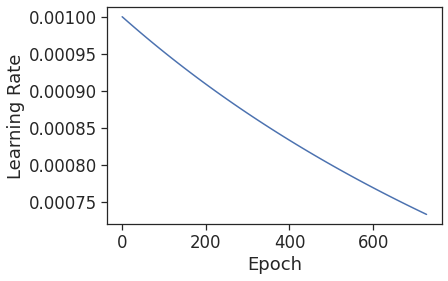

In [ ]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure()
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

###Define model

#### Define loss function

In [ ]:
# The sum of the weights of all examples stays the same.
total = int(len(train_data))
n_class=2

ST_min1=35 
ST_max1=58
ST_range1=train_data.ST[(train_data.ST>ST_min1) & (train_data.ST<ST_max1)].values
n_group1=len(ST_range1)


# ST_min2=37
# ST_max2=45
# ST_range2=train_data.ST[(train_data.ST>ST_min2) & (train_data.ST<ST_max2)].values
n_group2=int(total-len(ST_range1))


# ST_min3=50 #min(train_data.ST)
# ST_max3=54.99
# ST_range3=train_data.ST[(train_data.ST>ST_min3) & (train_data.ST<ST_max3)].values
# n_group3=len(ST_range3)


# ST_min4=45 #min(train_data.ST)
# ST_max4=49.99
# ST_range4=train_data.ST[(train_data.ST>ST_min4) & (train_data.ST<ST_max4)].values
# n_group4=len(ST_range4)

# ST_min5=43 #min(train_data.ST)
# ST_max5=44.99
# ST_range5=train_data.ST[(train_data.ST>ST_min5) & (train_data.ST<ST_max5)].values
# n_group5=len(ST_range5)


# ST_min6=35 #min(train_data.ST)
# ST_max6=42.99
# ST_range6=train_data.ST[(train_data.ST>ST_min6) & (train_data.ST<ST_max6)].values
# n_group6=len(ST_range6)




weight_for_group1 = (1/n_group1)*(total/n_class) 
weight_for_group2 = (1/n_group2)*(total/n_class)
# weight_for_group3 = (1/n_group3)*(total/n_class)
# weight_for_group4 = (1/n_group4)*(total/n_class)
# weight_for_group5 = (1/n_group5)*(total/n_class)
# weight_for_group6 = (1/n_group6)*(total/n_class)

print(str('Weight for group 1: %.2f' %(weight_for_group1*total)))
print(str('Weight for group 2: %.2f' %(weight_for_group2*total)))
# print(str('Weight for group 3: %.2f' %(weight_for_group3*total)))
# print(str('Weight for group 4: %.2f' %(weight_for_group4*total)))
# print(str('Weight for group 5: %.2f' %(weight_for_group5*total)))
# print(str('Weight for group 6: %.2f' %(weight_for_group6*total)))

Weight for group 1: 31481.23
Weight for group 2: 39174.43


In [ ]:
weight_for_group1*n_group1, weight_for_group2*n_group2  #, weight_for_group3*n_group3, weight_for_group4*n_group4, weight_for_group5*n_group5, weight_for_group6*n_group6

(11677.0, 11677.0)

In [ ]:
def custom_loss(y_actual,y_pred):

    custom_loss_1 = weight_for_group1 * kb.square(y_actual-y_pred) # Where the ST is in the range of group 1, use the weight for group 1 times the square of the error
    custom_loss_2 = weight_for_group2 * kb.square(y_actual-y_pred) # Where the ST is in the range of group 2, use the weight for group 1 times the square of the error
    custom_loss_tensor = tf.where(tf.math.logical_and(y_actual > min_max_norm(ST_min1)['ST'], y_actual < min_max_norm(ST_max1)['ST']), custom_loss_1, custom_loss_2) # where the true label is 1, use the one with the 1-weight, otherwise use the one with the 0-weight
    custom_loss = tf.math.reduce_sum(custom_loss_tensor) # Sum all of them so that we get a single number for the loss
    # print("Loss = ", custom_loss)
    
    return custom_loss

In [ ]:
# From: https://towardsdatascience.com/custom-loss-function-in-tensorflow-2-0-d8fa35405e4e
# https://www.tensorflow.org/api_docs/python/tf/where

# From standford lecture notes, https://see.stanford.edu/materials/aimlcs229/cs229-notes1.pdf

# bandwidth=2
# weight=np.exp(-((y_actual-y_pred)^2)/(2*bandwidth^2))

# Making a custom loss function that takes into account the unbalanced dataset by using weights
# def custom_loss(y_actual, y_pred):
#   def loss(y_actual,y_pred):
    # if y_actual>min_max_norm(ST_min1)['ST'] and y_actual<min_max_norm(ST_max1)['ST']:
    #   custom_loss_tensor1=weight_for_group1 * kb.square(y_actual-y_pred) # Where the ST is in the range of group 1, use the weight for group 1 times the square of the error
    # elif y_actual>min_max_norm(ST_min2)['ST'] and y_actual<min_max_norm(ST_max2)['ST']:
    #   custom_loss_tensor2=weight_for_group2 * kb.square(y_actual-y_pred) # Where the ST is in the range of group 2, use the weight for group 2 times the square of the error
    # elif y_actual>min_max_norm(ST_min3)['ST'] and y_actual<min_max_norm(ST_max3)['ST']:
    #   custom_loss_tensor3=weight_for_group3 * kb.square(y_actual-y_pred) # Where the ST is in the range of group 3, use the weight for group 3 times the square of the error
    # elif y_actual>min_max_norm(ST_min4)['ST'] and y_actual<min_max_norm(ST_max4)['ST']:
    #   custom_loss_tensor4=weight_for_group4 * kb.square(y_actual-y_pred) # Where the ST is in the range of group 4, use the weight for group 4 times the square of the error
    # elif y_actual>min_max_norm(ST_min5)['ST'] and y_actual<min_max_norm(ST_max5)['ST']:
    #   custom_loss_tensor5=weight_for_group5 * kb.square(y_actual-y_pred) # Where the ST is in the range of group 5, use the weight for group 5 times the square of the error
    # elif y_actual>min_max_norm(ST_min6)['ST'] and y_actual<min_max_norm(ST_max6)['ST']:
    #   custom_loss_tensor6=weight_for_group6 * kb.square(y_actual-y_pred) # Where the ST is in the range of group 6, use the weight for group 6 times the square of the error
    # else:
    #   custom_loss_tensor7= kb.square(y_actual-y_pred) # Where the ST is in the range of group 6, use the weight for group 6 times the square of the error
  # if custom_loss_tensor1!=None and custom_loss_tensor2!=None and custom_loss_tensor3!=None and custom_loss_tensor4!=None and custom_loss_tensor5!=None and custom_loss_tensor6!=None and custom_loss_tensor7!=None :
  #   custom_loss_tensor=tf.concat([custom_loss_tensor1, custom_loss_tensor2, custom_loss_tensor3, custom_loss_tensor4, custom_loss_tensor5, custom_loss_tensor6, custom_loss_tensor7], 0)

  # custom_loss = tf.math.reduce_sum(custom_loss_tensor) # Sum all of them so that we get a single number for the loss
    # print("Loss = ", custom_loss)
      
  # return custom_loss

### Define neural network architecture

In [26]:
from numpy.random import seed

sseed=0
def build_model(sseed=sseed):
  seed(sseed)
  tf.random.set_seed(sseed)
  model = keras.Sequential([
    layers.Dense(50, activation=tf.nn.swish, input_shape=[len(normed_train_data.keys())]),  #, kernel_regularizer='l2'
    layers.Dense(40, activation=tf.nn.softplus),
    layers.Dense(30, activation=tf.nn.swish),
    layers.Dense(20, activation=tf.nn.softplus), 
    layers.Dense(15, activation=tf.nn.swish),
    layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',  #custom_loss,
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def get_optimizer():
  return tf.keras.optimizers.Adam()

In [ ]:
# from typing_extensions import Concatenate
# from numpy.random import seed

# sseed=50
# def build_model():
#   seed(sseed)
#   tf.random.set_seed(sseed)
#   Input(shape=(FLAGS.max_tlen, FLAGS.tset_size))
#   # model = keras.Sequential()
#   x=model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=[points]))
#   x=model.add(layers.Conv2D(32, (3, 3), activation='relu'))
#   x=model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#   x=model.add(layers.Dropout(0.25))
#   x=model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
#   x=model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#   x=model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#   x=model.add(layers.Dropout(0.25))

#   x=model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
#   x=model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#   x=model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#   x=model.add(layers.Dropout(0.25))

#   x=model.add(layers.Flatten())
  
#   x2=model.add(layers.Concatenate(axis=1)[train_data.volt, x])
#   model.add(layers.Dense(512, activation='relu'))
#   model.add(layers.Dropout(0.5))
#   model.add(layers.Dense(40, activation='softmax'))
#   model.add(layers.Dense(10, activation=tf.nn.softplus))
#   model.add(layers.Dense(1))

#   optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
#   model.compile(loss='mean_squared_error' ,  #custom_loss
#                 optimizer=optimizer,
#                 metrics=['mean_absolute_error', 'mean_squared_error'])
#   return model

# def get_optimizer():
#   return tf.keras.optimizers.Adam()

In [27]:
model = build_model()

#### If there is a model saved on google drive execute the next block

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.keras.models import load_model

# del model 

folder=str('Experimental_surfactants/')

model_name=str('CTAB_files_7_14_0.37.h5')

model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+folder+model_name))


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 50)                17700     
                                                                 
 dense_25 (Dense)            (None, 40)                2040      
                                                                 
 dense_26 (Dense)            (None, 30)                1230      
                                                                 
 dense_27 (Dense)            (None, 20)                620       
                                                                 
 dense_28 (Dense)            (None, 15)                315       
                                                                 
 dense_29 (Dense)            (None, 10)                160       
                                                                 
 dense_30 (Dense)            (None, 5)                

In [ ]:
model.get_config()


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [28]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.06576108],
       [-0.07072357],
       [-0.06709914],
       [-0.06778815],
       [-0.07416756],
       [-0.0740826 ],
       [-0.06553473],
       [-0.07223454],
       [-0.06896845],
       [-0.07098768]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [29]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 879 # 1283

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

# my_callbacks=tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[PrintDot()]) #early_stop, 



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................................

### Prunning algorithm 

In [ ]:
# #Prunning algorithm

# import tensorflow_model_optimization as tfmot
# import tempfile

# prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# # Compute end step to finish pruning after 2 epochs.
# all_instances = len(dataset)
# epochs = 1000
# validation_split = 0.2 # 10% of training set will be used for validation set. 

# train_instances = len(normed_train_data) * (1 - validation_split)
# end_step = np.ceil(train_instances / all_instances).astype(np.int32) * epochs

# # Define model for pruning.
# pruning_params = {
#       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
#                                                                final_sparsity=0.80,
#                                                                begin_step=0,
#                                                                end_step=end_step)
# }

# model_for_pruning = prune_low_magnitude(model, **pruning_params)

# # `prune_low_magnitude` requires a recompile.
# model_for_pruning.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['mean_absolute_error', 'mean_squared_error'])

# # model_for_pruning.summary()


# ### Train and evaluate the model against baseline
# logdir = tempfile.mkdtemp()

# callbacks = [
#   tfmot.sparsity.keras.UpdatePruningStep(),
#   tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
# ]

# model_for_pruning.fit(normed_train_data, train_labels,
#                   epochs=epochs, validation_split=validation_split,
#                   callbacks=callbacks)

# _, model_for_pruning_MAE = model_for_pruning.evaluate(
#    normed_test_data, test_labels, verbose=0)

# _, baseline_model_MAE = model.evaluate(
#     normed_test_data, test_labels, verbose=0)

# print('Baseline test accuracy:', baseline_model_MAE) 
# print('Pruned test accuracy:', model_for_pruning_MAE)

### Visualize weights

In [ ]:
weights=model.get_weights()
weights[1].shape[0]
# [len(normed_train_data.keys())]

50

In [ ]:
layers=model.layers
# a=tf.convert_to_tensor(layers[0])
# cw1 = np.array(a.get_weights())

In [ ]:

layer_a = tf.keras.layers.Dense(1, kernel_initializer=tf.constant_initializer(1.))
# a_out = layer_a(tf.convert_to_tensor([[1., 2., 3.]]))
# layer_a.get_weights()

# print(layer_a) 
# print(layers[0])
# layers[0](tf.convert_to_tensor([[10., 20., 30.]]))

**get_weights method**

Layer.get_weights()

Returns the current weights of the layer, as NumPy arrays.

The weights of a layer represent the state of the layer. This function returns both trainable and non-trainable weight values associated with this layer as a list of NumPy arrays, which can in turn be used to load state into similarly parameterized layers.

For example, a Dense layer returns a list of two values: the kernel matrix and the bias vector. These can be used to set the weights of another Dense layer

[source](https://https://keras.io/api/layers/base_layer/)

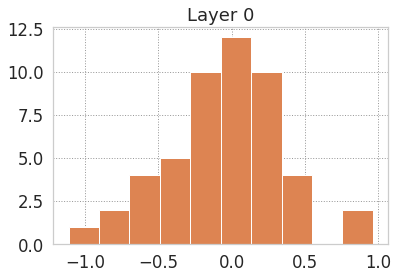

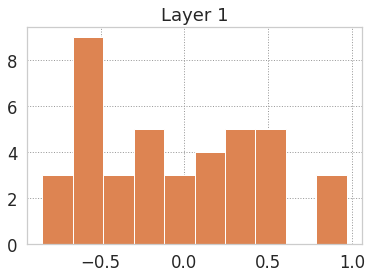

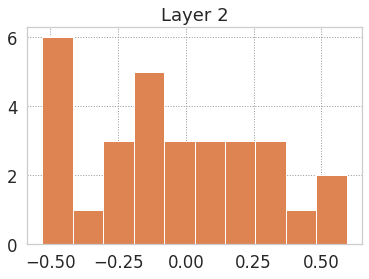

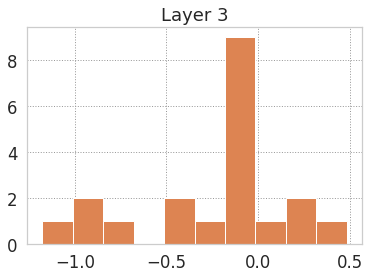

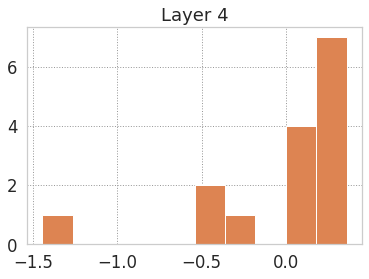

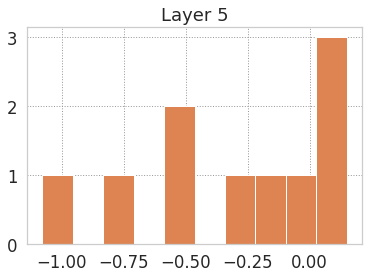

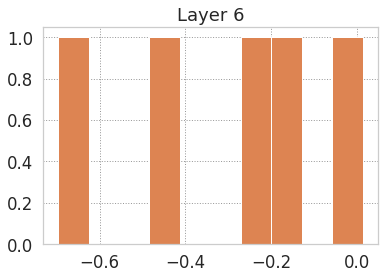

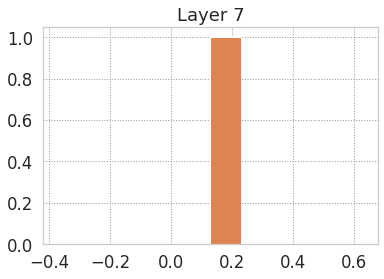

In [ ]:
## Bias? Activation?
for i in range(1, len(weights), 2):
  plt.figure()
  plt.title('Layer %d' %int(i/2))
  plt.hist(weights[i].flatten(), bins=10)
  plt.hist(weights[i].flatten(), bins=10)


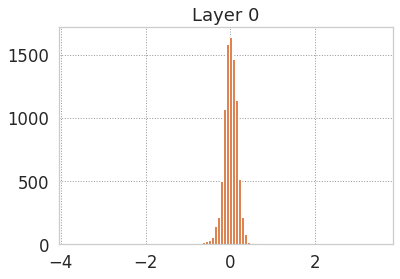

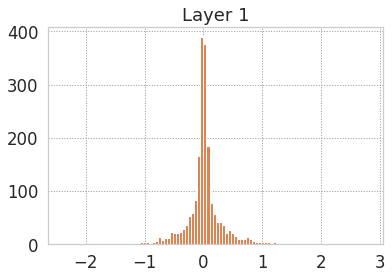

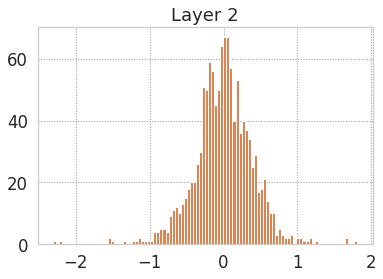

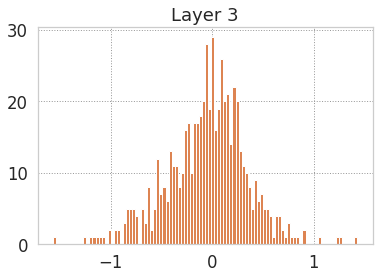

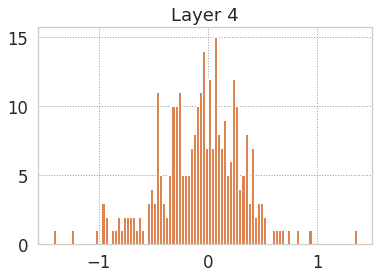

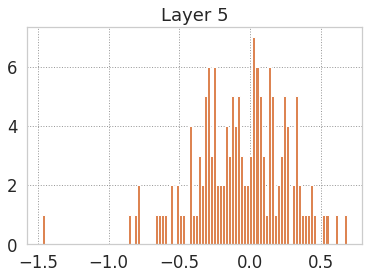

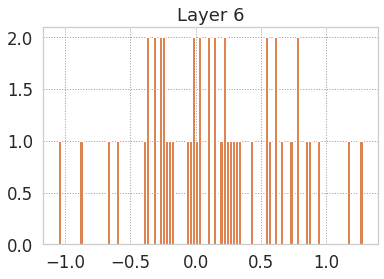

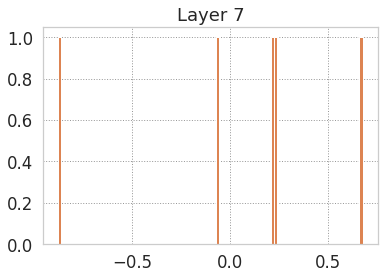

In [ ]:
for i in range(0, len(weights), 2):
  plt.figure()
  plt.title('Layer %d' %int(i/2))
  plt.hist(weights[i].flatten(), bins=100)
  plt.hist(weights[i].flatten(), bins=100)

In [ ]:
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()
import tensorflow.compat.v2 as tf

input_size=len(normed_train_data.keys())

X = tf1.placeholder(tf.float32, [None, input_size], name="input_x")
x_image = tf.reshape(X, [-1, 6, 10, 1])
tf.summary.image('input', x_image, 4)

# First layer of weights
# with tf.name_scope("layer1"):
#     W1 = tf.get_variable("W1", shape=[input_size, weights[0].shape[1]]) #initializer=tf2.contrib.layers.xavier_initializer()
#     layer1 = tf.matmul(X, W1)
#     layer1_act = tf.nn.tanh(layer1)
#     tf.summary.histogram("weights", W1)
#     tf.summary.histogram("layer", layer1)
#     tf.summary.histogram("activations", layer1_act)

# Second layer of weights
# with tf.name_scope("layer2"):
#     W2 = tf.get_variable("W2", shape=[weights[2].shape[0], weights[2].shape[1]],
#                          initializer=tf2.contrib.layers.xavier_initializer())
#     layer2 = tf.matmul(layer1_act, W2)
#     layer2_act = tf.nn.tanh(layer2)
#     tf.summary.histogram("weights", W2)
#     tf.summary.histogram("layer", layer2)
#     tf.summary.histogram("activations", layer2_act)

# # Third layer of weights
# with tf.name_scope("layer3"):
#     W3 = tf.get_variable("W3", shape=[weights[4].shape[0], weights[4].shape[1]],
#                          initializer=tf2.contrib.layers.xavier_initializer())
#     layer3 = tf.matmul(layer2_act, W3)
#     layer3_act = tf.nn.tanh(layer3)

#     tf.summary.histogram("weights", W3)
#     tf.summary.histogram("layer", layer3)
#     tf.summary.histogram("activations", layer3_act)

# # Fourth layer of weights
# with tf.name_scope("layer4"):
#     W4 = tf.get_variable("W4", shape=[weights[6].shape[0], weights[6].shape[1]],
#                          initializer=tf2.contrib.layers.xavier_initializer())
#     Qpred = tf.nn.softmax(tf.matmul(layer3_act, W4)) # Bug fixed: Qpred = tf.nn.softmax(tf.matmul(layer3, W4))
#     tf.summary.histogram("weights", W4)
#     tf.summary.histogram("Qpred", Qpred)

# # We need to define the parts of the network needed for learning a policy
# Y = tf1.placeholder(tf.float32, [None, 1], name="input_y")
# advantages = tf1.placeholder(tf.float32, name="reward_signal")

# # Loss function
# # Sum (Ai*logp(yi|xi))
# log_lik = -Y * tf.log(Qpred)
# loss = tf.reduce_mean(tf.reduce_sum(log_lik * advantages, axis=1))
# tf.summary.scalar("Q", tf.reduce_mean(Qpred))
# tf.summary.scalar("Y", tf.reduce_mean(Y))
# tf.summary.scalar("log_likelihood", tf.reduce_mean(log_lik))
# tf.summary.scalar("loss", loss)

# # Learning
# train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

### Training history and performance

Visualize the model's training progress using the stats stored in the `history` object.

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

loss  mean_absolute_error  mean_squared_error  val_loss  \
874  0.001689             0.026135            0.001689  0.001829   
875  0.002802             0.032373            0.002802  0.003948   
876  0.002048             0.028185            0.002048  0.001978   
877  0.002604             0.030518            0.002604  0.001962   
878  0.002218             0.028825            0.002218  0.001414   

     val_mean_absolute_error  val_mean_squared_error  epoch  
874                 0.026624                0.001829    874  
875                 0.037089                0.003948    875  
876                 0.027308                0.001978    876  
877                 0.027541                0.001962    877  
878                 0.023721                0.001414    878

In [ ]:
min_train_error=find_nearest(hist.mean_squared_error, min(hist.mean_squared_error))
min_val_error=find_nearest(hist.val_mean_squared_error, min(hist.val_mean_squared_error))

if min_val_error[1] > min_train_error[1]:
  min_train_val_diff=find_nearest(hist.val_mean_squared_error[ min_train_error[1]: min_val_error[1]]-hist.mean_squared_error[ min_train_error[1]: min_val_error[1]], min(abs(hist.val_mean_squared_error[ min_train_error[1]: min_val_error[1]]-hist.mean_squared_error[ min_train_error[1]: min_val_error[1]])))
elif min_val_error[1] < min_train_error[1]:
  min_train_val_diff=find_nearest(hist.val_mean_squared_error[ min_val_error[1]: min_train_error[1]]-hist.mean_squared_error[ min_val_error[1]: min_train_error[1]], min(abs(hist.val_mean_squared_error[ min_val_error[1]: min_train_error[1]]-hist.mean_squared_error[ min_val_error[1]: min_train_error[1]])))
else:
  min_train_val_diff=min_val_error


print('Min train MSE: %.8f, index: %d' %(min_train_error[0], min_train_error[1]))

print('Min val MSE: %.8f, index: %d' %(min_val_error[0], min_val_error[1]))

print('Diff train-val MSE at min val MSE %.8f: '%(hist.mean_squared_error[min_val_error[1]] - min_val_error[0]))

if min_val_error[1] > min_train_error[1]:
  idx=min_train_error[1] + min_train_val_diff[1]
  print('Min diff train-val MSE: %.8f, index: %d, train MSE: %.8f' %(min_train_val_diff[0],  idx, hist.mean_squared_error[idx]))
elif min_val_error[1] < min_train_error[1]:
  idx=min_val_error[1] + min_train_val_diff[1]
  print('Min diff train-val MSE: %.8f, index: %d, train MSE: %.8f' %(min_train_val_diff[0],  idx, hist.mean_squared_error[idx]))
else:
  print('Min diff train-val MSE: %.8f, index: %d' %(min_train_val_diff[0],  min_val_error[1] + min_train_val_diff[1]))




Min train MSE: 0.00167249, index: 854
Min val MSE: 0.00141389, index: 878
Diff train-val MSE at min val MSE 0.00080458: 
Min diff train-val MSE: -0.00001729, index: 865, train MSE: 0.00201620


In [31]:
## Re-scale target feature
def rescaling(target, min=stats.loc['ST']['min'], max=stats.loc['ST']['max']):
  target=np.asarray(target)
  return (max-min)*(target)+min

test_predictions = model.predict(normed_test_data).flatten()
train_predictions = model.predict(normed_train_data).flatten()

ST_real_test=rescaling(test_labels)
ST_pred_test=rescaling(test_predictions)

ST_real_train=rescaling(train_labels)
ST_pred_train=rescaling(train_predictions)  

#Re-scalling check:
# plt.figure(figsize=(8,6))
# plt.scatter(range(len(test_labels)), test_labels)
# plt.ylabel('Normalizaed surface tension')
# plt.xlabel('Instances')

# plt.figure(figsize=(8,6))
# plt.scatter(range(len(ST_real_test)), ST_real_test)
# plt.ylabel('Surface tension (mN/m)')
# plt.xlabel('Instances')

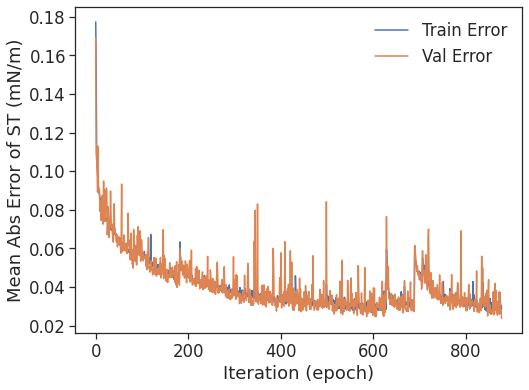

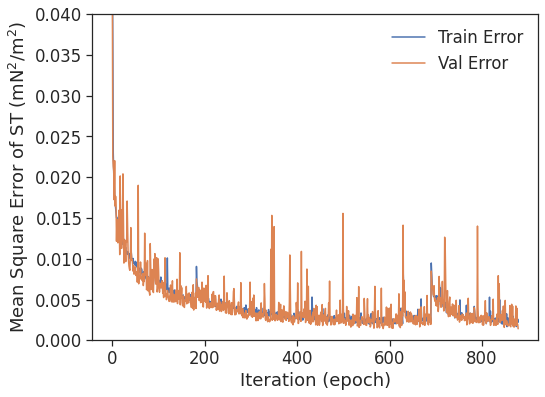

In [39]:

def plot_history(history, savefig=True, path=''):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  sns.set_theme(style='ticks', font_scale=1.5)
  
  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  # plt.ylim([0,0.2])
  plt.legend(frameon=False)
  if savefig==True:
    plt.savefig(path+'training_outcome_MAE_svg', dpi=300, format='svg')
    plt.savefig(path+'training_outcome_MAE_png', dpi=300, format='png')


  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,0.04])
  plt.legend(frameon=False)
  if savefig==True:
    plt.savefig(path+'training_outcome_MSE_svg', dpi=300, format='svg')
    plt.savefig(path+'training_outcome_MSE_png', dpi=300, format='png')

path='/content/drive/My Drive/DropLev/for_draft/Experimental/Figures/'

plot_history(history, savefig=False, path=path)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
# loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

# print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

# print("Testing set Mean Abs Error over ST range: {:5.2f}".format(mae/(max(dataset.ST)-min(dataset.ST))))


### Make predictions

Finally, predict ST values using data in the testing set:

In [33]:
def density_scatter(x, y, title=None, label=None, colours='magma_r', lim1=10, lim2=80, eq_sq=True, figsize=(8,8)):
  # Calculate the point density
  x=np.asarray(x)
  y=np.asarray(y)
  xy = np.vstack([x, y])
  z = gaussian_kde(xy)(xy)
  # Sort the points by density, so that the densest points are plotted last
  idx = z.argsort()
  x, y, z = x[idx], y[idx], z[idx]

  fig, ax = plt.subplots(figsize=figsize)
  ax.set_facecolor('whitesmoke')
  if title!=None:
    plt.title(title)
  im=ax.scatter(x, y, label=label, c=z, s=50, cmap=colours)
  plt.xlabel('True Values of ST (mN/m)')
  plt.ylabel('Predictions of ST (mN/m)')
  if eq_sq==True:
    plt.axis('equal')
    plt.axis('square')
  # plt.xlim([lim1, lim2])
  # plt.ylim([lim1, lim2])
  norm = Normalize(vmin = np.min(z), vmax = np.max(z))
  cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=colours), ax=ax)
  cbar.ax.set_ylabel('Density')


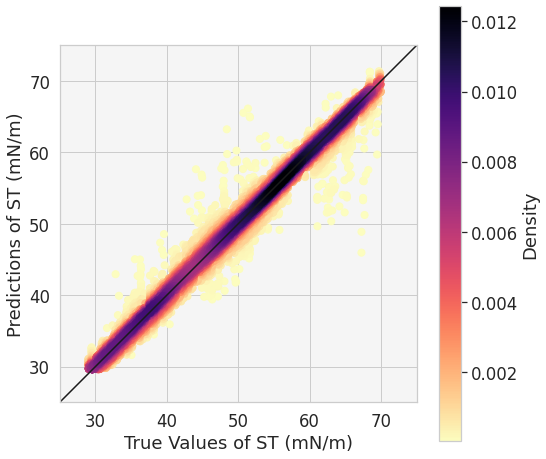

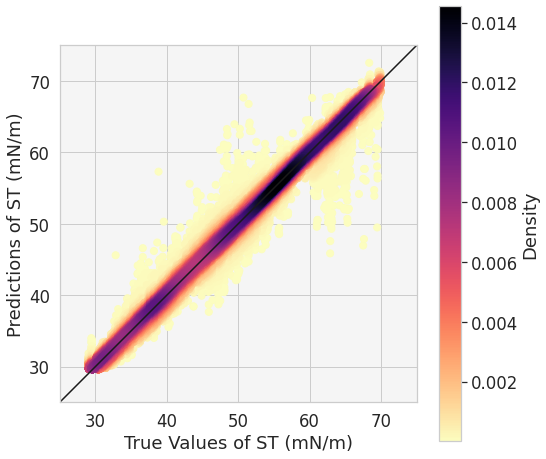

In [34]:

savefig=False

sns.set_theme(style='whitegrid', font_scale=1.5, color_codes=False)

colours='magma_r'
figtype='svg'


density_scatter(ST_real_test, ST_pred_test, colours=colours)
_ = plt.plot([-100, 100], [-100, 100], 'k')
plt.xlim(25, 75)
plt.ylim(25, 75)
if savefig==True:
  plt.savefig(path+'test_data_error_plot_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_plot_png', dpi=300, format='png')


density_scatter(ST_real_train, ST_pred_train, colours=colours)
_ = plt.plot([-100, 100], [-100, 100], 'k')
plt.xlim(25, 75)
plt.ylim(25, 75)
if savefig==True:
  plt.savefig(path+'training_data_error_plot_svg', dpi=300, format='svg')
  plt.savefig(path+'training_data_error_plot_png', dpi=300, format='png')




Error distribution

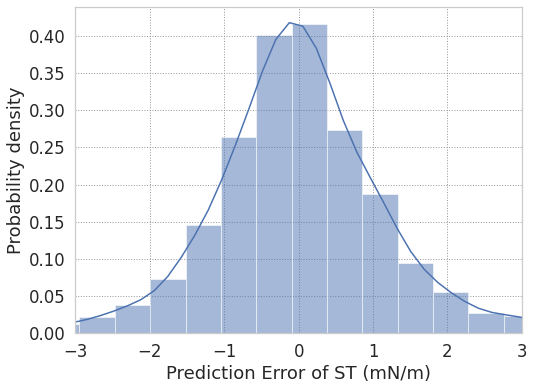

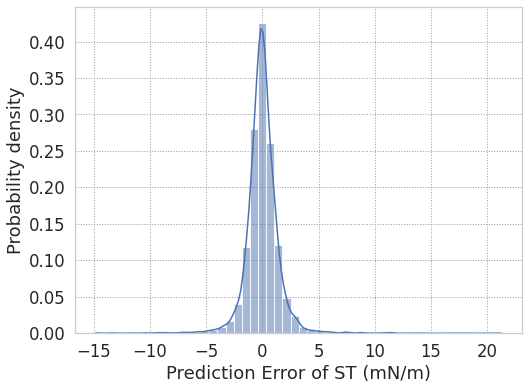

In [35]:
error_test = ST_real_test - ST_pred_test

sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
savefig=False

plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 76, kde=True, stat="density")
plt.xlabel("Prediction Error of ST (mN/m)")
_ = plt.ylabel("Probability density")
plt.xlim(-3, 3)
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_distr_lim_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_distr_lim_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error of ST (mN/m)")
_ = plt.ylabel("Probability density")
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_distr_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_distr_png', dpi=300, format='png')



In [36]:
#Confidence:

error_test_test=np.asarray(error_test)

rows_05=error_test_test[(error_test_test >= -0.5) & (error_test_test <= 0.5)]
rows_1=error_test_test[(error_test_test >= -1) & (error_test_test <= 1)]
rows_2=error_test_test[(error_test_test >= -2) & (error_test_test <= 2)]


print('Confidence for error '+u"\u00B1"+' 0.5 mN/m: %.2f' %int(len(rows_05)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 1 mN/m: %.2f' %int(len(rows_1)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 2 mN/m: %.2f' %int(len(rows_2)/len(error_test)*100)+ ' %')

print('Mean Absolute error: %.2f mN/m' %(sum(abs(error_test_test))/len(error_test_test)))


Confidence for error ± 0.5 mN/m: 40.00 %
Confidence for error ± 1 mN/m: 66.00 %
Confidence for error ± 2 mN/m: 89.00 %
Mean Absolute error: 0.97 mN/m


In [ ]:
# error_test = ST_pred_test - ST_real_test
# error_train = ST_pred_train - ST_real_train

# st_min=int(min(ST_real_train))-1
# st_max=int(max(ST_real_train))+1

# sns.set_theme(style='ticks', font_scale=1.5)

# plt.figure(figsize=(8,6))
# plt.title('Test dataset')
# plt.plot(ST_real_test, error_test, 'o')
# plt.plot(range(st_min, st_max), np.repeat(0, (st_max-st_min)), '--r')
# plt.ylabel('Error (mN/m)')
# plt.xlabel('Surface tension (mN/m)')

# plt.figure(figsize=(8,6))
# plt.title('Train dataset')
# plt.plot(ST_real_train, error_train, 'o')
# plt.plot(range(st_min, st_max), np.repeat(0, (st_max-st_min)), '--r')
# plt.ylabel('Error (mN/m)')
# plt.xlabel('Surface tension (mN/m)')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

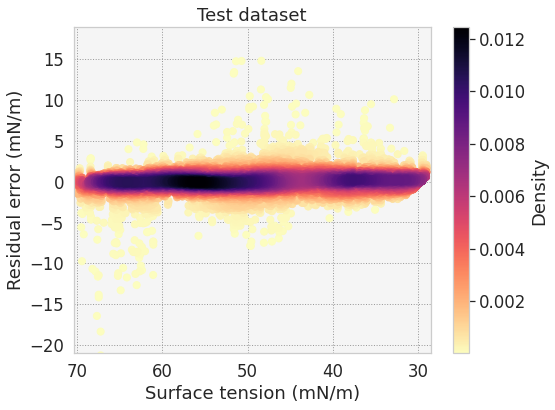

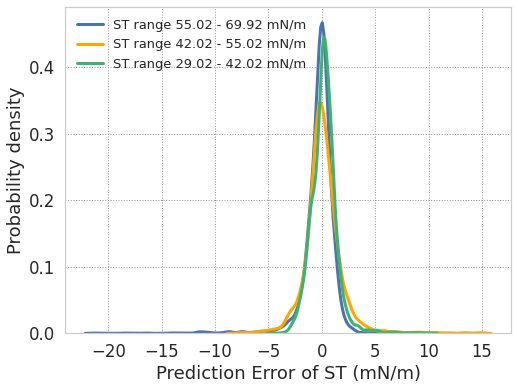

In [37]:
savefig=False


error_test = ST_pred_test - ST_real_test
error_train = ST_pred_train - ST_real_train

density_scatter(ST_real_test, error_test, title='Test dataset', colours=colours, eq_sq=False, figsize=(8,6))
plt.ylim(min(error_train)-0.5, max(error_train)+0.5)
plt.xlim(min(ST_real_train)-0.5, max(ST_real_train)+0.5)
plt.gca().invert_xaxis()
plt.ylabel('Residual error (mN/m)')
plt.xlabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'error_Vs_ST_test_data_'+figtype, dpi=300, format=figtype)


# density_scatter(ST_real_train, error_train, title='Train dataset', colours=colours, eq_sq=False, figsize=(8,6))
# plt.ylim(min(error_train)-0.5, max(error_train)+0.5)
# plt.xlim(min(ST_pred_test)-0.5, max(ST_pred_test)+0.5)
# plt.gca().invert_xaxis()
# plt.ylabel('Residual error (mN/m)')
# plt.xlabel('Surface tension (mN/m)')
# if savefig==True:
#   plt.savefig(path+'error_Vs_ST_training_data_'+figtype, dpi=300, format=figtype)


check_test_df=pd.DataFrame(data={'True_values': ST_real_test, 'Predictions': ST_pred_test})

sorted_st=check_test_df.sort_values(by=['True_values'], ascending=False)

# sns.set_theme(style='ticks', font_scale=1.5)

# density_scatter(range(len(sorted_st)), sorted_st.True_values, title='Real values', colours=colours, eq_sq=False, figsize=(10,6))
# plt.xlabel('Instance')
# plt.ylabel('Surface tension (mN/m)')
# if savefig==True:
#   plt.savefig(path+'real_test_St_sorted_svg', dpi=300, format='svg')
#   plt.savefig(path+'real_test_St_sorted_png', dpi=300, format='png')

# density_scatter(range(len(sorted_st)), sorted_st.Predictions, title='Predicted values', colours=colours,  eq_sq=False, figsize=(10,6))
# plt.xlabel('Instance')
# plt.ylabel('Surface tension (mN/m)')
# if savefig==True:
#   plt.savefig(path+'pred_test_St_sorted_svg', dpi=300, format='svg')
#   plt.savefig(path+'pred_test_St_sorted_png', dpi=300, format='png')


# density_scatter(range(len(sorted_st)), sorted_st.Predictions-sorted_st.True_values, title='Prediction error', colours=colours,  eq_sq=False, figsize=(10,6))
# plt.xlabel('Instance')
# plt.ylabel('Surface tension (mN/m)')
# if savefig==True:
#   plt.savefig(path+'pred_error_test_St_sorted_svg', dpi=300, format='svg')
#   plt.savefig(path+'pred_error_test_St_sorted_png', dpi=300, format='png')


step=int((max(sorted_st.True_values)-min(sorted_st.True_values))/3)

trial_1=sorted_st.loc[(sorted_st['True_values'] >= min(sorted_st.True_values)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step))]
trial_2=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step*2))]
trial_3=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step*2)) & (sorted_st['True_values'] <= max(sorted_st.True_values))]

thickness=3
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

savefig=True

plt.figure(figsize=(8,6))
sns.distplot(trial_3.Predictions-trial_3.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step*2, max(sorted_st.True_values)))
sns.distplot(trial_2.Predictions-trial_2.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='orange', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step, min(sorted_st.True_values)+step*2))
sns.distplot(trial_1.Predictions-trial_1.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='mediumseagreen', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values), min(sorted_st.True_values)+step))
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.legend(frameon=False, prop={"size":13})
# plt.xlim(-5, 5)
if savefig==True:
  plt.savefig(path+'test_data_error_distr_steps_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_distr_steps_png', dpi=300, format='png')



In [ ]:

savefig=False
date=20220329



#Define data-frames with ST, concentration and surfactant number for the dataset + error for the predictions
table_data=pd.DataFrame(np.vstack([dataset.ST, dataset.surfactant_conc, dataset.surf_number]).T, columns=['ST', 'surf_conc', 'surf_number'])
table_pred=pd.DataFrame(np.vstack([ST_pred_test, surf_conc_test, error_test, surf_number_test]).T, columns=['ST_pred', 'conc', 'error', 'surf_number'])

#Sort datasets based on concentration
sorted_data=table_data.sort_values(by=['surf_conc'], ascending=True)
Predictions=table_pred.sort_values(by=['conc'], ascending=True)


#Separate ST and concentration values of each surfactant
data_SDS=sorted_data[sorted_data.surf_number==0]
data_CTAB=sorted_data[sorted_data.surf_number==1]
data_TX100=sorted_data[sorted_data.surf_number==2]


#Separate predictions of each surfactant
pred_SDS=Predictions[Predictions.surf_number==0]
pred_CTAB=Predictions[Predictions.surf_number==1]
pred_TX100=Predictions[Predictions.surf_number==2]

#Randmolly choose n amount of points
seed=1
n=100
plotted_pred_SDS=pred_SDS.sample(n, random_state=seed)
plotted_pred_CTAB=pred_CTAB.sample(n, random_state=seed)
plotted_pred_TX100=pred_TX100.sample(n, random_state=seed)


#Plot isotherm of each surfactant
plt.figure(figsize=(8,6))
plt.semilogx(data_SDS.surf_conc, data_SDS.ST, '-o',  label='True values')
plt.scatter(plotted_pred_SDS.conc, plotted_pred_SDS.ST_pred, marker='x', color='r', label='Predictions')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(1, 15.5)
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'SDS_isotherm_predictions_%d_svg' %date, dpi=300, format='svg')
  plt.savefig(path+'SDS_isotherm_predictions_%d_png' %date, dpi=300, format='png')



plt.figure(figsize=(8,6))
plt.semilogx(data_CTAB.surf_conc, data_CTAB.ST, '-o', label='True values')
plt.scatter(plotted_pred_CTAB.conc, plotted_pred_CTAB.ST_pred, marker='x', color='r', label='Predictions')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(0.1, 1.4)
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'CTAB_isotherm_predictions_%d_svg' %date, dpi=300, format='svg')
  plt.savefig(path+'CTAB_isotherm_predictions_%d_png' %date, dpi=300, format='png')


plt.figure(figsize=(8,6))
plt.semilogx(data_TX100.surf_conc, data_TX100.ST, '-o',  label='True values')
plt.scatter(plotted_pred_TX100.conc, plotted_pred_TX100.ST_pred, marker='x', color='r', label='Predictions')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(0.015, 0.8)
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'TX100_isotherm_predictions_%d_svg' %date, dpi=300, format='svg')
  plt.savefig(path+'TX100_isotherm_predictions_%d_png' %date, dpi=300, format='png')


# ST_lim1=0.15 # TritonX: 0.45, SDS: 6   CTAB: 0.85
# ST_lim2=0.28  # TritonX: 0.80, SDS: 9.5   CTAB: 0.95

# ST_lim3=0.3 # TritonX: 0.9, SDS:10.2   CTAB: 1
# ST_lim4=0.6  # TritonX: 1.2, SDS:12.7   CTAB: 1.3

# lower=Predictions[(Predictions['conc'] > ST_lim1) & (Predictions['conc'] <ST_lim2)]
# higher=Predictions[(Predictions['conc'] > ST_lim3) & (Predictions['conc'] <ST_lim4)]

# slope1, intercept1, r1, p1, se1 = linregress(lower.conc, lower.ST_pred)
# slope2, intercept2, r2, p2, se2 = linregress(higher.conc, higher.ST_pred)

# cross_conc=(intercept2-intercept1)/(slope1-slope2)
# cross_ST=slope2*cross_conc+intercept2

# plt.figure(figsize=(8,6))
# density_scatter(Predictions.conc, Predictions.ST_pred, colours=colours,  eq_sq=False, figsize=(10,6))
# plt.plot(lower.conc, slope1*lower.conc+intercept1, '--', color='#577dc6', linewidth=3.5)
# plt.plot(higher.conc, slope2*higher.conc+intercept2, '--', color='#577dc6', linewidth=3.5)
# plt.plot(cross_conc, cross_ST, 'o', color='#577dc6', markersize=12, label='CMC=%.3f mM' %cross_conc)
# # plt.ylim(35,42)
# plt.ylabel('Surface tension (mN/m)')
# plt.xlabel('Concentration (mM)')
# plt.legend(loc='upper right', frameon=False)
# if savefig==True:
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_svg' %file, dpi=300, format='svg')
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_png' %file, dpi=300, format='png')

####### Error bars #######

# conc_lim=0.1  #TritonX: 0.005, SDS: 0.1, CTAB: 0.005
# error_bars=5
# sorted_predictions= Predictions.ST_pred.sort_values(ignore_index=True,  ascending=False)
# errorx=np.linspace(min(Predictions['conc']), max(Predictions['conc']), error_bars)

# yerror_range={}
# yerror=[]
# errory=[]

# for i in range(len(errorx)):
#   yerror_range[i]=Predictions[(Predictions['conc'] > errorx[i]-conc_lim) & (Predictions['conc'] <errorx[i]+conc_lim)].ST_pred
#   yerror.append((max(yerror_range[i])-min(yerror_range[i]))/2)
#   errory.append(np.mean(yerror_range[i]))


# yerror=np.asarray(yerror)
# errory=np.asarray(errory)

# plt.figure(figsize=(8,6))
# plt.plot(Predictions.conc, sorted_predictions, 'b')
# plt.plot(lower.conc, slope1*lower.conc+intercept1, '--k', linewidth=3)
# plt.plot(higher.conc, slope2*higher.conc+intercept2, '--k', linewidth=3)
# plt.plot(cross_conc, cross_ST, 'or', label='CMC=%.3f' %cross_conc)
# plt.errorbar(errorx, errory, yerr=yerror,  fmt='.k')
# plt.xlabel('Instances',fontsize=14)
# plt.ylabel('Surface tension (mN/m)',fontsize=18)
# plt.legend(loc='upper right', frameon=False)
# if savefig==True:
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_error_bars_50percent_svg' %file, dpi=300, format='svg')
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_error_bars_50percent_png' %file, dpi=300, format='png')



In [ ]:
test_df=test_data.copy()
test_df['pred']=ST_pred_test
test_df['error']=error_test

plt.figure()
plt.plot(test_df.error-(test_df.pred-test_df.ST), 'o')

In [ ]:
#Overestimation

overest_df=test_df[error_test>0.5]
overest_df=overest_df[(overest_df.ST>55) & (overest_df.ST<65)]

# overest_df


for i in range(len(overest_df.columns)-2):
  feature=overest_df.columns[i]
  sorted_df=overest_df.sort_values(by=[feature])

  plt.figure()
  plt.plot(sorted_df[feature], sorted_df.error)
  plt.ylabel('Residual error (mN/m)')
  plt.xlabel(feature)




In [ ]:
#Underestimation

underest_df=test_df[error_test<-0.5]
underest_df=underest_df[(underest_df.ST>60) & (underest_df.ST<70)]

# underest_df

for i in range(len(underest_df.columns)-2):
  feature=underest_df.columns[i]
  sorted_df=underest_df.sort_values(by=[feature])

  plt.figure()
  plt.plot(sorted_df[feature], sorted_df.error)
  plt.gca().invert_yaxis()
  plt.ylabel('Residual error (mN/m)')
  plt.xlabel(feature)


### Feature importance

In [ ]:

#Define number of features/columns
featureNum=normed_test_data.shape[1]

#Define feature/column names
ColumnName=normed_test_data.columns

#Rescalling test labels
ST_real_test=rescaling(test_labels)

#Define a dictionary to save the error
error_test={}
MAE={}
Conf_05={}
Conf_1={}
Conf_2={}

for i in range(featureNum):
  feature=normed_test_data.iloc[:, i]

  for j in range(0, 100, 33):
    # seed(j)
    # tf.random.set_seed(j)

    #Shuffle one feature j times
    shuffled_feature=shuffle(feature, random_state=j)
    #Reset the indexes of the new column
    shuffled_feature.reset_index(drop=True, inplace=True)

    #Copy the normalized test Dataframe into a new Dataframe
    shuffled_test=normed_test_data.copy()

    #Replace feature with shuffled feature
    shuffled_test[ColumnName[i]]=shuffled_feature

    #Predict on the test data with the shuffled feature
    test_predictions = model.predict(shuffled_test).flatten()

    #Rescalling test predictions with shuffled feature
    ST_pred_test=rescaling(test_predictions)

    error_test[i, j] = ST_real_test - ST_pred_test

    MAE[i, j]=sum(abs(error_test[i, j]))/len(error_test[i, j])

    rows_05=error_test[i, j][(error_test[i, j] >= -0.5) & (error_test[i, j] <= 0.5)]
    rows_1=error_test[i, j][(error_test[i, j] >= -1) & (error_test[i, j] <= 1)]
    rows_2=error_test[i, j][(error_test[i, j] >= -2) & (error_test[i, j] <= 2)]

    Conf_05[i, j]=int(len(rows_05)/len(error_test[i, j])*100)
    Conf_1[i, j]=int(len(rows_1)/len(error_test[i, j])*100)
    Conf_2[i, j]=int(len(rows_2)/len(error_test[i, j])*100)






In [ ]:
trial=pd.DataFrame.from_dict(MAE, orient='index')

trial=np.asarray(trial, dtype=object)

j=0
Mean=[]
Min=[]
Max=[]
step=int(len(trial)/featureNum)
for i in range(featureNum):
  Mean.append(np.mean(trial[j:j+step]))
  Min.append(min(trial[j:j+step]))
  Max.append(max(trial[j:j+step]))
  j=j+step



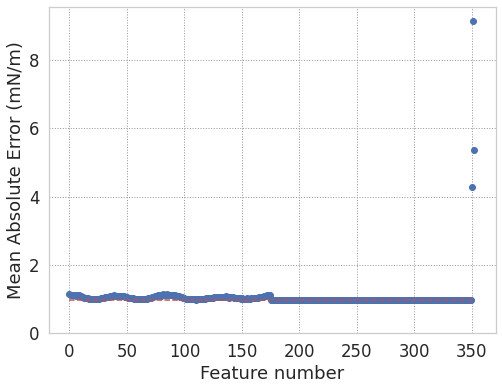

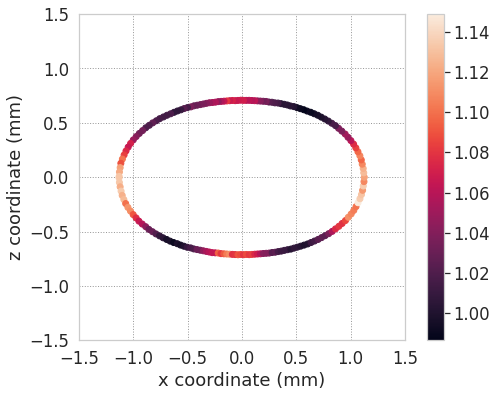

In [ ]:
import matplotlib
savefig=False

# xticks=[0, 158, 174, 175, 249, 349, 350, 351]
# xticksnames=ColumnName[xticks]

mae=sum(abs(error_test_test))/len(error_test_test)

plt.figure(figsize=(8, 6))
plt.plot(range(175), Mean[175:350], 'bo')
plt.plot(range(175, 350), Mean[0:175], 'bo')
plt.plot(range(350, len( Mean)), Mean[350:], 'bo')

# plt.plot(range(featureNum), Mean, 'o')
# plt.xticks(xticks, xticksnames, rotation=90)
plt.plot(range(featureNum+1), np.repeat(mae, featureNum+1), 'r--')
plt.xlabel('Feature number')
plt.ylabel('Mean Absolute Error (mN/m)')
# plt.xlim(349.2, 352)
plt.ylim(0, )
if savefig==True:
  plt.savefig(path+'features_Vs_MAE_exp_svg', dpi=300, format='svg')
  plt.savefig(path+'features_Vs_MAE_exp_png', dpi=300, format='png')

# theta=raw_dataset.iloc[:, 350:525]

# for i in range(80,160, 1):
#   theta.pop('theta_%d' %i)

z_min=min(Mean[points:2*points])
z_max=max(Mean[points:2*points])
fig, ax=plt.subplots(figsize=(8,6))
norm=matplotlib.colors.Normalize(z_min, z_max) #vmin=min(data.Z_center), vmax=max(data.Z_center)
x, y=pol2cart(test_data.iloc[0, 0:175].values, raw_dataset.iloc[0, 175:350].values)
im=plt.scatter(x,y, c=Mean[points:2*points], norm=norm)
plt.colorbar(im, ax=ax)
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
if savefig==True:
  plt.savefig(path+'feature_importance_coloured_coords_exp_svg', dpi=300, format='svg')
  plt.savefig(path+'feature_importance_coloured_coords_exp_png', dpi=300, format='png')

# plt.figure()
# for i in range(featureNum):
#   plt.errorbar(x=i, y=Mean[i], yerr=(Max[i]-Min[i]))
# plt.ylim(0.7, 1.5)

## Error analysis



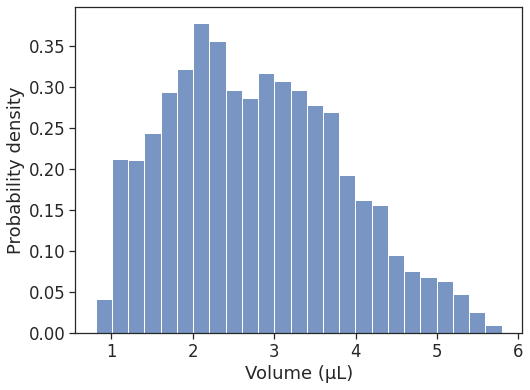

<Figure size 576x432 with 0 Axes>

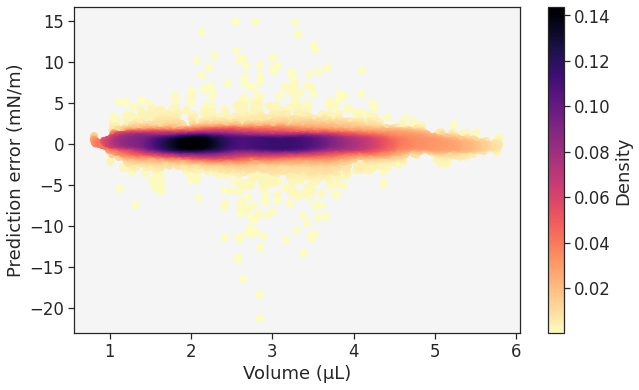

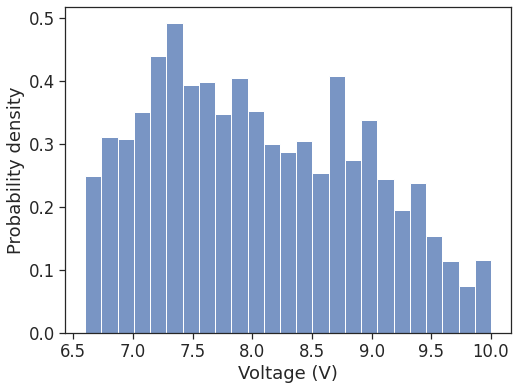

<Figure size 576x432 with 0 Axes>

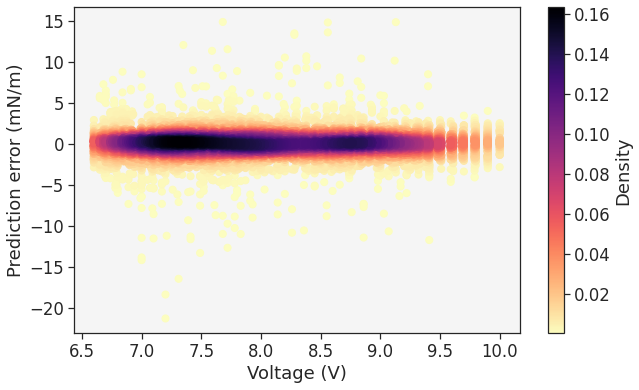

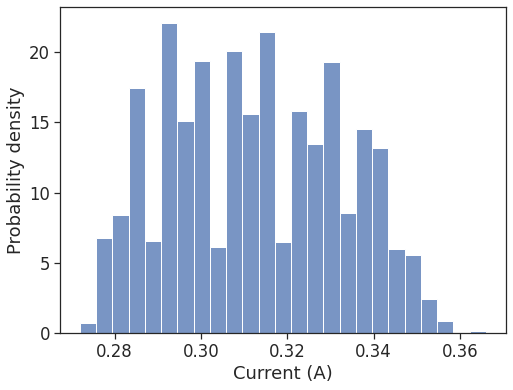

<Figure size 576x432 with 0 Axes>

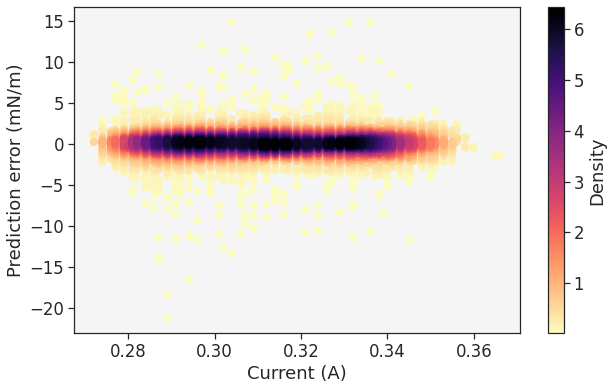

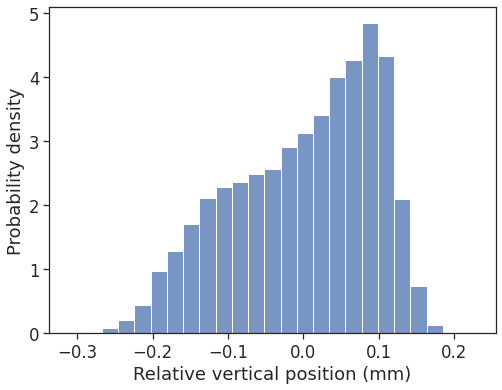

<Figure size 576x432 with 0 Axes>

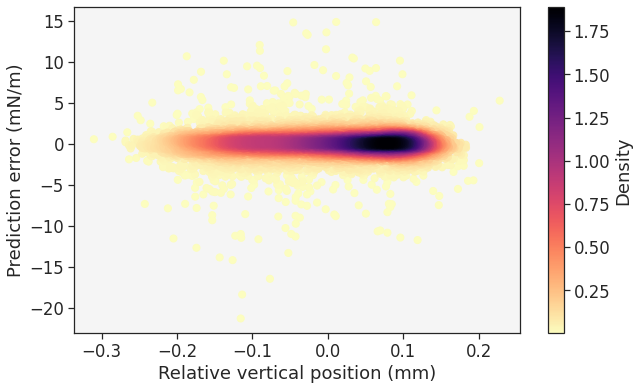

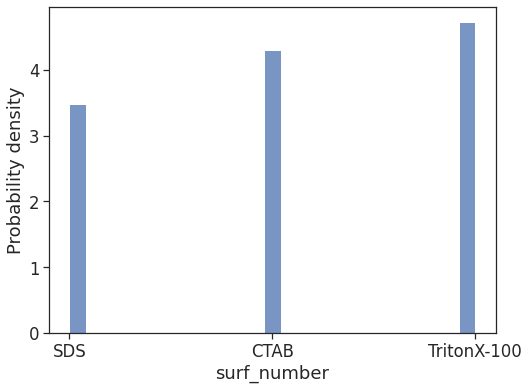

<Figure size 576x432 with 0 Axes>

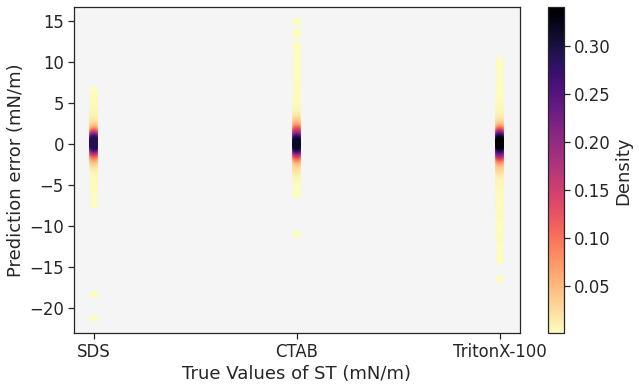

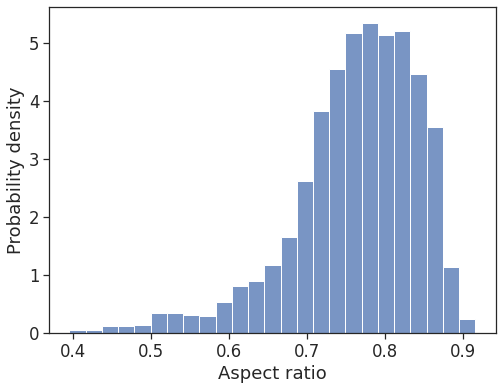

<Figure size 576x432 with 0 Axes>

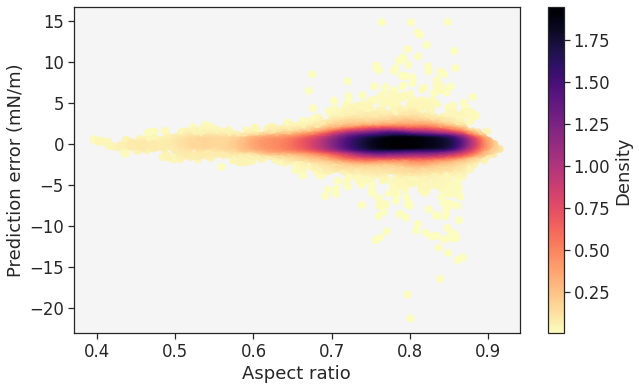

In [45]:
savefig=False
sns.set_theme(style='ticks', font_scale=1.5)

#Volume distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density'),
sns.histplot(volume_test, kde=False, bins=25, stat="density")
plt.xlabel('Volume (μL)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_volume_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_volume_png', dpi=300, format='png')


# Error Vs volume
plt.figure(figsize=(8,6))
density_scatter(volume_test, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xlabel('Volume (μL)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_volume_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_volume_png', dpi=300, format='png')

################################################################################

#Voltage distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(test_data.volt, kde=False, bins=25, stat="density")
plt.xlabel('Voltage (V)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_voltage_png', dpi=300, format='png')


# Error Vs voltage
plt.figure(figsize=(8,6))
density_scatter(test_data.volt, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xlabel('Voltage (V)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_voltage_png', dpi=300, format='png')

################################################################################

#Current distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(test_data.current, kde=False, bins=25, stat="density")
plt.xlabel('Current (A)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_current_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_current_png', dpi=300, format='png')


# Error Vs Current
plt.figure(figsize=(8,6))
density_scatter(test_data.current, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xlabel('Current (A)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_current_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_current_png', dpi=300, format='png')

################################################################################

#Vertical position distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(test_data.centred_z, kde=False, bins=25, stat="density")
plt.xlabel('Relative vertical position (mm)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_vertical_pos_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_vertical_pos_png', dpi=300, format='png')


# Error Vs vertical position
plt.figure(figsize=(8,6))
density_scatter(test_data.centred_z, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xlabel('Relative vertical position (mm)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_vertical_pos_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_vertical_pos_png', dpi=300, format='png')

################################################################################

#Surfactant distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(surf_number_test, kde=False, bins=25, stat="density")
plt.xticks([0, 1, 2], ['SDS', 'CTAB', 'TritonX-100'])
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_surf_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_surf_png', dpi=300, format='png')


# Error Vs vertical position
plt.figure(figsize=(8,6))
density_scatter(surf_number_test, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xticks([0, 1, 2], ['SDS', 'CTAB', 'TritonX-100'])
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_surf_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_surf_png', dpi=300, format='png')

################################################################################

#Aspect ratio distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(1/Aspect_Ratio_test, kde=False, bins=25, stat="density")
plt.xlabel('Aspect ratio')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_AR_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_AR_png', dpi=300, format='png')


# Error Vs vertical position
plt.figure(figsize=(8,6))
density_scatter(1/Aspect_Ratio_test, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xlabel('Aspect ratio')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_AR_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_AR_png', dpi=300, format='png')



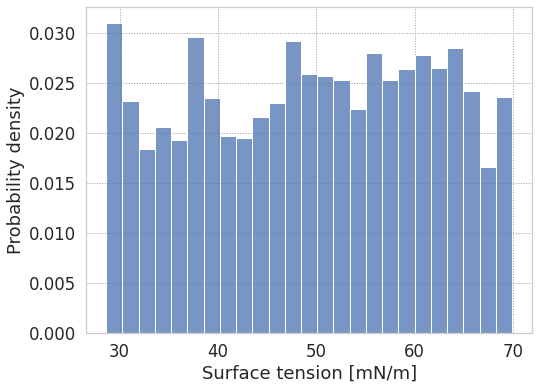

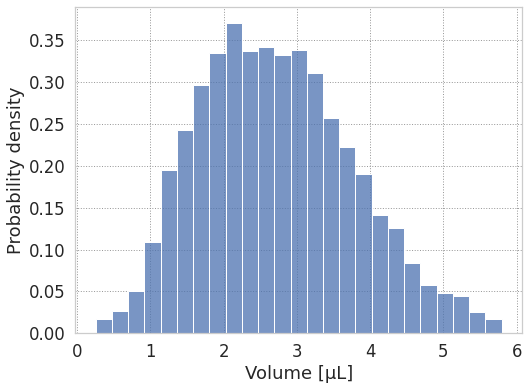

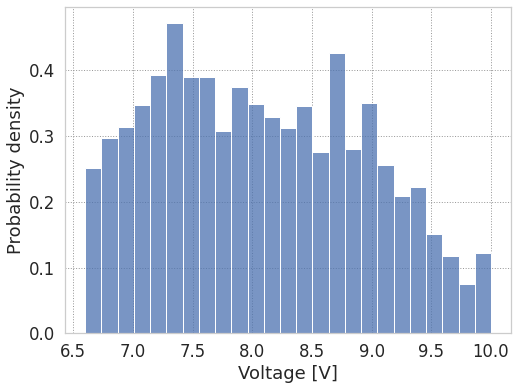

In [ ]:
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[index_test, :].ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension [mN/m]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_1_exp_data_distr_ST_svg', dpi=300, format='svg')
  plt.savefig(path+'error_1_exp_data_distr_ST_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[index_test, :].volume, kde=False, bins=25, stat="density")
plt.xlabel('Volume [μL]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_1_exp_data_distr_Volume_svg', dpi=300, format='svg')
  plt.savefig(path+'error_1_exp_data_distr_Volume_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[index_test, :].volt, kde=False, bins=25, stat="density")
plt.xlabel('Voltage [V]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_1_exp_data_distr_Voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'error_1_exp_data_distr_Voltage_png', dpi=300, format='png')

In [ ]:
rows_02

True_values  Predictions  Index     Error
10074    69.888474    63.894287  50400  5.994187
6681     69.859809    64.010406  33269  5.849402
11773    69.853781    63.607212  59037  6.246569
17149    69.847435    64.771042  85716  5.076393
2878     69.809611    60.396091  14504  9.413519
...            ...          ...    ...       ...
7317     38.186800    32.170269  36444  6.016531
11819    38.186800    32.973091  59292  5.213709
2972     38.186800    31.282110  14935  6.904690
2898     38.186800    33.088055  14591  5.098745
840      38.186800    31.012152   4384  7.174648

[270 rows x 4 columns]

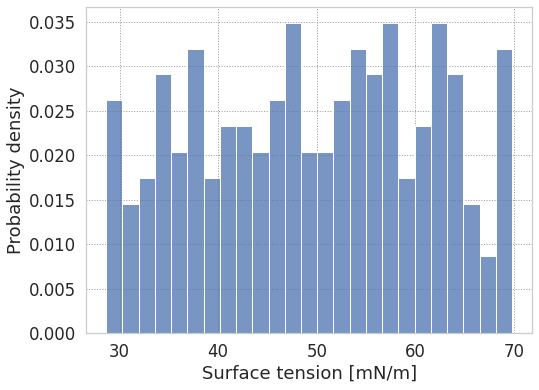

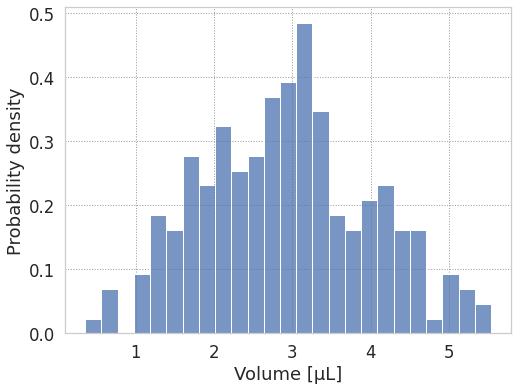

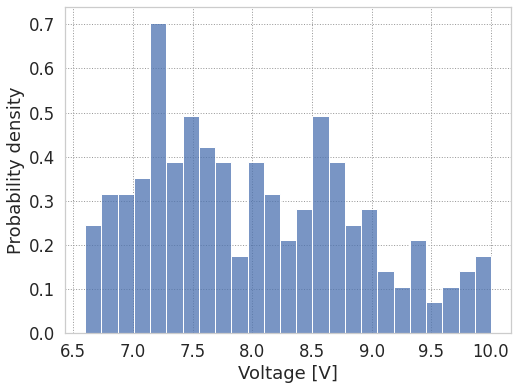

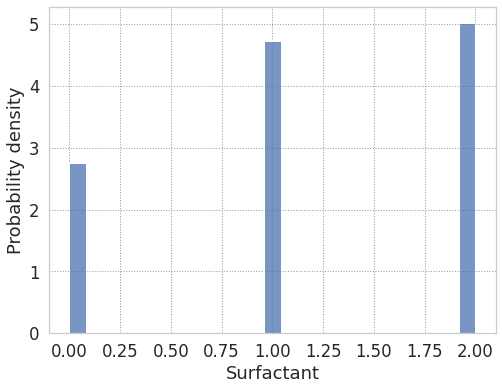

In [ ]:
sorted_st['Index']=index_test
sorted_st['Error']=sorted_st.True_values-sorted_st.Predictions

rows_01=sorted_st[sorted_st['Error'] <= -1]
rows_02=sorted_st[sorted_st['Error'] >= 1]

rows_1=pd.concat([rows_01, rows_02])


plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_1.Index, :].ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension [mN/m]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_1_exp_data_distr_ST_svg', dpi=300, format='svg')
  plt.savefig(path+'error_1_exp_data_distr_ST_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_1.Index, :].volume, kde=False, bins=25, stat="density")
plt.xlabel('Volume [μL]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_1_exp_data_distr_Volume_svg', dpi=300, format='svg')
  plt.savefig(path+'error_1_exp_data_distr_Volume_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_1.Index, :].volt, kde=False, bins=25, stat="density")
plt.xlabel('Voltage [V]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_1_exp_data_distr_Voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'error_1_exp_data_distr_Voltage_png', dpi=300, format='png')


surf_labels=['SDS', 'CTAB', 'TritonX-100' ]
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_1.Index, :].surf_number, kde=False, bins=25, stat="density")
plt.xlabel('Surfactant')
plt.xticks(x, surf_labels)
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_1_exp_data_distr_Voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'error_1_exp_data_distr_Voltage_png', dpi=300, format='png')

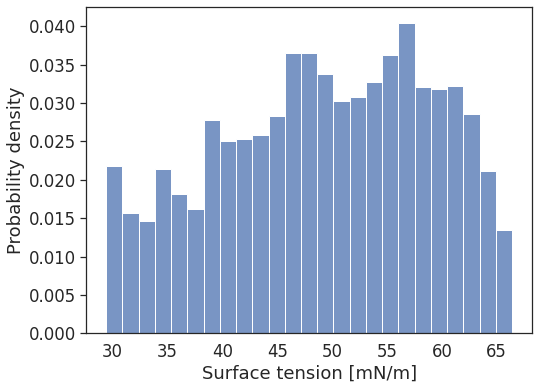

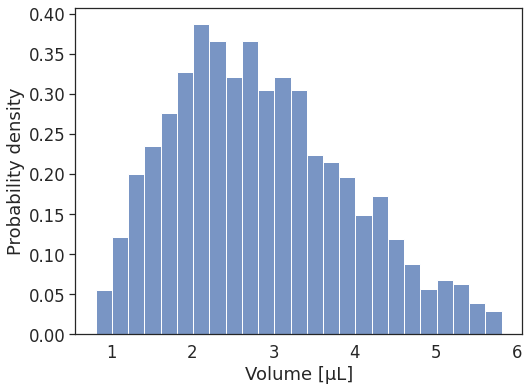

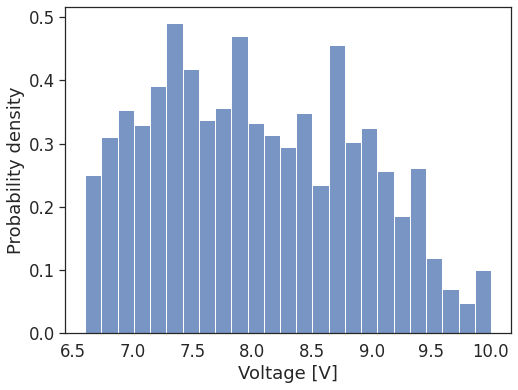

In [ ]:
rows_2_pos=sorted_st[(sorted_st.Error >= 1) & (sorted_st.Error <= 2)]
rows_2_neg=sorted_st[ (sorted_st.Error >= -2) & (sorted_st.Error <= -1) ]

rows_2=pd.concat([rows_2_pos, rows_2_neg])

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_2.Index, :].ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension [mN/m]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_2_exp_data_distr_ST_svg', dpi=300, format='svg')
  plt.savefig(path+'error_2_exp_data_distr_ST_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_2.Index, :].volume, kde=False, bins=25, stat="density")
plt.xlabel('Volume [μL]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_2_exp_data_distr_Volume_svg', dpi=300, format='svg')
  plt.savefig(path+'error_2_exp_data_distr_Volume_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_2.Index, :].volt, kde=False, bins=25, stat="density")
plt.xlabel('Voltage [V]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_2_exp_data_distr_Voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'error_2_exp_data_distr_Voltage_png', dpi=300, format='png')


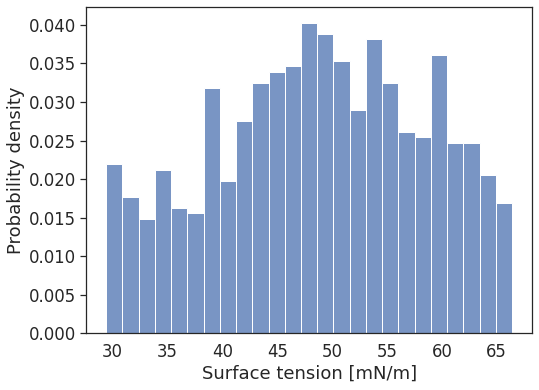

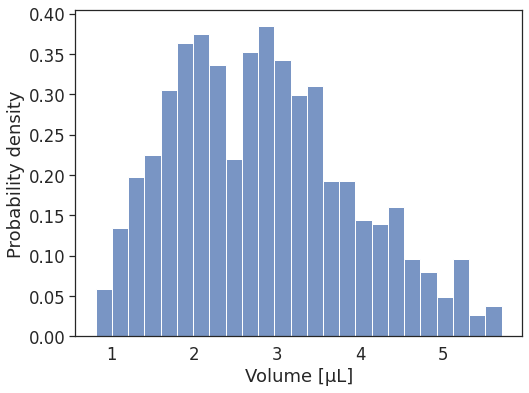

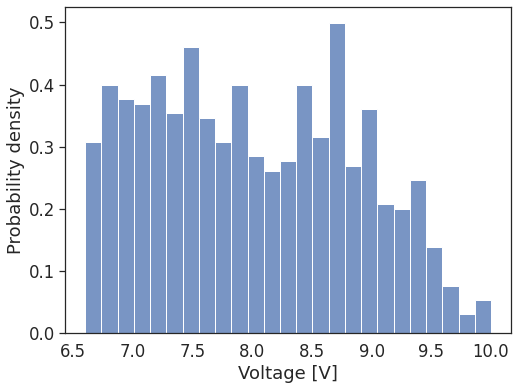

In [ ]:
rows_3_pos=sorted_st[(sorted_st.Error >= 2) & (sorted_st.Error <= 3)]
rows_3_neg=sorted_st[ (sorted_st.Error >= -3) & (sorted_st.Error <= -2) ]

rows_3=pd.concat([rows_3_pos, rows_3_neg])

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_3.Index, :].ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension [mN/m]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_3_exp_data_distr_ST_svg', dpi=300, format='svg')
  plt.savefig(path+'error_3_exp_data_distr_ST_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_3.Index, :].volume, kde=False, bins=25, stat="density")
plt.xlabel('Volume [μL]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_3_exp_data_distr_Volume_svg', dpi=300, format='svg')
  plt.savefig(path+'error_3_exp_data_distr_Volume_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_3.Index, :].volt, kde=False, bins=25, stat="density")
plt.xlabel('Voltage [V]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_3_exp_data_distr_Voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'error_3_exp_data_distr_Voltage_png', dpi=300, format='png')

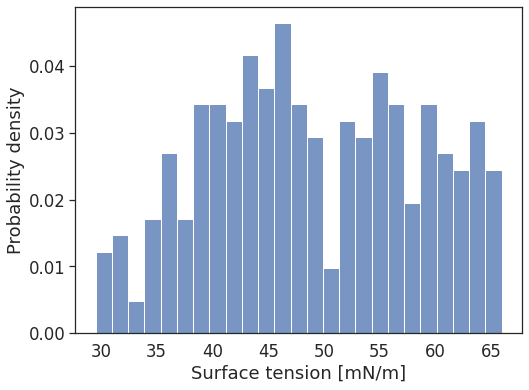

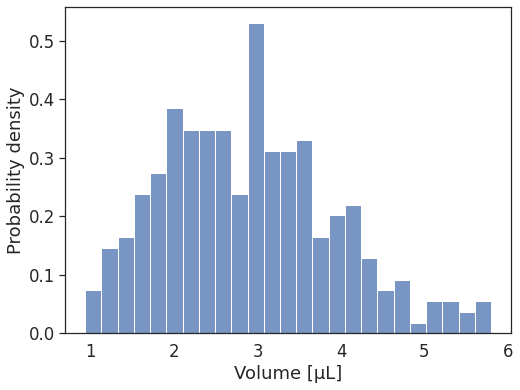

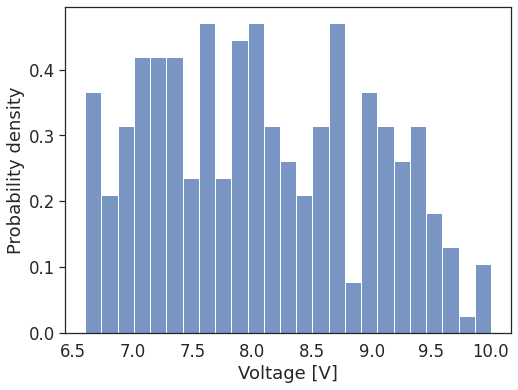

In [ ]:
rows_4_pos=sorted_st[(sorted_st.Error >= 3) & (sorted_st.Error <= 4)]
rows_4_neg=sorted_st[ (sorted_st.Error >= -4) & (sorted_st.Error <= -3) ]

rows_4=pd.concat([rows_4_pos, rows_4_neg])

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_4.Index, :].ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension [mN/m]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_4_exp_data_distr_ST_svg', dpi=300, format='svg')
  plt.savefig(path+'error_4_exp_data_distr_ST_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_4.Index, :].volume, kde=False, bins=25, stat="density")
plt.xlabel('Volume [μL]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_4_exp_data_distr_Volume_svg', dpi=300, format='svg')
  plt.savefig(path+'error_4_exp_data_distr_Volume_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_4.Index, :].volt, kde=False, bins=25, stat="density")
plt.xlabel('Voltage [V]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_4_exp_data_distr_Voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'error_4_exp_data_distr_Voltage_png', dpi=300, format='png')

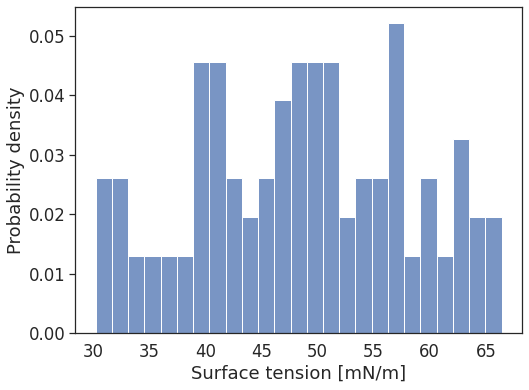

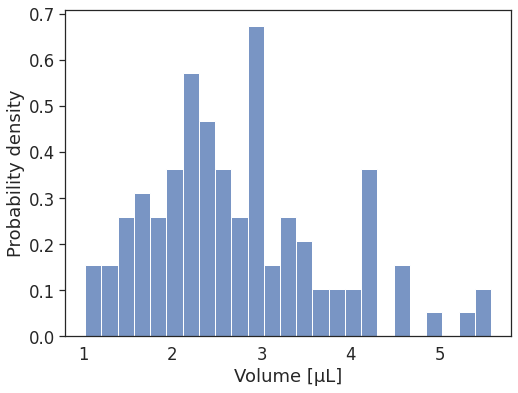

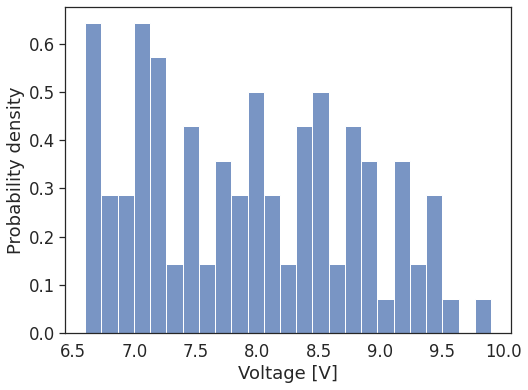

In [ ]:

rows_5_pos=sorted_st[(sorted_st.Error >= 4) & (sorted_st.Error <= 5)]
rows_5_neg=sorted_st[ (sorted_st.Error >= -5) & (sorted_st.Error <= -4) ]

rows_5=pd.concat([rows_5_pos, rows_5_neg])

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_5.Index, :].ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension [mN/m]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_5_exp_data_distr_ST_svg', dpi=300, format='svg')
  plt.savefig(path+'error_5_exp_data_distr_ST_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_5.Index, :].volume, kde=False, bins=25, stat="density")
plt.xlabel('Volume [μL]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_5_exp_data_distr_Volume_svg', dpi=300, format='svg')
  plt.savefig(path+'error_5_exp_data_distr_Volume_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(raw_dataset.iloc[rows_5.Index, :].volt, kde=False, bins=25, stat="density")
plt.xlabel('Voltage [V]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_5_exp_data_distr_Voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'error_5_exp_data_distr_Voltage_png', dpi=300, format='png')

In [ ]:
good_df=dataset.drop(labels=test_data_drop.index, axis=0)
# good_df=good_df.drop(labels=train_data_drop.index, axis=0)

# ST_range=np.array([23, 30, 40, 50, 60, 65, 70, 72.4])
# volume_range=np.array([1.8825, 2.8043, 4.3175, 6.0340, 7.9318, 8.9437, 9.9953, 10.5137])

# plt.figure()
# plt.hist(dataset.ST[test_data_drop.index])
# plt.ylabel('Count')
# plt.xlabel('Surface tension (mN/m)')

# plt.figure()
# plt.plot(ST_range, volume_range, '-r', label='Capillary length volume limit')
# plt.plot(ST_range, volume_range*0.9, '--r', label='90% lower')
# plt.plot(ST_range, volume_range*0.8, '--g', label='80% lower')
# plt.plot(ST_range, volume_range*0.7, '--g', label='70% lower')
# plt.plot(good_df.ST, good_df.volume, 'go', markersize=0.1, label='Good')
# plt.plot(dataset.ST[test_data_drop.index], dataset.volume[test_data_drop.index], 'ro', markersize=0.1, label='Errors test')
# # plt.plot(dataset.ST[train_data_drop.index], dataset.volume[train_data_drop.index], 'ro', markersize=0.1, label='Errors train')
# plt.xlabel('Surface tension (mN/m)')
# plt.ylabel('Volume (μL)')
# plt.legend()

plt.figure()
plt.plot(good_df.ST, 'go', markersize=0.5) #good_df.ST, 
plt.plot(dataset.ST[test_data_drop.index], 'ro', markersize=0.2) #, dataset.ST[test_data_drop.index]
# plt.plot(dataset.ST[train_data_drop.index], 'ro', markersize=0.2) #, dataset.ST[test_data_drop.index]
plt.ylabel('Count')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

# plt.figure()
# plt.plot(good_df.Aspect_Ratio , 'go', markersize=0.5) #good_df.ST, 
# plt.plot(raw_dataset.Aspect_Ratio[test_data_drop.index], 'ro', markersize=0.2) #, dataset.ST[test_data_drop.index]
# plt.plot(raw_dataset.Aspect_Ratio[train_data_drop.index], 'ro', markersize=0.2) #, dataset.ST[test_data_drop.index]
# plt.xlabel('Instance')
# plt.ylabel('Aspect Ratio')
# plt.ylabel('Surface tension (mN/m)')


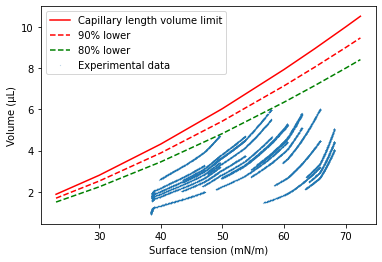

#### Drop data

In [ ]:
dataset=dataset.drop(labels=test_data_drop.index, axis=0)

Text(0, 0.5, 'Surface tension (mN/m)')

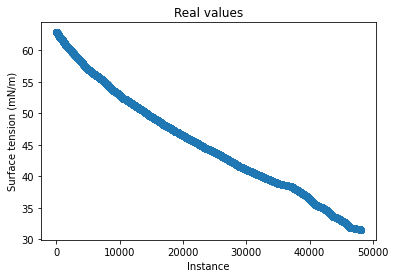

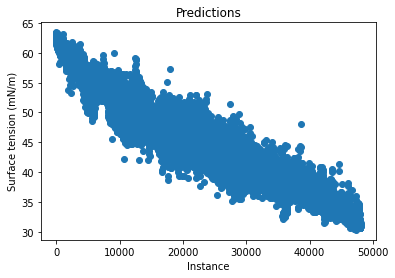

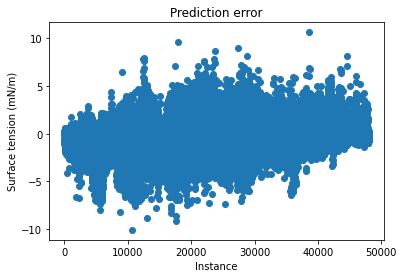

In [ ]:

check_train_df=pd.DataFrame(data={'Train_true_values': train_labels, 'Train_predictions': train_predictions})

sorted_st=check_train_df.sort_values(by=['Train_true_values'], ascending=False)

plt.figure()
plt.title('Real values')
plt.plot(range(len(sorted_st)), sorted_st.Train_true_values, '-o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

plt.figure()
plt.title('Predictions')
plt.plot(range(len(sorted_st)), sorted_st.Train_predictions, 'o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

plt.figure()
plt.title('Prediction error')
plt.plot(range(len(sorted_st)), sorted_st.Train_predictions-sorted_st.Train_true_values, 'o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

# sorted_st

In [ ]:
sorted_st['Train_error']= sorted_st.Train_predictions-sorted_st.Train_true_values
train_data_drop=sorted_st.loc[(sorted_st['Train_error'] >= 1) | (sorted_st['Train_error']<=-1)]
print(train_data_drop.shape)
min(train_data_drop.head(100).Train_true_values)

(6690, 3)


60.94822644550264

In [ ]:
dataset=dataset.drop(labels=train_data_drop.index, axis=0)


In [ ]:
dataset=dataset.reset_index()
dataset.pop('index')
dataset.tail()

rho_1     rho_3     rho_5  ...  centre_y  Aspect_Ratio         ST
27206  0.727254  0.725108  0.725008  ...  1.776124      1.253289  38.150255
27207  0.733397  0.731646  0.731031  ...  1.920803      1.195652  37.950591
27208  0.820537  0.821455  0.822090  ...  1.909381      1.227920  38.561454
27209  0.856916  0.858133  0.853814  ...  1.882729      1.254190  38.378475
27210  0.833141  0.834015  0.832722  ...  1.906138      1.089552  70.599008

[5 rows x 355 columns]

### Save dataset

In [ ]:
path=str('/content/drive/My Drive/DropLev/for_draft/Experimental/')

csvfilename='dataset_20220329_SDS_CTAB_TX100_ST_lit_vert_corr_volt_curr_tilt_corr_091_final.csv' #SDS_CTAB_

train_data.to_csv(path+csvfilename, sep=';', header=True)


In [ ]:
path=str('/content/drive/My Drive/DropLev/for_draft/Experimental/')

csvfilename='dataset_test_20220329_SDS_CTAB_TX100_ST_lit_vert_corr_volt_curr_tilt_corr_091_final.csv' #SDS_CTAB_

test_data.to_csv(path+csvfilename, sep=';', header=True)


In [ ]:
len(train_data)

23974

### Save prediction outcome in a csv file

In [ ]:
#Save prediction outcome in a csv file

# error_test = ST_pred_test - ST_real_test
# error_train = ST_pred_train - ST_real_train
outcome_train=pd.DataFrame(data=np.array([ST_real_train, ST_pred_train]).T, columns=['Train_labels', 'Train_pred'])
outcome_test=pd.DataFrame(data=np.array([ST_real_test, ST_pred_test]).T, columns=[ 'Test_labels', 'Test_pred'])

date=str('20220329')
surf='SDS_CTAB_TX100' #SDS_CTAB_ TX100
# model_No=2
data_No=55710
error='091'
training=1

path='/content/drive/My Drive/DropLev/for_draft/Experimental/'

filename=str('data_%s_%d_MSE_%s_%s_final.csv' %(surf, data_No, error, date))
# !mkdir -p '/content/drive/My Drive/DropLev/Outcomes/' #Ceates a folder named "MachineLearningModels"
outcome_train.to_csv(path+'train_out_%d_'%training+filename, index=False)  #Saves the file
outcome_test.to_csv(path+'test_out_%d_' %training+filename, index=False)  #Saves the file

hist.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'history_%d_' %training + filename)


### Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Run the next code box only if google drive is not mounted to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
path=str('/content/drive/My Drive/DropLev/for_draft/Experimental/')

date=20220329
surf='SDS_CTAB_TX100' #SDS_CTAB_TX100
# number=2
training=1
MAE='091'

filename=str('Model_saved_%s_train_%d_MAE_%s_%d_final.h5' %(surf, training, MAE, date))
#!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
model.save(path+filename)  #Saves the file

## Try out a different model

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(200, activation=tf.nn.softplus, input_shape=[len(normed_train_data.keys())]),
    layers.Dense(100, activation=tf.nn.swish), # input_shape=[len(normed_train_data.keys())]),
    layers.Dense(50, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [ ]:
model_big = build_model()

### If there is a model saved on google drive execute the next block

In [ ]:
from tensorflow.keras.models import load_model

del model 

model_name=str('test_training_whole_drop_3μL_best_175points_noise_0.004_vol_6.h5')
model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+model_name))


#### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
model_big.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               70200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 95,611
Trainable params: 95,611
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model_big.predict(example_batch)
example_result

array([[      nan],
       [2.464269 ],
       [      nan],
       [2.4666297],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

#### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, min_delta=0)

history_big = model_big.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
.............................

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist_big = pd.DataFrame(history_big.history)
hist_big['epoch'] = history_big.epoch
hist_big.tail() 

loss  mean_absolute_error  ...  val_mean_squared_error  epoch
124  109.842056             8.555373  ...              110.820740    124
125  109.929482             8.557758  ...              111.271721    125
126  109.859123             8.554682  ...              111.351135    126
127  109.711716             8.549767  ...              111.419083    127
128  109.710609             8.545816  ...              111.692207    128

[5 rows x 7 columns]

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  plt.show()


plot_history(history_big)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model_big.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

Testing set Mean Abs Error:  8.67 mN/m


#### Make predictions

Finally, predict ST values using data in the testing set:

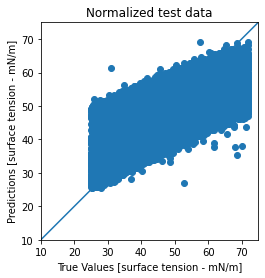

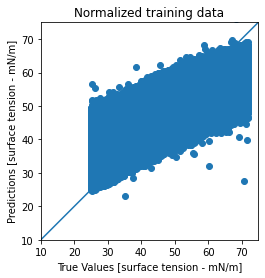

In [ ]:
test_predictions_big = model_big.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions_big)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2_big = model_big.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2_big)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


Seriously?

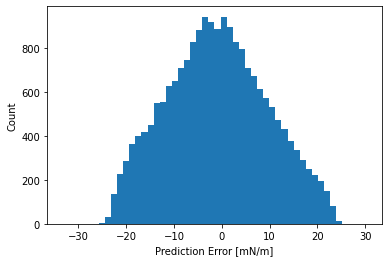

In [ ]:
error_big = test_predictions_big - test_labels
plt.hist(error_big, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
#plt.ylim(0, 5)
plt.show()

#### Trying model No 3


In [ ]:
# def build_model():
#   model = keras.Sequential([
#     #layers.Dense(100, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
#     layers.Conv3D(64, kernel_size=(5,5, 5), strides=(1, 1, 1), activation=tf.nn.swish, input_shape=[len(normed_train_data.keys())]),
#     layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1)),
#     layers.Conv3D(32, kernel_size=(5, 5, 5), strides=(1, 1, 1), activation=tf.nn.swish),
#     layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1)),
#     layers.Flatten(),

#     layers.Dense(14, activation=tf.nn.swish),
#     layers.Dense(5, activation=tf.nn.swish),
#     layers.Dense(1)
#   ])

#   optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
#   model.compile(loss='mean_squared_error',
#                 optimizer=optimizer,
#                 metrics=['mean_absolute_error', 'mean_squared_error'])
#   return model

#### Reshape the data

In [ ]:
print(normed_train_data.shape)

(80000, 350)


In [ ]:
sample_size = normed_train_data.shape[0] # number of samples in train set
time_steps1  =2 # int(normed_train_data.shape[1]) # number of features in train set
time_steps2 =175 #int(normed_train_data.shape[1]/25)
input_dimension = 1               # each feature is represented by 1 number

train_data_reshaped = normed_train_data.values.reshape(sample_size, time_steps1, time_steps2, input_dimension)

input_shape=train_data_reshaped.shape
print(input_shape)

(80000, 2, 175, 1)


#### Reshape test data

In [ ]:
test_data_reshaped = normed_test_data.values.reshape(normed_test_data.shape[0], 2, 175, 1) #int(normed_test_data.shape[1]/25)

In [ ]:
def build_model():
  
  n_timesteps = train_data_reshaped.shape[1] #Number of features
  n_features  = train_data_reshaped.shape[2] #Number of output(s)
  dimension=1
  model = keras.Sequential([
    # layers.Input(shape=),
    layers.Conv2D(filters=50, kernel_size=(1, 1), activation="relu", input_shape=(n_timesteps,n_features, dimension)),
    layers.MaxPooling2D(pool_size=(1, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=25, kernel_size=(1, 1), activation="relu"),
    layers.MaxPooling2D(pool_size=(1, 1)),
    layers.BatchNormalization(),
    # layers.GlobalAveragePooling3D(),
    layers.Flatten(),
    # layers.Dense(100, activation=tf.nn.softplus),
    # layers.Dense(50, activation=tf.nn.swish),
    layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(1)
  ])

 # optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mean_squared_error',
                optimizer=get_optimizer(),
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [ ]:
CNN_model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
CNN_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 2, 175, 50)        100       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 2, 175, 50)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 2, 175, 50)        200       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 2, 175, 25)        1275      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 2, 175, 25)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 2, 175, 25)        100       
_________________________________________________________________
flatten_13 (Flatten)         (None, 8750)            


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = train_data_reshaped[:10]
example_result = CNN_model.predict(example_batch)
example_result

array([[28.087883],
       [32.96527 ],
       [44.103367],
       [69.42511 ],
       [51.100143],
       [45.80421 ],
       [56.901924],
       [51.55749 ],
       [65.29247 ],
       [46.492516]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=15, verbose=0, mode='auto')

history_CNN = CNN_model.fit(train_data_reshaped, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])  # callbacks=callbacks_list



.............................

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist_CNN = pd.DataFrame(history_CNN.history)
hist_CNN['epoch'] = history_CNN.epoch
hist_CNN.tail() 

loss  mean_absolute_error  ...  val_mean_squared_error  epoch
24  111.828896             8.636181  ...              109.931259     24
25  111.635277             8.627120  ...              113.665749     25
26  111.584976             8.627238  ...              110.240440     26
27  111.479774             8.623121  ...              110.773445     27
28  111.552353             8.625348  ...              109.793175     28

[5 rows x 7 columns]

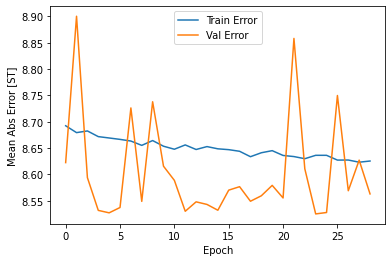

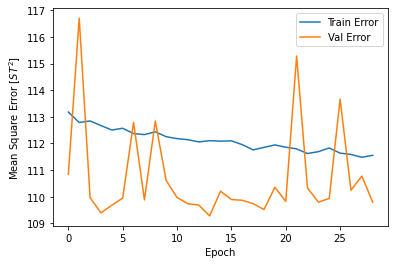

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  # plt.ylim([0,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  # plt.ylim([0,5])
  plt.legend()
  plt.show()


plot_history(history_CNN)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = CNN_model.evaluate(test_data_reshaped, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

Testing set Mean Abs Error:  8.74 mN/m


### Make predictions

Finally, predict ST values using data in the testing set:

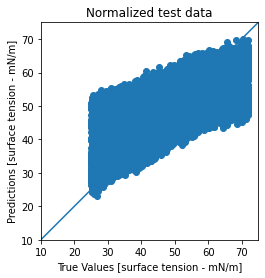

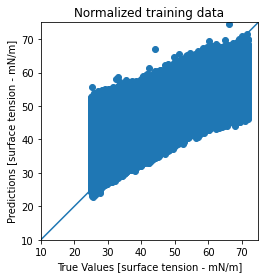

In [ ]:
test_predictions_CNN = CNN_model.predict(test_data_reshaped).flatten()

plt.scatter(test_labels, test_predictions_CNN)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2_CNN = CNN_model.predict(train_data_reshaped).flatten()

plt.scatter(train_labels, test_predictions2_CNN)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


Seriously?

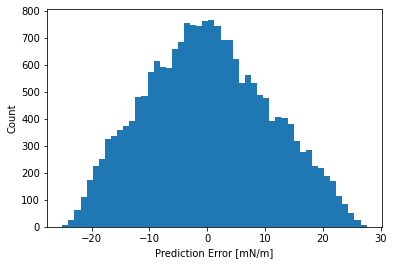

In [ ]:
error_CNN = test_predictions_CNN - test_labels
plt.hist(error_CNN, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
#plt.ylim(0, 5)
plt.show()

### Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Run the next code box only if google drive is not mounted to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
folder=str('theoretical_all_vary/')
filename=str('CNN_model_all_vary_with_Ps_noise_Ps_1300_2800_2_6μL_30_70mN_m_no_noise_only_contours_1.h5')
#!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
CNN_model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)  #Saves the file

## CMC determination on new data


In [ ]:
def prep_input(input, sampling=175):
  points=sampling

  column_names=[]
  for i in range(points):
    column_names.append('rho_%d' %i)
  for i in range(points):
    column_names.append('phi_%d' %i)
  # for i in range(points):
  #   column_names.append('theta_%d' %i)
  column_names.append('height') #350  #525  900
  column_names.append('width')  #351  #526  901
  column_names.append('volume') #352  #527 902
  column_names.append('R_sph')  #353  #528  903
  column_names.append('centre_x') #354  #529  908
  column_names.append('centre_z') #355  #530  909
  column_names.append('Aspect_Ratio') #356  #531  911
  column_names.append('volt') #357  #532   904
  column_names.append('current') #358  #533  905
  column_names.append('time') #359  #534  906
  column_names.append('Power') #360  #535  907
  column_names.append('centred_z') #361  

  column_names.append('surfactant_conc') #362   #536 910
  column_names.append('ST')  #363 #538  912


  if type(input)==pd.core.frame.DataFrame:
    ### For one file
    raw_dataset = input
    raw_dataset.columns=column_names
  else:
    ### For multiple files
    raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
                
  raw_dataset.shape

  dataset = raw_dataset.copy()

  # dataset.centre_z=-dataset.centre_z
  # dataset.Aspect_Ratio=1/dataset.Aspect_Ratio

  for i in range(points):
    dataset.pop('phi_%d' %i)  
  dataset.pop("height")
  dataset.pop("width")
  dataset.pop("volume")
  dataset.pop("R_sph")
  voltage = dataset.pop('volt')
  current = dataset.pop('current')
  dataset.pop('time')
  dataset.pop('Power')
  dataset.pop("centre_x")
  centre_z = dataset.pop("centre_z")
  surf_conc = dataset.pop('surfactant_conc')
  centred_z = dataset.pop("centred_z")

  dataset.pop("Aspect_Ratio")
  ST=dataset.pop('ST')


  

  # theta=[]
  # theta_array=[]
  # for i in range(points):
  #   theta.append(str('theta_%d' %i))

  # for i in range(len(dataset)):
  #   x, y=pol2cart(dataset.iloc[i, 0:points].values, dataset.iloc[i, points:2*points].values)
  #   theta_array.append(azimuth(x, y))

  # dataset[theta]=theta_array

  # for i in range(0, sampling):
  #   dataset.pop('phi_%d' %i)

  dataset['centred_z']=centred_z
  dataset['volt']=voltage
  dataset['current']=current
  # dataset['Power']=Power
  # dataset['AR']=AR
  dataset['surf_conc']=surf_conc
  dataset['ST']=ST


  dataset.tail()

  #Drop 125 contour points
  # If we want to drop 150 datapoints then n= 299 
  # If we want to drop 125 datapoints then n= 250

  # n=250
  # for i in range(0, n, 2):
  #   dataset.pop('phi_%d' %i)

  # for i in range(0, n, 2):
  #   dataset.pop('theta_%d' %i)

  # for i in range(0,n, 2):
  #   dataset.pop('rho_%d' %i)
  
  return dataset



In [ ]:
#Min-Max transformation

def MinMaxTransformTest(dataset_test, dataset_train,  points=175): #dataset_train

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(dataset_train)):
    max_rho.append(max(dataset_train.iloc[i, 0:points].values))
    min_rho.append(min(dataset_train.iloc[i, 0:points].values))
    # max_theta.append(max(dataset_train.iloc[i, points:2*points].values))
    # min_theta.append(min(dataset_train.iloc[i, points:2*points].values))
    
  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(dataset_test)):
    if (OldRange == 0):
        NewValue = dataset_test.iloc[i, 0:points]
        NewValues_rho[i].append(NewValue)
    else:
        NewValue = (dataset_test.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(dataset_test)):
  #   if (OldRange == 0):
  #       NewValue = dataset_test.iloc[i, points:2*points]
  #       NewValues_theta[i].append(NewValue)
  #   else:
  #       NewValue = (dataset_test.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_theta, df_rho], axis=1)

  return df_rho


def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])

## Re-scale target feature
# def rescaling_real(target, stats):
#   max=stats.loc['ST']['max']
#   min=stats.loc['ST']['min']
#   target=np.asarray(target)
#   return (max-min)*(target)+min

# def rescaling_pred(pred, true, rescaled_true):
#   pred=np.asarray(pred)
#   true=np.asarray(true)
#   de_true=np.asarray(rescaled_true)
#   max_true=max(de_true)
#   min_true=min(de_true)
#   diff=pred-true
#   return diff*(max_true-min_true)+de_true

def rescaling(target, stats):
  min=stats.loc['ST']['min']
  max=stats.loc['ST']['max']
  target=np.asarray(target)
  return (max-min)*(target)+min



In [ ]:
def predict(normed_data, model):
  # Display training progress by printing a single dot for each completed epoch
  class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
      if epoch % 100 == 0: print('')
      print('.', end='')

  normed_test_data=normed_data.copy()
  test_labels = normed_test_data.pop('ST')
  test_predictions = model.predict(normed_test_data).flatten()
  loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
  history=None
  return test_predictions, test_labels, mae, history


In [ ]:

def density_scatter(x, y, title=None, label=None, colours='magma', lim1=10, lim2=80, eq_sq=True, figsize=(8,8)):
  # Calculate the point density
  x=np.asarray(x)
  y=np.asarray(y)
  xy = np.vstack([x, y])
  z = gaussian_kde(xy)(xy)
  # Sort the points by density, so that the densest points are plotted last
  idx = z.argsort()
  x, y, z = x[idx], y[idx], z[idx]

  fig, ax = plt.subplots(figsize=figsize)
  ax.set_facecolor('whitesmoke')
  if title!=None:
    plt.title(title)
  im=ax.scatter(x, y, label=label, c=z, s=50, cmap=colours)
  plt.xlabel('True Values of ST (mN/m)')
  plt.ylabel('Predictions of ST (mN/m)')
  if eq_sq==True:
    plt.axis('equal')
    plt.axis('square')
  # plt.xlim([lim1, lim2])
  # plt.ylim([lim1, lim2])
  norm = Normalize(vmin = np.min(z), vmax = np.max(z))
  cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=colours), ax=ax)
  cbar.ax.set_ylabel('Density')


def plot_history(history, savemode=False, path=None, filenameMAE=None, filenameMSE=None, figtype='png'):

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  sns.set_theme(style='ticks', font_scale=1.5)
  
  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.5])
  plt.legend(frameon=False)
  if savemode==True:
    plt.savefig(path+filename+'_svg', dpi=300, format='svg')
    plt.savefig(path+filename+'_png', dpi=300, format='png')


  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,2.5])
  plt.legend(frameon=False)
  if savemode==True:
    plt.savefig(path+filename+'_svg', dpi=300, format='svg')
    plt.savefig(path+filename+'_png', dpi=300, format='png')


Standardize based on data of saved model

In [ ]:

path=str('/content/drive/My Drive/DropLev/for_draft/Experimental/')

csvfilename='dataset_20220322_SDS_CTAB_TX100_ST_lit_vert_corr_volt_curr_tilt_corr.csv' #SDS_CTAB_ TX100 

# csvfilename='dataset_20220114_Model_2_ST_corr_080.csv'

train_data=pd.read_csv(path+csvfilename, sep=';', index_col=False)
train_data.pop('Unnamed: 0')
# train_dataset.tail()

points=175
if train_data.shape[1]>2*points:
  stats = train_data.iloc[:, points*2:].describe()
else:
  stats = train_data.iloc[:, points:].describe()
# stats.pop("ST")

stats = stats.transpose()
stats

In [ ]:
from sklearn.utils import shuffle

#Define data
path_files=str('/content/drive/My Drive/DropLev/Raw_data/')
points=175

# new_data=pd.read_csv(str(path_files+'TritonX100/TritonX_conci_0.17500_all_175.csv'), sep="\t", header=None)
# new_data=np.vstack([fileTrit12.iloc[2300:,:], fileTrit13.iloc[3000:, :]])
# new_data=pd.read_csv(str(path_files+'SDS/SDS_conci_6.50000_all_175.csv'), sep="\t", header=None)
# new_data=pd.read_csv(str(path_files+'CTAB/CTAB_conci_0.90000_all_175.csv'), sep="\t", header=None)

# new_data=np.vstack([fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB11, fileCTAB12, fileCTAB13, fileCTAB14, fileCTAB15])

new_data=fileCTAB16.iloc[0:1000] #.iloc[250:2500, :]
# file='fileCTAB16_corr'

# unseen_data_1=fileSDS17.iloc[0:1500, :]
# unseen_data_2=fileSDS18.iloc[0:1500, :]
# unseen_data=pd.DataFrame(np.vstack([unseen_data_1, unseen_data_2]))

# input_len=np.array([len(fileCTAB8), len(fileCTAB9), len(fileCTAB10), len(fileCTAB11), len(fileCTAB12), len(fileCTAB13), len(fileCTAB14), len(fileCTAB15)])

unseen_data=pd.DataFrame(data=new_data)

# #Correct ST for calibration TritX:1.251, CTAB:1.2, SDS:2.349
# if file.startswith('fileTrit'):
#   unseen_data.iloc[:, 912]=unseen_data.iloc[:, 912].values+1.251 
# elif file.startswith('fileCTAB'):
#   unseen_data.iloc[:, 912]=unseen_data.iloc[:, 912].values+1.2
# elif file.startswith('fileSDS'):
#   unseen_data.iloc[:, 912]=unseen_data.iloc[:, 912].values+2.349


unseen_dataset=prep_input(unseen_data, sampling=175)

#Centering z-position by triplets
# z_position=[]
# j=0
# for i in range(len(input_len)):
#   z_position.append(unseen_dataset.centre_z[j:j+input_len[i]]-np.mean(unseen_dataset.centre_z[j:j+input_len[i]]))
#   j=j+input_len[i]


# flat_list = []
# for sublist in z_position:
#     for item in sublist:
#         flat_list.append(item)

### Original vertical position ###
# j=0
# plt.figure()
# for i in range(len(input_len)):
#   plt.plot(unseen_dataset.centre_z[j:j+input_len[i]])
#   j=j+input_len[i]
# plt.xlabel('Instance')
# plt.ylabel('Vertical position (mm)')

# ### Centred vertical position ###
# plt.figure()
# for i in range(len(input_len)):
#   plt.plot(z_position[i])
# plt.xlabel('Instance')
# plt.ylabel('Centered vertical position (mm)')

# unseen_dataset['centred_z']=flat_list


shuffled_unseen_data=shuffle(unseen_dataset, random_state=0)

shuffled_unseen_data.reset_index(drop=True, inplace=True)

surf_conc = shuffled_unseen_data.pop('surf_conc')



# unseen_normed_rho_theta=MinMaxTransform(unseen_dataset, dataset, points)
unseen_normed_rho_theta=MinMaxTransformTest(shuffled_unseen_data, train_data, points)

if shuffled_unseen_data.shape[1]>2*points:
  unseen_normed_data_rest = min_max_norm(shuffled_unseen_data.iloc[:, points*2:])
else:
  unseen_normed_data_rest = min_max_norm(shuffled_unseen_data.iloc[:, points:])

unseen_normed_data = unseen_normed_rho_theta.copy()

#Alternating rho and theta
# rho=unseen_normed_data.iloc[:, 0:175]
# theta=unseen_normed_data.iloc[:, 175:2*175]

# norder=pd.DataFrame()
# for i in range(175):
#   norder = norder.append(theta.iloc[:, i])
#   norder = norder.append(rho.iloc[:, i])

# norder=norder.T

# unseen_normed_data=norder.copy()

# unseen_normed_data['height'] = unseen_normed_data_rest.height
# unseen_normed_data['width'] = unseen_normed_data_rest.width
# unseen_normed_data['volume'] = unseen_normed_data_rest.volume
# unseen_normed_data['R_sph'] = unseen_normed_data_rest.R_sph
# unseen_normed_data['centre_x'] = unseen_normed_data_rest.centre_x
unseen_normed_data['centred_z'] = unseen_normed_data_rest.centred_z
# unseen_normed_data['Aspect_Ratio'] = unseen_normed_data_rest.Aspect_Ratio
unseen_normed_data['volt'] = unseen_normed_data_rest.volt
unseen_normed_data['current'] = unseen_normed_data_rest.current
# unseen_normed_data['Power'] = unseen_normed_data_rest.Power
unseen_normed_data['ST'] = unseen_normed_data_rest.ST


unseen_normed_data.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

rho_0     rho_1     rho_2     rho_3     rho_4     rho_5     rho_6  \
995  0.590685  0.588980  0.588761  0.590039  0.587676  0.584373  0.582666   
996  0.703076  0.703143  0.701015  0.697785  0.696165  0.691441  0.686754   
997  0.686635  0.684469  0.683914  0.679130  0.673634  0.668467  0.660073   
998  0.714523  0.712641  0.707772  0.702901  0.698189  0.688703  0.680186   
999  0.658816  0.658450  0.655583  0.654485  0.649323  0.643803  0.639773   

        rho_7     rho_8     rho_9  ...   rho_169   rho_170   rho_171  \
995  0.576910  0.576021  0.571654  ...  0.577417  0.581614  0.584203   
996  0.680424  0.672287  0.666012  ...  0.685720  0.691708  0.696586   
997  0.651309  0.639776  0.628787  ...  0.663887  0.668678  0.676440   
998  0.669355  0.654967  0.641786  ...  0.686350  0.694218  0.703647   
999  0.631789  0.624062  0.614537  ...  0.640144  0.644562  0.649850   

      rho_172   rho_173   rho_174  centred_z      volt   current        ST  
995  0.589750  0.589125  0.589993   0.318054  0.070588  0.162791  0.236751  
996  0.698454  0.701948  0.702473   0.585830  0.217647  0.232558  0.301861  
997  0.682683  0.685908  0.686144   0.697152  0.488235  0.523256  0.243232  
998  0.705440  0.708867  0.713940   0.775378  0.655882  0.697674  0.249471  
999  0.655283  0.658356  0.658405   0.624943  0.364706  0.406977  0.240233  

[5 rows x 179 columns]

In [ ]:
folder=str('/for_draft/Experimental/')
date=20220322
surf='SDS_CTAB_TX100' #SDS_CTAB_TX100 TX-100
# number=2
training=1
MAE='076'


filename=str('Model_saved_%s_train_%d_MAE_%s_%d.h5' %(surf, training, MAE, date))
# del model

model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/'+folder+filename)

# Check its architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 50)                8950      
                                                                 
 dense_9 (Dense)             (None, 40)                2040      
                                                                 
 dense_10 (Dense)            (None, 30)                1230      
                                                                 
 dense_11 (Dense)            (None, 20)                620       
                                                                 
 dense_12 (Dense)            (None, 15)                315       
                                                                 
 dense_13 (Dense)            (None, 10)                160       
                                                                 
 dense_14 (Dense)            (None, 5)                

In [ ]:
#Make predictions

new_prediction, new_test_labels, new_mae, new_history = predict(unseen_normed_data, model)



In [ ]:
# ST_real_descaled=rescaling_real(new_test_labels, stats)
# ST_pred_descaled=rescaling_pred(new_prediction, new_test_labels, ST_real_descaled)

In [ ]:
ST_real_descaled=rescaling(new_test_labels, stats)
ST_pred_descaled=rescaling(new_prediction, stats)



Text(0.5, 0, 'Instances')

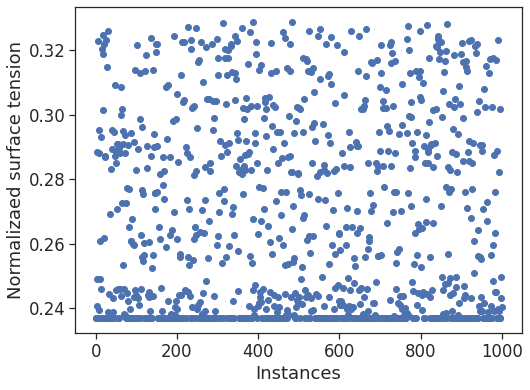

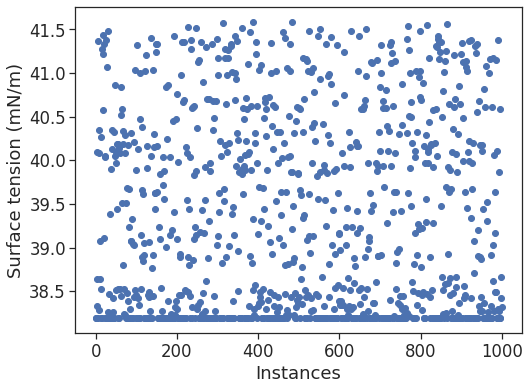

In [ ]:
#Descale target feature

# ST_real_descaled=rescaling_real(new_test_labels, stats)
# ST_pred_descaled=rescaling_pred(new_prediction, new_test_labels, ST_real_descaled)
sns.set_theme(style='ticks', font_scale=1.5)
#De-normalization check:
plt.figure(figsize=(8,6))
plt.scatter(range(len(new_test_labels)), new_test_labels)
plt.ylabel('Normalizaed surface tension')
plt.xlabel('Instances')

plt.figure(figsize=(8,6))
plt.scatter(range(len(ST_real_descaled)), ST_real_descaled)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instances')

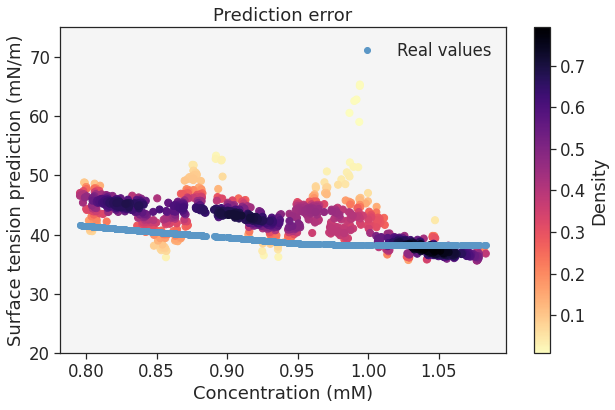

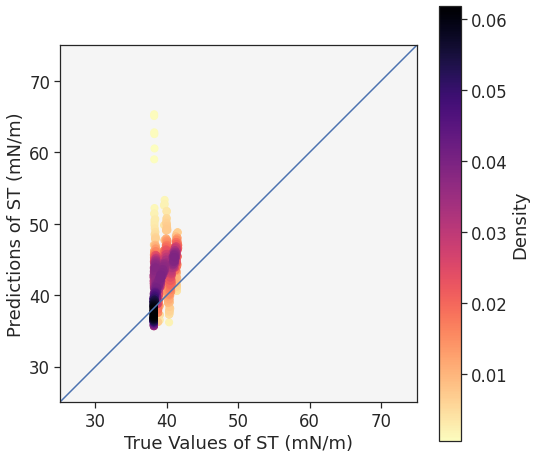

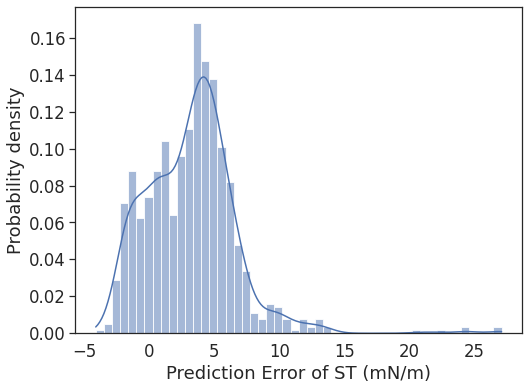

In [ ]:
sns.set_theme(style='ticks', font_scale=1.5)
colours='magma_r'

savefig=False
path='/content/drive/My Drive/DropLev/for_draft/Experimental/Figures/'

error_test = ST_pred_descaled - ST_real_descaled

density_scatter(surf_conc, ST_pred_descaled, title='Prediction error', colours=colours,  eq_sq=False, figsize=(10,6))
plt.plot(surf_conc, ST_real_descaled, 'o', color='#5b97c6', label='Real values')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('Surface tension prediction (mN/m)')
plt.xlabel('Concentration (mM)')
plt.legend(frameon=False)
if savefig==True:
  plt.savefig(path+'pred_on_%s_pred_and_real_values_ST_Vs_conc_svg' %file, dpi=300, format='svg')
  plt.savefig(path+'pred_on_%s_pred_and_real_values_ST_Vs_conc_png' %file, dpi=300, format='png')
plt.ylim(20, 75)

density_scatter(ST_real_descaled, ST_pred_descaled, colours=colours)
_ = plt.plot([-100, 100], [-100, 100])
plt.xlim(25, 75)
plt.ylim(25, 75)
if savefig==True:
  plt.savefig(path+'training_data_error_plot_svg', dpi=300, format='svg')
  plt.savefig(path+'training_data_error_plot_png', dpi=300, format='png')


plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error of ST (mN/m)")
_ = plt.ylabel("Probability density")
# plt.xlim(-6, 6)
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'pred_on_%s_test_data_error_distr_lim_svg' %file, dpi=300, format='svg')
  plt.savefig(path+'pred_on_%s_test_data_error_distr_lim_png' %file, dpi=300, format='png')




# print('MAE: %.3f mN/m' %new_mae)

#### CMC determination

In [ ]:
table=pd.DataFrame(np.vstack([ST_pred_descaled, surf_conc]).T, columns=['ST_pred', 'conc'])

Predictions=table.sort_values(by=['conc'], ascending=True)
savefig=False

ST_lim1=0.15 # TritonX: 0.45, SDS: 6   CTAB: 0.85
ST_lim2=0.28  # TritonX: 0.80, SDS: 9.5   CTAB: 0.95

ST_lim3=0.3 # TritonX: 0.9, SDS:10.2   CTAB: 1
ST_lim4=0.6  # TritonX: 1.2, SDS:12.7   CTAB: 1.3

lower=Predictions[(Predictions['conc'] > ST_lim1) & (Predictions['conc'] <ST_lim2)]
higher=Predictions[(Predictions['conc'] > ST_lim3) & (Predictions['conc'] <ST_lim4)]

slope1, intercept1, r1, p1, se1 = linregress(lower.conc, lower.ST_pred)
slope2, intercept2, r2, p2, se2 = linregress(higher.conc, higher.ST_pred)

cross_conc=(intercept2-intercept1)/(slope1-slope2)
cross_ST=slope2*cross_conc+intercept2

plt.figure(figsize=(8,6))
density_scatter(Predictions.conc, Predictions.ST_pred, colours=colours,  eq_sq=False, figsize=(10,6))
plt.plot(lower.conc, slope1*lower.conc+intercept1, '--', color='#577dc6', linewidth=3.5)
plt.plot(higher.conc, slope2*higher.conc+intercept2, '--', color='#577dc6', linewidth=3.5)
plt.plot(cross_conc, cross_ST, 'o', color='#577dc6', markersize=12, label='CMC=%.3f mM' %cross_conc)
# plt.ylim(35,42)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Concentration (mM)')
plt.legend(loc='upper right', frameon=False)
if savefig==True:
  plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_svg' %file, dpi=300, format='svg')
  plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_png' %file, dpi=300, format='png')

####### Error bars #######

# conc_lim=0.1  #TritonX: 0.005, SDS: 0.1, CTAB: 0.005
# error_bars=5
# sorted_predictions= Predictions.ST_pred.sort_values(ignore_index=True,  ascending=False)
# errorx=np.linspace(min(Predictions['conc']), max(Predictions['conc']), error_bars)

# yerror_range={}
# yerror=[]
# errory=[]

# for i in range(len(errorx)):
#   yerror_range[i]=Predictions[(Predictions['conc'] > errorx[i]-conc_lim) & (Predictions['conc'] <errorx[i]+conc_lim)].ST_pred
#   yerror.append((max(yerror_range[i])-min(yerror_range[i]))/2)
#   errory.append(np.mean(yerror_range[i]))


# yerror=np.asarray(yerror)
# errory=np.asarray(errory)

# plt.figure(figsize=(8,6))
# plt.plot(Predictions.conc, sorted_predictions, 'b')
# plt.plot(lower.conc, slope1*lower.conc+intercept1, '--k', linewidth=3)
# plt.plot(higher.conc, slope2*higher.conc+intercept2, '--k', linewidth=3)
# plt.plot(cross_conc, cross_ST, 'or', label='CMC=%.3f' %cross_conc)
# plt.errorbar(errorx, errory, yerr=yerror,  fmt='.k')
# plt.xlabel('Instances',fontsize=14)
# plt.ylabel('Surface tension (mN/m)',fontsize=18)
# plt.legend(loc='upper right', frameon=False)
# if savefig==True:
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_error_bars_50percent_svg' %file, dpi=300, format='svg')
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_error_bars_50percent_png' %file, dpi=300, format='png')


### Correlations between high error and values of features

In [ ]:
test_df=shuffled_unseen_data.copy()
test_df['pred']=ST_pred_descaled
test_df['error']=error_test

plt.figure()
plt.plot(test_df.error-(test_df.pred-test_df.ST), 'o')

In [ ]:
#Overestimation

overest_df=test_df[error_test>0.5]
# overest_df=overest_df[(overest_df.ST>55) & (overest_df.ST<65)]

# overest_df


for i in range(len(overest_df.columns)-2):
  feature=overest_df.columns[i]
  sorted_df=overest_df.sort_values(by=[feature])

  plt.figure()
  plt.plot(sorted_df[feature], sorted_df.error)
  plt.ylabel('Residual error (mN/m)')
  plt.xlabel(feature)




In [ ]:
#Underestimation

underest_df=test_df[error_test<-0.5]
# underest_df=underest_df[(underest_df.ST>60) & (underest_df.ST<70)]

# underest_df

for i in range(len(underest_df.columns)-2):
  feature=underest_df.columns[i]
  sorted_df=underest_df.sort_values(by=[feature])

  plt.figure()
  plt.plot(sorted_df[feature], sorted_df.error)
  plt.gca().invert_yaxis()
  plt.ylabel('Residual error (mN/m)')
  plt.xlabel(feature)


###  [Evidently](https://github.com/evidentlyai/evidently)

In [ ]:
!pip install evidently 

from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import RegressionPerformanceTab

In [ ]:
st_train=train_data['ST']

reference_data= train_data.iloc[:, 0:points].copy()
reference_data['volt']=train_data.volt
reference_data['current']=train_data.current
reference_data['centred_z']=train_data.centred_z

# reference_data['pred']=ST_pred_train
reference_data['ST']=st_train

reference=reference_data.sample(1000, random_state=0) 
reference.tail()

In [ ]:
st_test=shuffled_unseen_data['ST']

current_data= shuffled_unseen_data.iloc[:, 0:shuffled_unseen_data.shape[1]-1].copy()
# current_data['pred']=ST_pred_descaled
current_data['ST']=st_test

current=current_data.sample(1000, random_state=0)
current.tail()

In [ ]:
from evidently.pipeline.column_mapping import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab

column_mapping = ColumnMapping()
column_mapping.target= 'ST'
column_mapping.prediction = None #'pred' 
column_mapping.id = None 
column_mapping.datetime = None
column_mapping.numerical_features = test_data.columns[0:points+3]
column_mapping.categorical_features = None


my_dashboard = Dashboard(tabs=[DataDriftTab()])
my_dashboard.calculate(reference, current)
my_dashboard.show()

In [ ]:
# from scipy.stats import linregress

# # volume=unseen_dataset.volume.copy()
# # volume.sort_values(ascending=False, inplace=True)

# savefig=True

# check_test_df=pd.DataFrame(data={'True_values': ST_real_descaled, 'Predictions': ST_pred_descaled})
# Predictions=check_test_df.sort_values(by=['Predictions'], ascending=False)

# surf_conc_test= new_surf_test[new_surf_test.index.isin(Predictions.index)]
# surf_conc_test.sort_values(inplace=True,ignore_index=True)

# lim1=int(0.2*len(ST_pred_descaled))
# lim2=int(0.55*len(ST_pred_descaled))
# x1=range(lim1, lim2)
# y1=Predictions.Predictions[lim1:lim2]

# lim3=int(0.75*len(ST_pred_descaled))
# lim4=int(0.97*len(ST_pred_descaled))
# x2=range(lim3, lim4)
# y2=Predictions.Predictions[lim3:lim4]

# slope1, intercept1, r1, p1, se1 = linregress(x1, y1)
# slope2, intercept2, r2, p2, se2 = linregress(x2, y2)


# # !To combine sorted_st.Preidctions from both training and test data. Sort based on true ST and then plot.!
# # plt.figure(figsize=(10, 8))
# # plt.subplot(211)
# # plt.plot(range(len(sorted_st.Predictions)), sorted_st.Predictions)
# # plt.plot(range(lim1, lim2), slope1*range(lim1, lim2)+intercept1, '--k')
# # plt.plot(range(lim3, lim4), slope2*range(lim3, lim4)+intercept2, '--k')
# # plt.xlabel('Instances')
# # plt.ylabel('Surface tension (mN/m)')
# # # plt.subplot(312)
# # # plt.plot(range(len(volume)), volume)
# # # plt.xlabel('Instances')
# # # plt.ylabel('Volume (μL)')
# # plt.subplot(212)
# # plt.plot(range(len(surf_conc_test)), surf_conc_test)
# # plt.xlabel('Instances')
# # plt.ylabel('Concentration (mM)')

# space=30

# cross_point=round((intercept2-intercept1)/(slope1-slope2))
# sorted_predictions= Predictions.Predictions.sort_values(ignore_index=True,  ascending=False)
# errorx=np.array([0, int(len(Predictions)*0.25), int(len(Predictions)*0.5), int(len(Predictions)*0.75), int(len(Predictions)-0.5)])
# errory=np.array([sorted_predictions[errorx[0]], sorted_predictions[errorx[1]], sorted_predictions[errorx[2]],
#    sorted_predictions[errorx[3]], sorted_predictions[errorx[4]]])
# yerror=np.array([(max(Predictions.Predictions[0:10])-min(Predictions.Predictions[0:space]))/2, 
#       (max(Predictions.Predictions[int(len(Predictions)*0.25):int(len(Predictions)*0.25)+space])-min(Predictions.Predictions[int(len(Predictions)*0.25):int(len(Predictions)*0.25)+space]))/2,
#       (max(Predictions.Predictions[int(len(Predictions)*0.5):int(len(Predictions)*0.5)+space])-min(Predictions.Predictions[int(len(Predictions)*0.5):int(len(Predictions)*0.5)+space]))/2,
#       (max(Predictions.Predictions[int(len(Predictions)*0.75):int(len(Predictions)*0.75)+space])-min(Predictions.Predictions[int(len(Predictions)*0.75):int(len(Predictions)*0.75)+space]))/2,
#       (max(Predictions.Predictions[int(len(Predictions)-space):int(len(Predictions))])-min(Predictions.Predictions[int(len(Predictions)-space):int(len(Predictions))]))/2])

# # plt.figure(figsize=(10, 8))
# # plt.subplot(211)
# # plt.plot(range(len(Predictions)), sorted_predictions, label='Predictions')
# # plt.plot(range(lim1, lim2), slope1*range(lim1, lim2)+intercept1, '--k')
# # plt.plot(range(lim3, lim4), slope2*range(lim3, lim4)+intercept2, '--k')
# # plt.errorbar(errorx, errory, yerr=yerror,  fmt='.k')
# # plt.legend(frameon=False)
# # plt.xlabel('Instances')
# # plt.ylabel('Surface tension (mN/m)')
# # # plt.subplot(312)
# # # plt.plot(range(len(volume)), volume)
# # # plt.xlabel('Instances')
# # # plt.ylabel('Volume (μL)')
# # plt.subplot(212)
# # plt.plot(range(len(surf_conc_test)), surf_conc_test)
# # plt.plot(cross_point, surf_conc_test[cross_point], 'or', label='CMC=%.3f mM' %surf_conc_test[cross_point])
# # plt.legend(frameon=False)
# # plt.ylim(0, 3)
# # plt.xlabel('Instances')
# # plt.ylabel('Concentration (mM)') 

# fig,ax = plt.subplots(figsize=(8,6))
# ax.plot(range(len(Predictions)), Predictions.Predictions, 'ob', label='Predictions')
# ax.plot(range(lim1, lim2), slope1*range(lim1, lim2)+intercept1, '--k', linewidth=3)
# ax.plot(range(lim3, lim4), slope2*range(lim3, lim4)+intercept2, '--k', linewidth=3)
# ax.set_xlabel('Instances',fontsize=14)
# ax.set_ylabel('Surface tension (mN/m)',color="blue",fontsize=18)
# ax.set_ylim(24, 48)
# # ax.legend(frameon=False)
# ax2=ax.twinx()
# ax2.plot(range(len(surf_conc_test)), surf_conc_test, 'g')
# ax2.plot(cross_point, surf_conc_test[cross_point], 'or', label='CMC=%.3f mM' %surf_conc_test[cross_point])
# ax2.set_ylabel('Concentration (mM)',color="g",fontsize=18)
# ax2.set_ylim(5, 30)
# ax2.legend(loc='upper right', frameon=False)
# if savefig==True:
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_50percent_svg' %file, dpi=300, format='svg')
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_50percent_png' %file, dpi=300, format='png')

# fig,ax = plt.subplots(figsize=(8,6))
# ax.plot(range(len(Predictions)), sorted_predictions, 'b', label='Predictions')
# ax.plot(range(lim1, lim2), slope1*range(lim1, lim2)+intercept1, '--k', linewidth=3)
# ax.plot(range(lim3, lim4), slope2*range(lim3, lim4)+intercept2, '--k', linewidth=3)
# ax.errorbar(errorx, errory, yerr=yerror,  fmt='.k')
# ax.set_xlabel('Instances',fontsize=14)
# ax.set_ylabel('Surface tension (mN/m)',color="blue",fontsize=18)
# ax.set_ylim(24, 48)
# # ax.legend(frameon=False)
# ax2=ax.twinx()
# ax2.plot(range(len(surf_conc_test)), surf_conc_test, 'g')
# ax2.plot(cross_point, surf_conc_test[cross_point], 'or', label='CMC=%.3f mM' %surf_conc_test[cross_point])
# ax2.set_ylabel('Concentration (mM)',color="g",fontsize=18)
# ax2.set_ylim(5, 30)
# ax2.legend(loc='upper right', frameon=False)
# if savefig==True:
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_error_bars_50percent_svg' %file, dpi=300, format='svg')
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_error_bars_50percent_png' %file, dpi=300, format='png')

# # plt.savefig('CMC_determination_from_sorted_predictions', dpi=300, format='pdf')

In [ ]:
#Solution: Cross point of lines

cross_point=round((intercept2-intercept1)/(slope1-slope2))

print('Critical micelle concentration: %.3f mM' %surf_conc_test[cross_point]) #corresponds to CMC if x-axis is concentration

Critical micelle concentration: 0.972 mM


### Save prediction outcome in a csv file


In [ ]:
#Save prediction outcome in a csv file
error_test = test_predictions - test_labels
error_train = train_predictions - train_labels
outcome_train=pd.DataFrame(data=np.array([train_labels.values, train_predictions]).T, columns=['Train_labels', 'Train_pred'])
outcome_test=pd.DataFrame(data=np.array([test_labels.values, test_predictions]).T, columns=[ 'Test_labels', 'Test_pred'])

date=str('20211027')

model_No=1

data_No=33249

filename=str('data_%d_CTAB_model_%d_%s.csv' %(data_No, model_No, date))
!mkdir -p '/content/drive/My Drive/DropLev/Outcomes/' #Ceates a folder named "MachineLearningModels"
outcome_train.to_csv(path+'train_out_'+filename, index=False)  #Saves the file
outcome_test.to_csv(path+'test_out_'+filename, index=False)  #Saves the file

hist.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'history_'+filename)


In [ ]:
per=np.array([0, 0.5, 1, 2, 3, 5, 10, 25, 50])
MAE=np.array([77.49, 2.91, 1.25, 0.98, 0.57, 0.41, 0.32, 0.16, 0.09])

plt.figure(figsize=(8,6))
plt.plot(per, MAE, '-o')
plt.ylim(0,5)
plt.xlabel('Percentage of training data (%)')
plt.ylabel('Mean Absolute Error (mN/m)')
if savefig==True:
  plt.savefig(path+'pre_train_Vs_MAE_svg', dpi=300, format='svg')
  plt.savefig(path+'pre_train_Vs_MAE_png', dpi=300, format='png')



## Plot saved data

In [ ]:


# filename_train=str('/content/drive/MyDrive/DropLev/Outcomes/train_out_data_46685_ST_25.00_75.00_vol_0.50_2.50_Ps_2000_4000_model_1__MSE_0.27_20211123.csv')
# filename_test=str('/content/drive/MyDrive/DropLev/Outcomes/test_out_data_46685_ST_25.00_75.00_vol_0.50_2.50_Ps_2000_4000_model_1__MSE_0.27_20211123.csv')
# filename_hist=str('/content/drive/MyDrive/DropLev/Outcomes/history_data_46685_ST_25.00_75.00_vol_0.50_2.50_Ps_2000_4000_model_1__MSE_0.27_20211123.csv')

# data_test=pd.read_csv(filename_test)
# data_train=pd.read_csv(filename_train)
# history=pd.read_csv(filename_hist)

# error_test=data_test.Test_labels-data_test.Test_pred
# error_train=data_train.Train_labels-data_train.Train_pred


# def plot_history(history, figtype='png'):
#   hist = pd.DataFrame(history)
#   hist['epoch'] = history.epoch

#   sns.set_theme(style='ticks', font_scale=1.5)
  
#   plt.figure(figsize=(8,6))
#   plt.xlabel('Iteration (epoch)')
#   plt.ylabel('Mean Abs Error of ST (mN/m)')
#   plt.plot(hist['epoch'], hist['mean_absolute_error'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
#            label = 'Val Error')
#   plt.ylim([0,5])
#   plt.legend(frameon=False)
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/training_outcome_MAE_svg', dpi=300, format='svg')
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/training_outcome_MAE_png', dpi=300, format='png')


#   plt.figure(figsize=(8,6))
#   plt.xlabel('Iteration (epoch)')
#   plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
#   plt.plot(hist['epoch'], hist['mean_squared_error'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#            label = 'Val Error')
#   plt.ylim([0,25])
#   plt.legend(frameon=False)
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/training_outcome_MSE_svg', dpi=300, format='svg')
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/training_outcome_MSE_png', dpi=300, format='png')


# plot_history(history)

# sns.set_theme(style='whitegrid', font_scale=1.5)

# plt.figure(figsize=(8,6))
# plt.scatter(data_test.Test_labels, data_test.Test_pred)
# plt.title('Normalized test data')
# plt.xlabel('True Values of ST (mN/m)')
# plt.ylabel('Predictions of ST (mN/m)')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([10,80])
# plt.ylim([10,80])
# _ = plt.plot([-100, 100], [-100, 100])
# if savefig==True:
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/test_data_error_plot_svg', dpi=300, format='svg')
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/test_data_error_plot_png', dpi=300, format='png')


# plt.figure(figsize=(8,6))
# plt.scatter(data_train.Train_labels, data_train.Train_pred)
# plt.title('Normalized training data')
# plt.xlabel('True Values of ST (mN/m)')
# plt.ylabel('Predictions of ST (mN/m)')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([10,80])
# plt.ylim([10,80])
# _ = plt.plot([-100, 100], [-100, 100])
# if savefig==True:
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/training_data_error_plot_svg', dpi=300, format='svg')
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/training_data_error_plot_png', dpi=300, format='png')


# sns.set_theme(style='ticks', font_scale=1.5)

# plt.figure(figsize=(8,6))
# sns.histplot(error_train, bins = 50, kde=True, stat="density")
# plt.xlabel("Prediction Error of ST (mN/m)")
# _ = plt.ylabel("Probability density")
# # plt.xlim(-6, 6)
# plt.tick_params(bottom = False)
# if savefig==True:
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/train_data_error_distr_svg', dpi=300, format='svg')
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/train_data_error_distr_png', dpi=300, format='png')



# plt.figure(figsize=(8,6))
# sns.histplot(error_test, bins = 50, kde=True, stat="density")
# plt.xlabel("Prediction Error of ST (mN/m)")
# _ = plt.ylabel("Probability density")
# # plt.xlim(-6, 6)
# plt.tick_params(bottom = False)
# if savefig==True:
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/test_data_error_distr_svg', dpi=300, format='svg')
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/for_draft/test_data_error_distr_png', dpi=300, format='png')


# test_min=-0.5
# test_max=0.5
# error_test_test=np.asarray(error_test)

# rows=error_test_test[(error_test_test >= -0.5) & (error_test_test <= 0.5)]

# len(rows)/len(error_test)*100


# # percent_test=error_test
